# Detecting Parkinson's Disease Using Machine Learning and Brain Signals

> This is a guide to reproduce the results and figures obtained in the project "Detecting Parkinson's Disease Using Machine Learning and Brain Signals".

This project attempts to develop new diagnostic tools by combining machine learning algorithms with electrical brain signals, the electroencephalography (EEG). We tested different EEG signal processing features such as spectral and connectivity with various machine learning classifiers such as random forest, logistic regression, support vector machine, extra trees classifier. The comparative analysis is quantified based on several performance parameters such as accuracy, area under the ROC curve (AUC), specificity, and sensitivity.

## Pipeline
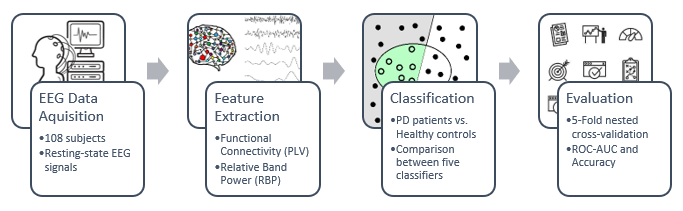

Our pipeline consists of four big steps:
- Acquisition of resting-state EEG signals of 108 subjects.
- Extraction of the spectral and connectivity features.
- Classification of PD and HC using five different classifiers.
- Evaluation of the algorithms' performances.

**The [Functions](#Functions) present on top of the notebook should all be run prior to the code present in the [main](#Main) section that deals with the data, the performances and their visualization.**

## Data

[Get the data](https://drive.google.com/drive/folders/1gIWUcmGUpf6bkVjqAJDzbnT-CnfyZsji?usp=sharing) necessary to run the code.
> Pay attention to changing the directory variables present in the code (data_dir, PLV_dir_HC, PLV_dir_PD, RBP_dir_HC and RBP_dir_PD) with the corresponding location of the files on your machine in the following sections: [section 1](#section_1), [section 2](#section_2), [section 3](#section_3), [section 4](#section_4), [section 5](#section_5), [section 6](#section_6), [section 7](#section_7), and [section 8](#section_8)


## Training the models
Before training any of the models with any combination of features, this [section](#training) should be run to initialize the classifiers and to set up the training loops.

#### PLV & Demographic Features
Models were trained using three types of correlation for the PLV features: [positive](#PLV_dem_pos), [negative](#PLV_dem_neg), and [mixed](#PLV_dem_mix) tails.

#### RBP & Demographic Features
Models were trained with three types of correlation for the RBP features: [positive](#RBP_dem_pos), [negative](#RBP_dem_neg), and [mixed](#RBP_dem_mix) tails.

#### PLV, RBP & Demographic Features
Models were trained with three types of correlation for the PLV and RBP features: [positive](#PLV_RBP_dem_pos), [negative](#PLV_RBP_dem_neg), and [mixed](#PLV_RBP_dem_mix) tails.
A section was added to [test](#testing) the classifier that gave the highest performance (Extra Trees), trained with connectivity, spectral and demographic features

#### PLV Features Only
Models were trained with three types of correlation for the PLV features: [positive](#PLV_pos), [negative](#PLV_neg), and [mixed](#PLV_mix) tails.

#### RBP Features Only
Models were trained with three types of correlation for the RBP features: [positive](#RBP_pos), [negative](#RBP_neg), and [mixed](#RBP_mix) tails.

#### PLV & RBP Features
Models were trained with three types of correlation for the PLV and RBP features: [positive](#PLV_RBP_pos), [negative](#PLV_RBP_neg), and [mixed](#PLV_RBP_mix) tails.

#### Demographic Features Only
Models were trained with [demographic](#demog) data only.

# Functions

**construct_conn_matrix:** takes the dimension and the values of the upper triangular part of the connectivity matrix and returns the full conenctivity matrix with diagonals set to 0 since they are not interesting

In [1]:
def  construct_conn_matrix(n,vals):
    m = np.zeros([n,n], dtype=np.double)
    xs,ys = np.triu_indices(n,k=1)
    m[xs,ys] = vals
    m[ys,xs] = vals
    m[ np.diag_indices(n) ] = 0 # we set diagonals to 0 since they don't represent any relation between two brain regions
    return m

# Testing the "construct_conn_matrix" function
import numpy as np
test = np.array([1, 2, 3, 4, 5, 6])
conn_test = construct_conn_matrix(4, test)
print("Before: ", test)
print("After: \n", conn_test)

Before:  [1 2 3 4 5 6]
After: 
 [[0. 1. 2. 3.]
 [1. 0. 4. 5.]
 [2. 4. 0. 6.]
 [3. 5. 6. 0.]]


**get_PLV_by_bands:** to get the PLV features by band from the dataframe X. It returns an object of type 'PLV' that has the 21945 PLV features for each one of the subjects present in X.

In [2]:
# Creating a PLV class that has the five bands as attributes
from dataclasses import dataclass
from scipy import stats
@dataclass
class PLV:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
        
def get_PLV_by_bands(X, brain_regions):
    
    N = int(brain_regions*(brain_regions - 1) / 2)
    
    band1_PLV, band2_PLV, band3_PLV, band4_PLV, band5_PLV = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for i in range(X.shape[0]):
        
        data1 = np.array(X['Delta Band PLV'].iloc[i])
        band1_PLV = np.vstack([band1_PLV, data1])
        
        data2 = np.array(X['Theta Band PLV'].iloc[i])
        band2_PLV = np.vstack([band2_PLV, data2])
        
        data3 = np.array(X['Alpha-1 Band PLV'].iloc[i])
        band3_PLV = np.vstack([band3_PLV, data3])
        
        data4 = np.array(X['Alpha-2 Band PLV'].iloc[i])
        band4_PLV = np.vstack([band4_PLV, data4])
        
        data5 = np.array(X['Beta Band PLV'].iloc[i])
        band5_PLV = np.vstack([band5_PLV, data5])
        
    band1_PLV = np.delete(band1_PLV, (0), axis=0)
    band2_PLV = np.delete(band2_PLV, (0), axis=0)
    band3_PLV = np.delete(band3_PLV, (0), axis=0)
    band4_PLV = np.delete(band4_PLV, (0), axis=0)
    band5_PLV = np.delete(band5_PLV, (0), axis=0)
    
    plv = PLV(band1_PLV, band2_PLV, band3_PLV, band4_PLV, band5_PLV) # object of type PLV
    
    return plv

**get_conn_matrices_by_bands:** returns an object of type 'conn_matrices' that contains the connectivity matrices of each band

In [3]:
# Creating a 'conn_matrices' class that has the five bands as attributes representing the connectivity matrices in each band
from dataclasses import dataclass
@dataclass
class conn_matrices:
    band1: list
    band2: list
    band3: list
    band4: list
    band5: list

def get_conn_matrices_by_bands(PLV, brain_regions):
    
    band1_conn_matrices, band2_conn_matrices, band3_conn_matrices, band4_conn_matrices, band5_conn_matrices = [], [], [], [], []
    
    for i in range(PLV.band1.shape[0]):
        band1_conn_matrices.append(construct_conn_matrix(brain_regions, PLV.band1[i,:]))
        band2_conn_matrices.append(construct_conn_matrix(brain_regions, PLV.band2[i,:]))
        band3_conn_matrices.append(construct_conn_matrix(brain_regions, PLV.band3[i,:]))
        band4_conn_matrices.append(construct_conn_matrix(brain_regions, PLV.band4[i,:]))
        band5_conn_matrices.append(construct_conn_matrix(brain_regions, PLV.band5[i,:]))
    
    conn_mat = conn_matrices(band1_conn_matrices,
                             band2_conn_matrices,
                             band3_conn_matrices,
                             band4_conn_matrices,
                             band5_conn_matrices)
    
    return conn_mat

**upper_triangular_to_symmetric:** transforms an upper triangular matrix into a symmetric one

In [4]:
def upper_triangular_to_symmetric(ut):
    n = ut.shape[0]
    for r in range(1, n):
        for c in range(r):
            ut[r, c] = ut[c, r]
    return ut

# Testing the "upper_triangular_to_symmetric" matrix
test = np.array([[0,1,2,3],
                 [0,0,4,5],
                 [0,0,0,5],
                 [0,0,0,0]])
res = upper_triangular_to_symmetric(test)
res

array([[0, 1, 2, 3],
       [1, 0, 4, 5],
       [2, 4, 0, 5],
       [3, 5, 5, 0]])

**get_r_and_p_mats_by_bands:** to calculate matrices of correlation (Point-Biserial) and matrices of the corresponding p-values in each band.

In [5]:
from dataclasses import dataclass
@dataclass
class r_mat:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
@dataclass
class p_mat:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
@dataclass
class pos_masks:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
@dataclass
class neg_masks:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
        
        
def get_r_and_p_mats_by_bands(X , y, conn_matrices, brain_regions):

    from copy import deepcopy
    group = deepcopy(y)

    a, b, c, d, e = [], [], [], [], []
    j = 0
    k = 1
    

    r_mat_band1 = np.zeros((brain_regions,brain_regions))
    p_mat_band1 = np.zeros((brain_regions,brain_regions))

    r_mat_band2 = np.zeros((brain_regions,brain_regions))
    p_mat_band2 = np.zeros((brain_regions,brain_regions))

    r_mat_band3 = np.zeros((brain_regions,brain_regions))
    p_mat_band3 = np.zeros((brain_regions,brain_regions))

    r_mat_band4 = np.zeros((brain_regions,brain_regions))
    p_mat_band4 = np.zeros((brain_regions,brain_regions))

    r_mat_band5 = np.zeros((brain_regions,brain_regions))
    p_mat_band5 = np.zeros((brain_regions,brain_regions))
    

    while j < brain_regions - 1:
    
        for i in range(X.shape[0]):
            a.append(conn_matrices.band1[i][j][k])
            b.append(conn_matrices.band2[i][j][k]) 
            c.append(conn_matrices.band3[i][j][k]) 
            d.append(conn_matrices.band4[i][j][k]) 
            e.append(conn_matrices.band5[i][j][k])

        a = np.array(a)
        test_band1 = stats.pointbiserialr(group, a)
        r_mat_band1[j][k] = test_band1.correlation
        p_mat_band1[j][k] = test_band1.pvalue
        a = []
    
        b = np.array(b)
        test_band2 = stats.pointbiserialr(group, b)
        r_mat_band2[j][k] = test_band2.correlation
        p_mat_band2[j][k] = test_band2.pvalue
        b = []
    
        c = np.array(c)
        test_band3 = stats.pointbiserialr(group, c)
        r_mat_band3[j][k] = test_band3.correlation
        p_mat_band3[j][k] = test_band3.pvalue
        c = []
    
        d = np.array(d)
        test_band4 = stats.pointbiserialr(group, d)
        r_mat_band4[j][k] = test_band4.correlation
        p_mat_band4[j][k] = test_band4.pvalue
        d = []
    
        e = np.array(e)
        test_band5 = stats.pointbiserialr(group, e)
        r_mat_band5[j][k] = test_band5.correlation
        p_mat_band5[j][k] = test_band5.pvalue
        e = []
    
        if (k == brain_regions - 1):
            j = j+1
            k = j+1
        else:
            k = k+1
            
    r_mat_band1 = upper_triangular_to_symmetric(r_mat_band1)
    p_mat_band1 = upper_triangular_to_symmetric(p_mat_band1)
    np.fill_diagonal(p_mat_band1,1)

    r_mat_band2 = upper_triangular_to_symmetric(r_mat_band2)
    p_mat_band2 = upper_triangular_to_symmetric(p_mat_band2)
    np.fill_diagonal(p_mat_band2,1)

    r_mat_band3 = upper_triangular_to_symmetric(r_mat_band3)
    p_mat_band3 = upper_triangular_to_symmetric(p_mat_band3)
    np.fill_diagonal(p_mat_band3,1)

    r_mat_band4 = upper_triangular_to_symmetric(r_mat_band4)
    p_mat_band4 = upper_triangular_to_symmetric(p_mat_band4)
    np.fill_diagonal(p_mat_band4,1)

    r_mat_band5 = upper_triangular_to_symmetric(r_mat_band5)
    p_mat_band5 = upper_triangular_to_symmetric(p_mat_band5)
    np.fill_diagonal(p_mat_band5,1)
    
    
    r_mats = r_mat(r_mat_band1, r_mat_band2, r_mat_band3, r_mat_band4, r_mat_band5)
    p_mats = p_mat(p_mat_band1, p_mat_band2, p_mat_band3, p_mat_band4, p_mat_band5)
            
        
    return r_mats, p_mats

**get_pos_masks_by_bands:** returns five masks (one for each band) for the positive tail

In [6]:
def get_pos_masks_by_bands(thresh, r_mat, p_mat):

    pos_mask_band1 = np.zeros(r_mat.band1.shape)
    index1 = np.argwhere((r_mat.band1 > 0) & (p_mat.band1 < thresh))
    for i in range(index1.shape[0]):
        pos_mask_band1[index1[i][0]][index1[i][1]] = 1

    pos_mask_band2 = np.zeros(r_mat.band2.shape)
    index2 = np.argwhere((r_mat.band2 > 0) & (p_mat.band2 < thresh))
    for i in range(index2.shape[0]):
        pos_mask_band2[index2[i][0]][index2[i][1]] = 1

    pos_mask_band3 = np.zeros(r_mat.band3.shape)
    index3 = np.argwhere((r_mat.band3 > 0) & (p_mat.band3 < thresh))
    for i in range(index3.shape[0]):
        pos_mask_band3[index3[i][0]][index3[i][1]] = 1

    pos_mask_band4 = np.zeros(r_mat.band4.shape)
    index4 = np.argwhere((r_mat.band4 > 0) & (p_mat.band4 < thresh))
    for i in range(index4.shape[0]):
        pos_mask_band4[index4[i][0]][index4[i][1]] = 1

    pos_mask_band5 = np.zeros(r_mat.band5.shape)
    index5 = np.argwhere((r_mat.band5 > 0) & (p_mat.band5 < thresh))
    for i in range(index5.shape[0]):
        pos_mask_band5[index5[i][0]][index5[i][1]] = 1
    
    positive_masks = pos_masks(pos_mask_band1, pos_mask_band2, pos_mask_band3, pos_mask_band4, pos_mask_band5)
    
    return positive_masks

**get_neg_masks_by_bands:** returns five masks (one for each band) for the negative tail

In [7]:
def get_neg_masks_by_bands(thresh, r_mat, p_mat):

    neg_mask_band1 = np.zeros(r_mat.band1.shape)
    index1 = np.argwhere((r_mat.band1 < 0) & (p_mat.band1 < thresh))
    for i in range(index1.shape[0]):
        neg_mask_band1[index1[i][0]][index1[i][1]] = 1

    neg_mask_band2 = np.zeros(r_mat.band2.shape)
    index2 = np.argwhere((r_mat.band2 < 0) & (p_mat.band2 < thresh))
    for i in range(index2.shape[0]):
        neg_mask_band2[index2[i][0]][index2[i][1]] = 1

    neg_mask_band3 = np.zeros(r_mat.band3.shape)
    index3 = np.argwhere((r_mat.band3 < 0) & (p_mat.band3 < thresh))
    for i in range(index3.shape[0]):
        neg_mask_band3[index3[i][0]][index3[i][1]] = 1

    neg_mask_band4 = np.zeros(r_mat.band4.shape)
    index4 = np.argwhere((r_mat.band4 < 0) & (p_mat.band4 < thresh))
    for i in range(index4.shape[0]):
        neg_mask_band4[index4[i][0]][index4[i][1]] = 1

    neg_mask_band5 = np.zeros(r_mat.band5.shape)
    index5 = np.argwhere((r_mat.band5 < 0) & (p_mat.band5 < thresh))
    for i in range(index5.shape[0]):
        neg_mask_band5[index5[i][0]][index5[i][1]] = 1
        
    negative_masks = neg_masks(neg_mask_band1, neg_mask_band2, neg_mask_band3, neg_mask_band4, neg_mask_band5)
    
    # return neg_mask_band1, neg_mask_band2, neg_mask_band3, neg_mask_band4, neg_mask_band5
    return negative_masks

**get_NS_by_band:** Calculation of the Network Strengths in each frequency band. Returns an object of type 'NS' containing the network strengths in each band.

In [8]:
@dataclass
class NS:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
        

def get_NS_by_band(X, brain_regions, conn_matrices, mask):
    NS_band1, NS_band2, NS_band3, NS_band4, NS_band5 = [], [], [], [], []
    
    for i in range(X.shape[0]):
        scores_band1 = np.multiply(conn_matrices.band1[i],mask.band1)
        scores_band1 = scores_band1[np.triu_indices(brain_regions, k=1)]                       
        indices_band1 = np.nonzero(scores_band1) 
        scores_band1 = scores_band1[indices_band1]
        #zscores_band1 = stats.zscore(scores_band1, nan_policy = 'omit')
        
        scores_band2 = np.multiply(conn_matrices.band2[i],mask.band2)
        scores_band2 = scores_band2[np.triu_indices(brain_regions, k=1)]  
        indices_band2 = np.nonzero(scores_band2) 
        scores_band2 = scores_band2[indices_band2]
        #zscores_band2 = stats.zscore(scores_band2, nan_policy = 'omit')
        
        scores_band3 = np.multiply(conn_matrices.band3[i],mask.band3)
        scores_band3 = scores_band3[np.triu_indices(brain_regions, k=1)]  
        indices_band3 = np.nonzero(scores_band3) 
        scores_band3 = scores_band3[indices_band3]
        #zscores_band3 = stats.zscore(scores_band3, nan_policy = 'omit')
                               
        scores_band4 = np.multiply(conn_matrices.band3[i],mask.band4)
        scores_band4 = scores_band4[np.triu_indices(brain_regions, k=1)]                         
        indices_band4 = np.nonzero(scores_band4) 
        scores_band4 = scores_band4[indices_band4]
        #zscores_band4 = stats.zscore(scores_band4, nan_policy = 'omit')
        
        scores_band5 = np.multiply(conn_matrices.band5[i],mask.band5)
        scores_band5 = scores_band5[np.triu_indices(brain_regions, k=1)]                         
        indices_band5 = np.nonzero(scores_band5) 
        scores_band5 = scores_band5[indices_band5]
        #zscores_band5 = stats.zscore(scores_band5, nan_policy = 'omit')
            
        NS_band1.append(np.mean(scores_band1))
        NS_band2.append(np.mean(scores_band2))
        NS_band3.append(np.mean(scores_band3))
        NS_band4.append(np.mean(scores_band4))
        NS_band5.append(np.mean(scores_band5))
                               
    NS_band1 = np.array(NS_band1)
    NS_band2 = np.array(NS_band2)
    NS_band3 = np.array(NS_band3)
    NS_band4 = np.array(NS_band4)
    NS_band5 = np.array(NS_band5)
    
    network_strengths = NS(NS_band1, NS_band2, NS_band3, NS_band4, NS_band5)
                               
    return network_strengths

**ccf_train:** returns the correlation matrix and the masks for the positive and negative tails in the training set and those will be used later for the testing set. It also returns the positive, negative and mixed network strengths of the training set. This function will be used in each fold of the nested cross validation later on when we will fit the models

In [9]:
def ccf_train(X, y, brain_regions, p_thresh):
    
    # Getting the Connectivity matrices of each band for the training dataset 
    PLV_train = get_PLV_by_bands(X, brain_regions)
    conn_matrices_train = get_conn_matrices_by_bands(PLV_train, brain_regions)
    
    # Calculating r and p matrices for the training data
    r_mat_train, p_mat_train = get_r_and_p_mats_by_bands(X, y, conn_matrices_train, brain_regions)
    
    # Calculating positive and negative masks masks for the training data
    pos_masks_train = get_pos_masks_by_bands(p_thresh, r_mat_train, p_mat_train)
    neg_masks_train = get_neg_masks_by_bands(p_thresh, r_mat_train, p_mat_train)
    
    # Calculating positive, negative and mixed Network Strengths for training data
    pos_NS_train = get_NS_by_band(X, brain_regions, conn_matrices_train, pos_masks_train)
    neg_NS_train = get_NS_by_band(X, brain_regions, conn_matrices_train, neg_masks_train)
    mix_NS_train = NS(pos_NS_train.band1 - neg_NS_train.band1, pos_NS_train.band2 - neg_NS_train.band2,
                      pos_NS_train.band3 - neg_NS_train.band3, pos_NS_train.band4 - neg_NS_train.band4, 
                      pos_NS_train.band5 - neg_NS_train.band5)
    
    return r_mat_train, pos_masks_train, neg_masks_train, pos_NS_train, neg_NS_train, mix_NS_train

**ccf_test:** returns the positive, negative and mixed network strengths of the testing set. This function will be used in each fold of the nested cross validation later on when we will evaluate the models.

In [10]:
def ccf_test(X, y, brain_regions, pos_masks, neg_masks):
    
    # Getting the Connectivity matrices of each band for the testing dataset 
    PLV_test = get_PLV_by_bands(X, brain_regions)
    conn_matrices_test = get_conn_matrices_by_bands(PLV_test, brain_regions)
    
    # Calculating positive, negative and mixed Network Strengths for testing data
    pos_NS_test = get_NS_by_band(X, brain_regions, conn_matrices_test, pos_masks)
    neg_NS_test = get_NS_by_band(X, brain_regions, conn_matrices_test, neg_masks)
    mix_NS_test = NS(pos_NS_test.band1 - neg_NS_test.band1, pos_NS_test.band2 - neg_NS_test.band2,
                      pos_NS_test.band3 - neg_NS_test.band3, pos_NS_test.band4 - neg_NS_test.band4, 
                      pos_NS_test.band5 - neg_NS_test.band5)
    
    return pos_NS_test, neg_NS_test, mix_NS_test

**get_RBP_by_bands:** to get the RBP features by bands from the dataframe X. Returns object of type PLV that has the 21945 PLV features for each one of the subjects present in X.

In [11]:
from dataclasses import dataclass
@dataclass
class RBP:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
        
        
def get_RBP_by_bands(X, brain_regions):
    
    
    band1_RBP, band2_RBP, band3_RBP, band4_RBP, band5_RBP = np.zeros(brain_regions), np.zeros(brain_regions), np.zeros(brain_regions), np.zeros(brain_regions), np.zeros(brain_regions)
    
    for i in range(X.shape[0]):
        
        data1 = np.array(X['Delta Band RBP'].iloc[i])
        band1_RBP = np.vstack([band1_RBP, data1])
        
        data2 = np.array(X['Theta Band RBP'].iloc[i])
        band2_RBP = np.vstack([band2_RBP, data2])
        
        data3 = np.array(X['Alpha-1 Band RBP'].iloc[i])
        band3_RBP = np.vstack([band3_RBP, data3])
        
        data4 = np.array(X['Alpha-2 Band RBP'].iloc[i])
        band4_RBP = np.vstack([band4_RBP, data4])
        
        data5 = np.array(X['Beta Band RBP'].iloc[i])
        band5_RBP = np.vstack([band5_RBP, data5])
        
    band1_RBP = np.delete(band1_RBP, (0), axis=0)
    band2_RBP = np.delete(band2_RBP, (0), axis=0)
    band3_RBP = np.delete(band3_RBP, (0), axis=0)
    band4_RBP = np.delete(band4_RBP, (0), axis=0)
    band5_RBP = np.delete(band5_RBP, (0), axis=0)
    
    rbp = RBP(band1_RBP, band2_RBP, band3_RBP, band4_RBP, band5_RBP)
    
    return rbp

**get_r_and_p_vects_by_bands:** calculate vectors of correlation (Point-Biserial) and vectors of the corresponding p-values in each band.

In [12]:
from dataclasses import dataclass

@dataclass
class r_vect:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray

@dataclass
class p_vect:
    band1: np.ndarray
    band2: np.ndarray
    band3: np.ndarray
    band4: np.ndarray
    band5: np.ndarray
        
        
def get_r_and_p_vects_by_bands(X , y, rbp, brain_regions):

    from copy import deepcopy
    group = deepcopy(y)

    a, b, c, d, e = [], [], [], [], []
    j = 0
    k = 0
    

    r_vect_band1 = np.zeros(brain_regions)
    p_vect_band1 = np.zeros(brain_regions)

    r_vect_band2 = np.zeros(brain_regions)
    p_vect_band2 = np.zeros(brain_regions)

    r_vect_band3 = np.zeros(brain_regions)
    p_vect_band3 = np.zeros(brain_regions)

    r_vect_band4 = np.zeros(brain_regions)
    p_vect_band4 = np.zeros(brain_regions)

    r_vect_band5 = np.zeros(brain_regions)
    p_vect_band5 = np.zeros(brain_regions)
    

    while j < brain_regions - 1:
    
        for i in range(X.shape[0]):
            a.append(rbp.band1[i][j])
            b.append(rbp.band2[i][j]) 
            c.append(rbp.band3[i][j]) 
            d.append(rbp.band4[i][j]) 
            e.append(rbp.band5[i][j])

        a = np.array(a)
        test_band1 = stats.pointbiserialr(group, a)
        r_vect_band1[j] = test_band1.correlation
        p_vect_band1[j] = test_band1.pvalue
        a = []
    
        b = np.array(b)
        test_band2 = stats.pointbiserialr(group, b)
        r_vect_band2[j] = test_band2.correlation
        p_vect_band2[j] = test_band2.pvalue
        b = []
    
        c = np.array(c)
        test_band3 = stats.pointbiserialr(group, c)
        r_vect_band3[j] = test_band3.correlation
        p_vect_band3[j] = test_band3.pvalue
        c = []
    
        d = np.array(d)
        test_band4 = stats.pointbiserialr(group, d)
        r_vect_band4[j] = test_band4.correlation
        p_vect_band4[j] = test_band4.pvalue
        d = []
    
        e = np.array(e)
        test_band5 = stats.pointbiserialr(group, e)
        r_vect_band5[j] = test_band5.correlation
        p_vect_band5[j] = test_band5.pvalue
        e = []
        
        j=j+1
    
    
    r_vects = r_vect(r_vect_band1, r_vect_band2, r_vect_band3, r_vect_band4, r_vect_band5)
    p_vects = p_vect(p_vect_band1, p_vect_band2, p_vect_band3, p_vect_band4, p_vect_band5)
            
        
    return r_vects, p_vects

**get_pos_vect_masks_by_bands:** returns five masks (one for each band) for the positive tail in the case of RBP (spectral) features.

In [13]:
def get_pos_vect_masks_by_bands(thresh, r_vect, p_vect):

    pos_vect_mask_band1 = np.zeros(r_vect.band1.shape)
    index1 = np.argwhere((r_vect.band1 > 0) & (p_vect.band1 < thresh))
    for i in range(index1.shape[0]):
        pos_vect_mask_band1[index1[i][0]] = 1

    pos_vect_mask_band2 = np.zeros(r_vect.band2.shape)
    index2 = np.argwhere((r_vect.band2 > 0) & (p_vect.band2 < thresh))
    for i in range(index2.shape[0]):
        pos_vect_mask_band2[index2[i][0]] = 1

    pos_vect_mask_band3 = np.zeros(r_vect.band3.shape)
    index3 = np.argwhere((r_vect.band3 > 0) & (p_vect.band3 < thresh))
    for i in range(index3.shape[0]):
        pos_vect_mask_band3[index3[i][0]] = 1

    pos_vect_mask_band4 = np.zeros(r_vect.band4.shape)
    index4 = np.argwhere((r_vect.band4 > 0) & (p_vect.band4 < thresh))
    for i in range(index4.shape[0]):
        pos_vect_mask_band4[index4[i][0]] = 1

    pos_vect_mask_band5 = np.zeros(r_vect.band5.shape)
    index5 = np.argwhere((r_vect.band5 > 0) & (p_vect.band5 < thresh))
    for i in range(index5.shape[0]):
        pos_vect_mask_band5[index5[i][0]] = 1
    
    positive_vect_masks = pos_masks(pos_vect_mask_band1, pos_vect_mask_band2, pos_vect_mask_band3, pos_vect_mask_band4, pos_vect_mask_band5)
    
    return positive_vect_masks

**get_neg_vect_masks_by_bands:** returns five masks (one for each band) for the positive tail in the case of RBP (spectral).

In [14]:
def get_neg_vect_masks_by_bands(thresh, r_vect, p_vect):

    neg_vect_mask_band1 = np.zeros(r_vect.band1.shape)
    index1 = np.argwhere((r_vect.band1 < 0) & (p_vect.band1 < thresh))
    for i in range(index1.shape[0]):
        neg_vect_mask_band1[index1[i][0]] = 1

    neg_vect_mask_band2 = np.zeros(r_vect.band2.shape)
    index2 = np.argwhere((r_vect.band2 < 0) & (p_vect.band2 < thresh))
    for i in range(index2.shape[0]):
        neg_vect_mask_band2[index2[i][0]] = 1

    neg_vect_mask_band3 = np.zeros(r_vect.band3.shape)
    index3 = np.argwhere((r_vect.band3 < 0) & (p_vect.band3 < thresh))
    for i in range(index3.shape[0]):
        neg_vect_mask_band3[index3[i][0]] = 1

    neg_vect_mask_band4 = np.zeros(r_vect.band4.shape)
    index4 = np.argwhere((r_vect.band4 < 0) & (p_vect.band4 < thresh))
    for i in range(index4.shape[0]):
        neg_vect_mask_band4[index4[i][0]] = 1

    neg_vect_mask_band5 = np.zeros(r_vect.band5.shape)
    index5 = np.argwhere((r_vect.band5 < 0) & (p_vect.band5 < thresh))
    for i in range(index5.shape[0]):
        neg_vect_mask_band5[index5[i][0]] = 1
    
    negative_vect_masks = neg_masks(neg_vect_mask_band1, neg_vect_mask_band2, neg_vect_mask_band3, neg_vect_mask_band4, neg_vect_mask_band5)
    
    return negative_vect_masks

**get_NS_by_band_RBP:** calculation of the Network Strengths in each frequency band. Returns an object of type 'NS' containing the network strengths in each band.

In [15]:
def get_NS_by_band_RBP(X, rbp, mask):
    NS_band1, NS_band2, NS_band3, NS_band4, NS_band5 = [], [], [], [], []
    
    for i in range(X.shape[0]):
        scores_band1 = np.multiply(rbp.band1[i],mask.band1)
        #zscores_band1 = stats.zscore(scores_band1, nan_policy = 'omit')
        
        scores_band2 = np.multiply(rbp.band2[i],mask.band2)
        #zscores_band2 = stats.zscore(scores_band2, nan_policy = 'omit')
        
        scores_band3 = np.multiply(rbp.band3[i],mask.band3)
        #zscores_band3 = stats.zscore(scores_band3, nan_policy = 'omit')
                               
        scores_band4 = np.multiply(rbp.band3[i],mask.band4)
        #zscores_band4 = stats.zscore(scores_band4, nan_policy = 'omit')
        
        scores_band5 = np.multiply(rbp.band5[i],mask.band5)
        #zscores_band5 = stats.zscore(scores_band5, nan_policy = 'omit')
            
        NS_band1.append(np.mean(scores_band1))
        NS_band2.append(np.mean(scores_band2))
        NS_band3.append(np.mean(scores_band3))
        NS_band4.append(np.mean(scores_band4))
        NS_band5.append(np.mean(scores_band5))
                               
    NS_band1 = np.array(NS_band1)
    NS_band2 = np.array(NS_band2)
    NS_band3 = np.array(NS_band3)
    NS_band4 = np.array(NS_band4)
    NS_band5 = np.array(NS_band5)
    
    network_strengths = NS(NS_band1, NS_band2, NS_band3, NS_band4, NS_band5)
                               
    return network_strengths

**ccf_train_RBP:** returns the masks for the postive and negative tails in the training set and those will be used later for the testing set. It also returns the network strengths of the positive, negative and mixed tails in the training set. This function will be used in each fold of the nested cross-validation later on when we will fit the models.

In [16]:
def ccf_train_RBP(X, y, brain_regions, p_thresh):
    
    # Getting the Connectivity matrices of each band for the training dataset 
    RBP_train = get_RBP_by_bands(X, brain_regions)
    
    # Calculating r and p matrices for the training data
    r_vect_train, p_vect_train = get_r_and_p_vects_by_bands(X, y, RBP_train, brain_regions)
    
    # Calculating positive and negative masks masks for the training data
    pos_vect_masks_train = get_pos_vect_masks_by_bands(p_thresh, r_vect_train, p_vect_train)
    neg_vect_masks_train = get_neg_vect_masks_by_bands(p_thresh, r_vect_train, p_vect_train)
    
    # Calculating positive, negative and mixed Network Strengths for training data
    pos_NS_train_RBP = get_NS_by_band_RBP(X, RBP_train, pos_vect_masks_train)
    neg_NS_train_RBP = get_NS_by_band_RBP(X, RBP_train, neg_vect_masks_train)
    mix_NS_train_RBP = NS(pos_NS_train_RBP.band1 - neg_NS_train_RBP.band1, pos_NS_train_RBP.band2 - neg_NS_train_RBP.band2,
                      pos_NS_train_RBP.band3 - neg_NS_train_RBP.band3, pos_NS_train_RBP.band4 - neg_NS_train_RBP.band4, 
                      pos_NS_train_RBP.band5 - neg_NS_train_RBP.band5)
    
    return pos_vect_masks_train, neg_vect_masks_train, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP

**ccf_test_RBP:** returns the network strengths of the positive, negative and mixed tails in the testing set. This function will be used in each fold of the nested cross-validation later on when we will evaluate the models.

In [17]:
def ccf_test_RBP(X, y, brain_regions, pos_masks, neg_masks):
    
    # Getting the Connectivity matrices of each band for the testing dataset 
    RBP_test = get_RBP_by_bands(X, brain_regions)
    
    # Calculating positive, negative and mixed Network Strengths for testing data
    pos_NS_test_RBP = get_NS_by_band_RBP(X, RBP_test, pos_masks)
    neg_NS_test_RBP = get_NS_by_band_RBP(X, RBP_test, neg_masks)
    mix_NS_test_RBP = NS(pos_NS_test_RBP.band1 - neg_NS_test_RBP.band1, pos_NS_test_RBP.band2 - neg_NS_test_RBP.band2,
                      pos_NS_test_RBP.band3 - neg_NS_test_RBP.band3, pos_NS_test_RBP.band4 - neg_NS_test_RBP.band4, 
                      pos_NS_test_RBP.band5 - neg_NS_test_RBP.band5)
    
    return pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP

# Main

<a id="section_1"></a>

In [18]:
# Loading the demographic data
import pandas as pd

data_dir = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Demographic_BL.xlsx' # Change the directory if needed to load the data

df = pd.read_excel(data_dir)
df.drop(['Visit','Disease Duration (months)','LED'], 1, inplace=True)
print (df)

        ID Group   Age  EduTot  Sex
0    CG001    PD  67.0    18.0  0.0
1    CG002    PD  70.0    10.0  1.0
2    CG005    PD  62.0    11.0  0.0
3    CG006    PD  59.0    11.0  0.0
4    CG007    PD  59.0    11.0  0.0
..     ...   ...   ...     ...  ...
104  CT095    HC  67.0    17.0  0.0
105  CT096    HC  67.0    18.0  0.0
106  CT097    HC  65.0    12.0  0.0
107  CT098    HC  71.0    17.0  1.0
108  CT099    HC  66.0    10.0  1.0

[109 rows x 5 columns]


In [19]:
print(df.iloc[[85]])

       ID Group  Age  EduTot  Sex
85  CT074    HC  NaN     NaN  NaN


In [20]:
# Dropping the 85th record since we don't have any values for the Age, EduTot and Sex
df.drop(85, inplace=True)

In [21]:
# Seperating data of PD and HC
df_PD = df[df["Group"] == "PD"]
df_HC = df[df["Group"] == "HC"]
print(df_PD)
print(df_HC)

       ID Group   Age  EduTot  Sex
0   CG001    PD  67.0    18.0  0.0
1   CG002    PD  70.0    10.0  1.0
2   CG005    PD  62.0    11.0  0.0
3   CG006    PD  59.0    11.0  0.0
4   CG007    PD  59.0    11.0  0.0
..    ...   ...   ...     ...  ...
72  CT058    PD  66.0    14.0  0.0
73  CT059    PD  56.0    12.0  1.0
74  CT060    PD  73.0    16.0  0.0
75  CT061    PD  65.0    18.0  0.0
76  CT062    PD  53.0     9.0  1.0

[77 rows x 5 columns]
        ID Group   Age  EduTot  Sex
77   CT055    HC  62.0    17.0  1.0
78   CT063    HC  56.0    16.0  0.0
79   CT065    HC  53.0    13.0  1.0
80   CT068    HC  75.0    11.0  1.0
81   CT069    HC  64.0    13.0  0.0
82   CT071    HC  62.0    11.0  1.0
83   CT072    HC  56.0     9.0  0.0
84   CT073    HC  57.0    12.0  1.0
86   CT075    HC  64.0    16.0  0.0
87   CT076    HC  70.0    17.0  0.0
88   CT077    HC  74.0    18.0  0.0
89   CT078    HC  67.0    10.0  0.0
90   CT079    HC  64.0    12.0  0.0
91   CT080    HC  74.0    13.0  0.0
92   CT081    HC 

In [22]:
df_PD.shape, df_HC.shape

((77, 5), (31, 5))

We have 77 PD patients and 31 HC

##### Testing for statistical significance between PD and HC groups based on the possible confounders (Age, Sex and Education)

In [23]:
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, chisquare

c = ['Age','EduTot','Sex']
for col in c:
    v1 = np.array(df_PD[col])
    v2 = np.array(df_HC[col])
    if col == 'Sex':
        # Chi-2 test for two categorical variables
        from scipy.stats import chi2_contingency
        count_males_PD = np.count_nonzero(v1 == 0)
        count_males_HC = np.count_nonzero(v2 == 0)
        count_females_PD = np.count_nonzero(v1 == 1)
        count_females_HC = np.count_nonzero(v2 == 1)
        cross_table = np.array([[count_males_PD, count_males_HC], [count_females_PD, count_females_HC]])
        chi2, p, dof, ex = chi2_contingency(cross_table)
        print("For the Sex: statistic=" + str(chi2) + ", pvalue=" + str(p))
    else:
        res = ttest_ind(v1, v2)
        print("For the " + col + ": " + str(res))

For the Age: Ttest_indResult(statistic=0.5668972174778188, pvalue=0.5719825141863952)
For the EduTot: Ttest_indResult(statistic=1.1442645418959472, pvalue=0.25509128236721096)
For the Sex: statistic=0.7905246556100449, pvalue=0.37394152831398


No statistical significance has been depicted in the demographic data between PD and HC

# Connectivity Features (PLV) with the demographics

<a id="section_2"></a>

In [24]:
# Loading the PLV features
import scipy.io

# features directory files (should be modified when executing on a different machine)
PLV_dir_HC = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\PLV_features_HC_BL.mat'
PLV_dir_PD = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\PLV_features_PD_BL.mat'

PLV_features_HC = scipy.io.loadmat(PLV_dir_HC)
PLV_features_PD = scipy.io.loadmat(PLV_dir_PD)
PLV_features_HC = PLV_features_HC['feathc']
PLV_features_PD = PLV_features_PD['feat']
PLV_features_HC.shape, PLV_features_PD.shape

((32, 21945, 5), (77, 21945, 5))

In [25]:
# Deleting the features related to the previously deleted patient
PLV_features_HC = np.delete(PLV_features_HC, 8, axis=0)
PLV_features_HC.shape

(31, 21945, 5)

In [26]:
df.head()

,ID,Group,Age,EduTot,Sex
0,CG001,PD,67.0,18.0,0.0
1,CG002,PD,70.0,10.0,1.0
2,CG005,PD,62.0,11.0,0.0
3,CG006,PD,59.0,11.0,0.0
4,CG007,PD,59.0,11.0,0.0


### Plotting the data

In [27]:
# Making the sex column (independent variable) a string variable in order to show it in the plots: Female for 1 and Male for 0
df_plot = df.copy(deep = True)
if df_plot['Sex'][0] == 0.0 or df_plot['Sex'][0] == 1.0:
    temp = {0.0: 'Male', 1.0: 'Female'}
    a = np.array(df_plot['Sex'].map(temp))
    df_plot['Sex'] = a
df_plot = df_plot.reset_index(drop=True)
df_plot

,ID,Group,Age,EduTot,Sex
0,CG001,PD,67.0,18.0,Male
1,CG002,PD,70.0,10.0,Female
2,CG005,PD,62.0,11.0,Male
3,CG006,PD,59.0,11.0,Male
4,CG007,PD,59.0,11.0,Male
...,...,...,...,...,...
103,CT095,HC,67.0,17.0,Male
104,CT096,HC,67.0,18.0,Male
105,CT097,HC,65.0,12.0,Male
106,CT098,HC,71.0,17.0,Female


In [28]:
# Making the Group column (independent variable) a string variable in order to show it in the plots: PD for 1 and HC for 0
if df_plot['Group'][0] == 0 or df_plot['Group'][0] == 1:
    temp = {1: 'PD', 0: 'HC'}
    a = np.array(df_plot['Group'].map(temp))
    df_plot['Group'] = a
#df = df.reset_index(drop=True)
df_plot

,ID,Group,Age,EduTot,Sex
0,CG001,PD,67.0,18.0,Male
1,CG002,PD,70.0,10.0,Female
2,CG005,PD,62.0,11.0,Male
3,CG006,PD,59.0,11.0,Male
4,CG007,PD,59.0,11.0,Male
...,...,...,...,...,...
103,CT095,HC,67.0,17.0,Male
104,CT096,HC,67.0,18.0,Male
105,CT097,HC,65.0,12.0,Male
106,CT098,HC,71.0,17.0,Female


##### Plotting the number of males and females in each group

<AxesSubplot:xlabel='Group', ylabel='count'>

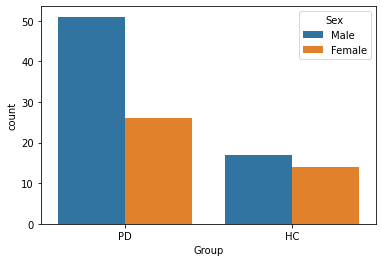

In [29]:
import seaborn as sns
sns.countplot(x='Group', data=df_plot, hue='Sex')

##### Plotting the age distribution in each group for males and females seperately

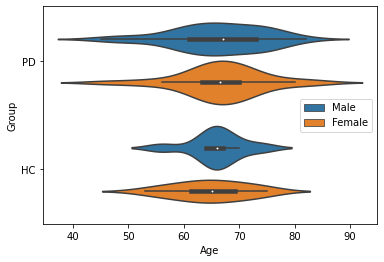

In [30]:
import matplotlib.pyplot as plt
sns.violinplot(x='Age', y='Group', data=df_plot, hue='Sex')
plt.legend(loc=5)

##### Plotting the education distribution in each group for males and females seperately

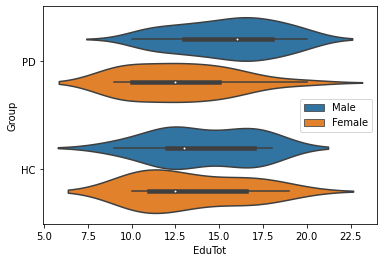

In [31]:
sns.violinplot(x='EduTot', y='Group', data=df_plot, hue='Sex')
plt.legend(loc=7)

In [32]:
# Re-making the Group column (independent variable) numerical again: 1 for PD and 0 for HC
if df['Group'][0] == 'PD' or df['Group'][0] == 'HC':
    temp = {'PD': 1, 'HC': 0}
    a = np.array(df['Group'].map(temp))
    df['Group'] = a
df = df.reset_index(drop=True)
df

,ID,Group,Age,EduTot,Sex
0,CG001,1,67.0,18.0,0.0
1,CG002,1,70.0,10.0,1.0
2,CG005,1,62.0,11.0,0.0
3,CG006,1,59.0,11.0,0.0
4,CG007,1,59.0,11.0,0.0
...,...,...,...,...,...
103,CT095,0,67.0,17.0,0.0
104,CT096,0,67.0,18.0,0.0
105,CT097,0,65.0,12.0,0.0
106,CT098,0,71.0,17.0,1.0


In [33]:
# Concatenating the PLV features of the two groups
PLV_features = np.concatenate((PLV_features_PD,PLV_features_HC))
PLV_features

array([[[0.32997193, 0.42783391, 0.62979373, 0.58073974, 0.4002366 ],
        [0.34210836, 0.43974943, 0.58605569, 0.56193802, 0.39117798],
        [0.33832064, 0.48766772, 0.62603875, 0.59220094, 0.45238867],
        ...,
        [0.34182978, 0.43947006, 0.62067603, 0.52713647, 0.3894767 ],
        [0.43164245, 0.59913589, 0.67193398, 0.56180696, 0.42526811],
        [0.43404439, 0.54160839, 0.63728012, 0.5431666 , 0.40770713]],

       [[0.52325355, 0.50777202, 0.73395419, 0.65099533, 0.46469288],
        [0.31696274, 0.42023922, 0.68683724, 0.60264033, 0.41085254],
        [0.35124945, 0.47100587, 0.68948466, 0.60253012, 0.41363196],
        ...,
        [0.56070653, 0.59679142, 0.73911717, 0.72523379, 0.57514264],
        [0.36651397, 0.49566642, 0.61214794, 0.55644732, 0.44625266],
        [0.63621618, 0.71009644, 0.84732755, 0.82201002, 0.7183151 ]],

       [[0.63615013, 0.57090077, 0.72647343, 0.57820901, 0.4451717 ],
        [0.51860739, 0.49377212, 0.7097373 , 0.62216003, 0.5

In [34]:
# Extracting PLV features by bands for all of the subjects
band1_PLV_features = PLV_features[:,:,0]
band2_PLV_features = PLV_features[:,:,1]
band3_PLV_features = PLV_features[:,:,2]
band4_PLV_features = PLV_features[:,:,3]
band5_PLV_features = PLV_features[:,:,4]

band1_PLV_features.shape

(108, 21945)

In [35]:
df['Delta Band PLV']  = band1_PLV_features.tolist()
df['Theta Band PLV']  = band2_PLV_features.tolist()
df['Alpha-1 Band PLV']  = band3_PLV_features.tolist()
df['Alpha-2 Band PLV']  = band4_PLV_features.tolist()
df['Beta Band PLV']  = band5_PLV_features.tolist()

df

,ID,Group,Age,EduTot,Sex,Delta Band PLV,Theta Band PLV,Alpha-1 Band PLV,Alpha-2 Band PLV,Beta Band PLV
0,CG001,1,67.0,18.0,0.0,"[0.3299719341123857, 0.3421083623846939, 0.338...","[0.42783390861769055, 0.43974943039037623, 0.4...","[0.6297937282246409, 0.5860556883800777, 0.626...","[0.5807397402041623, 0.5619380172392363, 0.592...","[0.40023660331289274, 0.39117798378274804, 0.4..."
1,CG002,1,70.0,10.0,1.0,"[0.5232535547529593, 0.3169627430507698, 0.351...","[0.5077720158552852, 0.420239215261448, 0.4710...","[0.7339541940937256, 0.686837237333406, 0.6894...","[0.6509953299886201, 0.602640331435429, 0.6025...","[0.4646928750179029, 0.410852543594747, 0.4136..."
2,CG005,1,62.0,11.0,0.0,"[0.6361501266679429, 0.5186073906512177, 0.558...","[0.5709007731123399, 0.493772124076352, 0.5310...","[0.7264734332210528, 0.7097373049127511, 0.663...","[0.5782090129570738, 0.6221600321468722, 0.536...","[0.4451717037875112, 0.5188650604689992, 0.439..."
3,CG006,1,59.0,11.0,0.0,"[0.3403584406729545, 0.3418135772917265, 0.313...","[0.4262743722645898, 0.43705285373364355, 0.46...","[0.5988926102847753, 0.6525952495161779, 0.643...","[0.531048673711687, 0.5487255289286241, 0.5850...","[0.4096211090620683, 0.4726363681806558, 0.488..."
4,CG007,1,59.0,11.0,0.0,"[0.4595195028925641, 0.4370547199294692, 0.400...","[0.54403770511117, 0.4940320705510591, 0.47178...","[0.5987911331542768, 0.617755301386667, 0.5735...","[0.579825193259185, 0.6023892907542882, 0.5656...","[0.43807249620905014, 0.4618428712858114, 0.43..."
...,...,...,...,...,...,...,...,...,...,...
103,CT095,0,67.0,17.0,0.0,"[0.40124677796522884, 0.35873119478348964, 0.3...","[0.5625786544817638, 0.4762571131643108, 0.475...","[0.7280394240181173, 0.6079151051400026, 0.619...","[0.6297983269043267, 0.6164896216244006, 0.593...","[0.4560688022370609, 0.4346896382751522, 0.439..."
104,CT096,0,67.0,18.0,0.0,"[0.5765239241793428, 0.5037303169970976, 0.458...","[0.553411456126455, 0.5315950366231612, 0.4941...","[0.7239515791727588, 0.6706700364255954, 0.689...","[0.5541502220713473, 0.5780218062127834, 0.515...","[0.40977074667411917, 0.4329740748039863, 0.40..."
105,CT097,0,65.0,12.0,0.0,"[0.3431558718190335, 0.4429635415770021, 0.326...","[0.44891866884997617, 0.534800977678432, 0.446...","[0.6386568829624572, 0.7189273308959878, 0.638...","[0.5544547886666213, 0.7097535936714793, 0.555...","[0.4106965590186487, 0.5323963692230238, 0.407..."
106,CT098,0,71.0,17.0,1.0,"[0.49059352552559693, 0.3630125473432296, 0.35...","[0.5904037376581118, 0.44856504909522465, 0.45...","[0.6809239507573247, 0.5717326516743754, 0.569...","[0.6823224279983672, 0.6043584071157723, 0.583...","[0.5675166389697893, 0.45050736467407115, 0.44..."


##### Seperating the features and the label

In [36]:
# Defining the features X and the label y (independent variable) 
X = df.iloc[:,2:]
y = df.iloc[:,1]
X,y

(      Age  EduTot  Sex                                     Delta Band PLV  \
 0    67.0    18.0  0.0  [0.3299719341123857, 0.3421083623846939, 0.338...   
 1    70.0    10.0  1.0  [0.5232535547529593, 0.3169627430507698, 0.351...   
 2    62.0    11.0  0.0  [0.6361501266679429, 0.5186073906512177, 0.558...   
 3    59.0    11.0  0.0  [0.3403584406729545, 0.3418135772917265, 0.313...   
 4    59.0    11.0  0.0  [0.4595195028925641, 0.4370547199294692, 0.400...   
 ..    ...     ...  ...                                                ...   
 103  67.0    17.0  0.0  [0.40124677796522884, 0.35873119478348964, 0.3...   
 104  67.0    18.0  0.0  [0.5765239241793428, 0.5037303169970976, 0.458...   
 105  65.0    12.0  0.0  [0.3431558718190335, 0.4429635415770021, 0.326...   
 106  71.0    17.0  1.0  [0.49059352552559693, 0.3630125473432296, 0.35...   
 107  66.0    10.0  1.0  [0.424549791513331, 0.3374003949617814, 0.3464...   
 
                                         Theta Band PLV  \
 0 

##### Plotting the distributions of the conenctivity features in each group for the five frequency bands

In [37]:
brain_regions = 210
p_thresh = 0.5
X_plot = X.copy(deep = True)
r_mat_X, pos_mask_X, neg_mask_X, pos_NS_X, neg_NS_X, mix_NS_X = ccf_train(X_plot, y, brain_regions, p_thresh)
X_plot.drop(columns=X_plot.columns[-5:], axis=1,  inplace=True)

X_plot.loc[:, 'Delta Band (pos)'] = pos_NS_X.band1
X_plot.loc[:, 'Theta Band (pos)'] = pos_NS_X.band2
X_plot.loc[:, 'Alpha-1 Band (pos)'] = pos_NS_X.band3
X_plot.loc[:, 'Alpha-2 Band (pos)'] = pos_NS_X.band4
X_plot.loc[:, 'Beta Band (pos)'] = pos_NS_X.band5

X_plot.loc[:, 'Delta Band (neg)'] = neg_NS_X.band1
X_plot.loc[:, 'Theta Band (neg)'] = neg_NS_X.band2
X_plot.loc[:, 'Alpha-1 Band (neg)'] = neg_NS_X.band3
X_plot.loc[:, 'Alpha-2 Band (neg)'] = neg_NS_X.band4
X_plot.loc[:, 'Beta Band (neg)'] = neg_NS_X.band5

X_plot.loc[:, 'Delta Band (mix)'] = mix_NS_X.band1
X_plot.loc[:, 'Theta Band (mix)'] = mix_NS_X.band2
X_plot.loc[:, 'Alpha-1 Band (mix)'] = mix_NS_X.band3
X_plot.loc[:, 'Alpha-2 Band (mix)'] = mix_NS_X.band4
X_plot.loc[:, 'Beta Band (mix)'] = mix_NS_X.band5

y_plot = y.copy(deep=True)
# Making the Group column (independent variable) numerical: 1 for PD and 0 for HC
if y_plot[0] == 0 or y_plot[0] == 1:
    temp = {1: 'PD', 0: 'HC'}
    y_plot = np.array(y_plot.map(temp))

X_plot.loc[:, 'Group'] = y_plot
X_plot

,Age,EduTot,Sex,Delta Band (pos),Theta Band (pos),Alpha-1 Band (pos),Alpha-2 Band (pos),Beta Band (pos),Delta Band (neg),Theta Band (neg),Alpha-1 Band (neg),Alpha-2 Band (neg),Beta Band (neg),Delta Band (mix),Theta Band (mix),Alpha-1 Band (mix),Alpha-2 Band (mix),Beta Band (mix),Group
0,67.0,18.0,0.0,0.433536,0.553416,0.766151,0.724888,0.501720,0.371952,0.481768,0.655984,0.662137,0.430167,0.061583,0.071648,0.110167,0.062750,0.071553,PD
1,70.0,10.0,1.0,0.470726,0.540908,0.768124,0.726329,0.571208,0.422154,0.521175,0.684834,0.692734,0.477331,0.048572,0.019733,0.083290,0.033595,0.093877,PD
2,62.0,11.0,0.0,0.522189,0.531945,0.750809,0.701617,0.485145,0.413923,0.479251,0.655214,0.664325,0.429387,0.108266,0.052693,0.095595,0.037292,0.055758,PD
3,59.0,11.0,0.0,0.391333,0.487905,0.715286,0.679927,0.506812,0.369236,0.500904,0.649102,0.651890,0.451965,0.022096,-0.012999,0.066184,0.028037,0.054846,PD
4,59.0,11.0,0.0,0.439112,0.529365,0.678998,0.629230,0.486228,0.368837,0.508126,0.591999,0.598805,0.427269,0.070275,0.021240,0.086999,0.030425,0.058959,PD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,67.0,17.0,0.0,0.398308,0.501930,0.706379,0.688572,0.504379,0.362746,0.492814,0.626888,0.626655,0.456722,0.035563,0.009116,0.079491,0.061916,0.047656,HC
104,67.0,18.0,0.0,0.440523,0.501256,0.732706,0.713658,0.434590,0.378686,0.495179,0.668869,0.670911,0.424373,0.061837,0.006077,0.063838,0.042747,0.010216,HC
105,65.0,12.0,0.0,0.426278,0.524693,0.727113,0.685004,0.480295,0.402066,0.497809,0.652328,0.658811,0.460468,0.024212,0.026884,0.074785,0.026193,0.019827,HC
106,71.0,17.0,1.0,0.489256,0.540319,0.706593,0.668360,0.531433,0.442670,0.534059,0.631473,0.636267,0.509311,0.046586,0.006260,0.075121,0.032093,0.022122,HC


Positive tail:

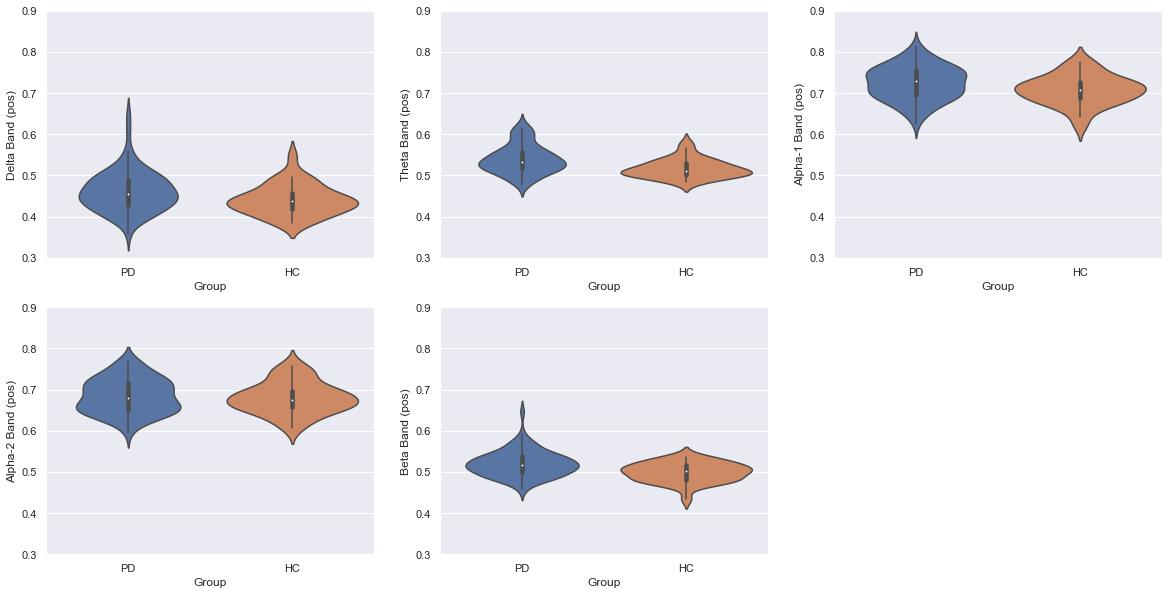

In [38]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes[0,0].set(ylim=(0.3, 0.9))
axes[0,1].set(ylim=(0.3, 0.9))
axes[0,2].set(ylim=(0.3, 0.9))
axes[1,0].set(ylim=(0.3, 0.9))
axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
sns.violinplot(x="Group", y="Delta Band (pos)", data=X_plot, ax=axes[0,0])
sns.violinplot(x="Group", y="Theta Band (pos)", data=X_plot, ax=axes[0,1])
sns.violinplot(x="Group", y="Alpha-1 Band (pos)", data=X_plot, ax=axes[0,2])
sns.violinplot(x="Group", y="Alpha-2 Band (pos)", data=X_plot, ax=axes[1,0])
sns.violinplot(x="Group", y="Beta Band (pos)", data=X_plot, ax=axes[1,1])

fig.delaxes(axes[1,2])

Negative tail:

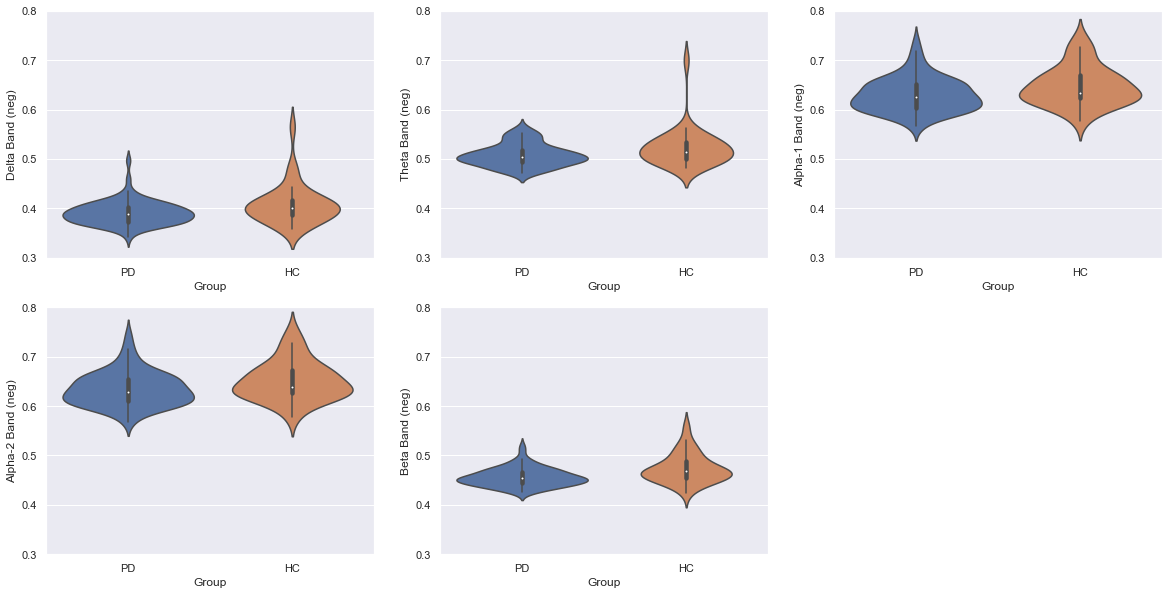

In [39]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes[0,0].set(ylim=(0.3, 0.8))
axes[0,1].set(ylim=(0.3, 0.8))
axes[0,2].set(ylim=(0.3, 0.8))
axes[1,0].set(ylim=(0.3, 0.8))
axes[1,1].set(ylim=(0.3, 0.8))
#create boxplot in each subplot
sns.violinplot(x="Group", y="Delta Band (neg)", data=X_plot, ax=axes[0,0])
sns.violinplot(x="Group", y="Theta Band (neg)", data=X_plot, ax=axes[0,1])
sns.violinplot(x="Group", y="Alpha-1 Band (neg)", data=X_plot, ax=axes[0,2])
sns.violinplot(x="Group", y="Alpha-2 Band (neg)", data=X_plot, ax=axes[1,0])
sns.violinplot(x="Group", y="Beta Band (neg)", data=X_plot, ax=axes[1,1])
#axes[1,1].text(1.2, 0.70,'*', fontsize=30)

fig.delaxes(axes[1,2])

Mixed tail:

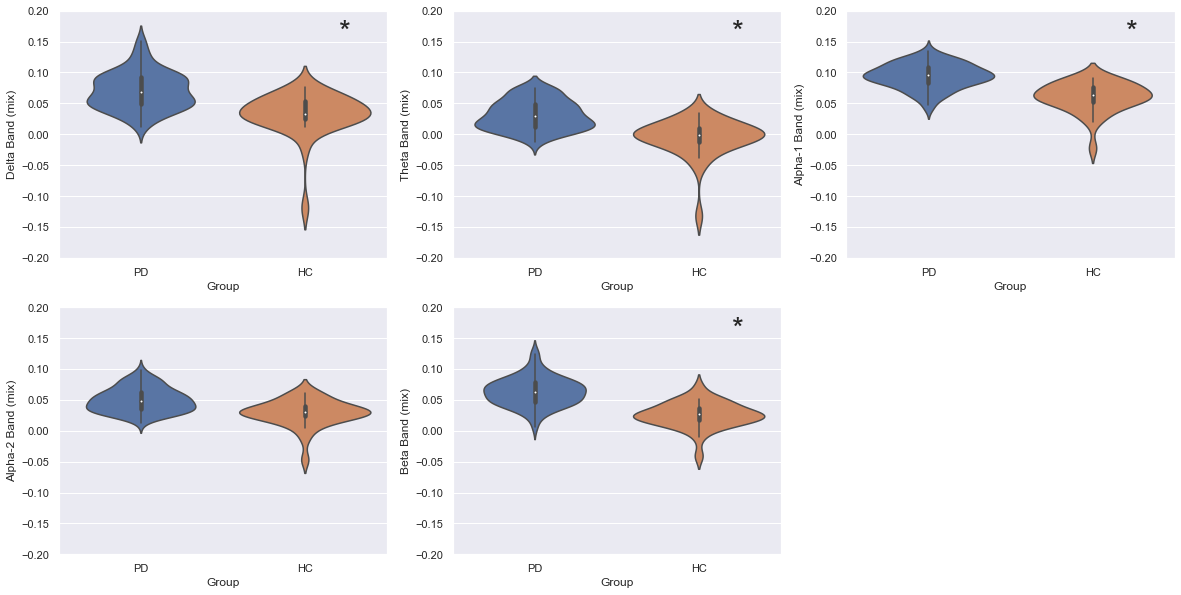

In [40]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes[0,0].set(ylim=(-0.2, 0.2))
axes[0,1].set(ylim=(-0.2, 0.2))
axes[0,2].set(ylim=(-0.2, 0.2))
axes[1,0].set(ylim=(-0.2, 0.2))
axes[1,1].set(ylim=(-0.2, 0.2))
#axes[0,1].text(0.85, 0.85,'*', fontsize=20) #add text
#create boxplot in each subplot
sns.violinplot(x="Group", y="Delta Band (mix)", data=X_plot, ax=axes[0,0])
axes[0,0].text(1.2, 0.15,'*', fontsize=30)
sns.violinplot(x="Group", y="Theta Band (mix)", data=X_plot, ax=axes[0,1])
axes[0,1].text(1.2, 0.15,'*', fontsize=30)
sns.violinplot(x="Group", y="Alpha-1 Band (mix)", data=X_plot, ax=axes[0,2])
axes[0,2].text(1.2, 0.15,'*', fontsize=30)
sns.violinplot(x="Group", y="Alpha-2 Band (mix)", data=X_plot, ax=axes[1,0])
#axes[1,0].text(1.2, 0.15,'*', fontsize=30)
sns.violinplot(x="Group", y="Beta Band (mix)", data=X_plot, ax=axes[1,1])
axes[1,1].text(1.2, 0.15,'*', fontsize=30)

fig.delaxes(axes[1,2])

In [41]:
a = stats.pointbiserialr(X_plot["Delta Band (mix)"],y)
b = stats.pointbiserialr(X_plot["Theta Band (mix)"],y)
c = stats.pointbiserialr(X_plot["Alpha-1 Band (mix)"],y)
d = stats.pointbiserialr(X_plot["Alpha-2 Band (mix)"],y)
e = stats.pointbiserialr(X_plot["Beta Band (mix)"],y)

a, b, c, d, e

print('To test their significance, we compare the p-values to the number ' + str(0.05/21945))

To test their significance, we compare the p-values to the number 2.2784233310549103e-06


## Calculating the consensus set of connectivity features using the LOOCV

In [42]:
import time
from sklearn.model_selection import LeaveOneOut

start_time = time.time()
loo = LeaveOneOut()
brain_regions = 210
threshold = 0.05
nb = 5
list_of_pos_masks_band1_train, list_of_pos_masks_band2_train, list_of_pos_masks_band3_train, list_of_pos_masks_band4_train, list_of_pos_masks_band5_train = [], [], [], [], []
list_of_neg_masks_band1_train, list_of_neg_masks_band2_train, list_of_neg_masks_band3_train, list_of_neg_masks_band4_train, list_of_neg_masks_band5_train = [], [], [], [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Getting the Connectivity matrices of each band for the training dataset 
    PLV_train = get_PLV_by_bands(X_train, brain_regions)
    conn_matrices_train = get_conn_matrices_by_bands(PLV_train, brain_regions)
    
    # Dropping the list of features from the dataframe since we don't need them anymore
    X_train.drop(columns=X_train.columns[-nb:], axis=1,  inplace=True)
    
    # Calculating r and p matrices for the training data
    r_mat_train, p_mat_train = get_r_and_p_mats_by_bands(X_train, y_train, conn_matrices_train, brain_regions)
    
    # Calculating positive and negative masks masks for the training data
    pos_masks_train = get_pos_masks_by_bands(threshold, r_mat_train, p_mat_train)
    neg_mask_train = get_neg_masks_by_bands(threshold, r_mat_train, p_mat_train)
    
    # Extracting the upper triangular part (21495 features)
    #pos_mask_band1_train_1D, pos_mask_band2_train_1D, pos_mask_band3_train_1D, pos_mask_band4_train_1D, pos_mask_band5_train_1D = pos_mask_band1_train[np.triu_indices(brain_regions, k=1)], pos_mask_band2_train[np.triu_indices(brain_regions, k=1)], pos_mask_band3_train[np.triu_indices(brain_regions, k=1)], pos_mask_band4_train[np.triu_indices(brain_regions, k=1)], pos_mask_band5_train[np.triu_indices(brain_regions, k=1)]
    #neg_mask_band1_train_1D, neg_mask_band2_train_1D, neg_mask_band3_train_1D, neg_mask_band4_train_1D, neg_mask_band5_train_1D = neg_mask_band1_train[np.triu_indices(brain_regions, k=1)], neg_mask_band2_train[np.triu_indices(brain_regions, k=1)], neg_mask_band3_train[np.triu_indices(brain_regions, k=1)], neg_mask_band4_train[np.triu_indices(brain_regions, k=1)], neg_mask_band5_train[np.triu_indices(brain_regions, k=1)]
    
    # Making lists of positive masks in each band (to store them for later use when computing consensus)
    list_of_pos_masks_band1_train.append(pos_masks_train.band1)
    list_of_pos_masks_band2_train.append(pos_masks_train.band2)
    list_of_pos_masks_band3_train.append(pos_masks_train.band3)
    list_of_pos_masks_band4_train.append(pos_masks_train.band4)
    list_of_pos_masks_band5_train.append(pos_masks_train.band5)
    
    # Making lists of negative masks in each band (to store them for later use when computing consensus)
    list_of_neg_masks_band1_train.append(neg_mask_train.band1)
    list_of_neg_masks_band2_train.append(neg_mask_train.band2)
    list_of_neg_masks_band3_train.append(neg_mask_train.band3)
    list_of_neg_masks_band4_train.append(neg_mask_train.band4)
    list_of_neg_masks_band5_train.append(neg_mask_train.band5)
    
print("--- %f minutes ---" % (float(time.time() - start_time)/60))

C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


--- 44.935649 minutes ---


##### Plotting one of the training connectivity matrices (with diagonals set to 0)

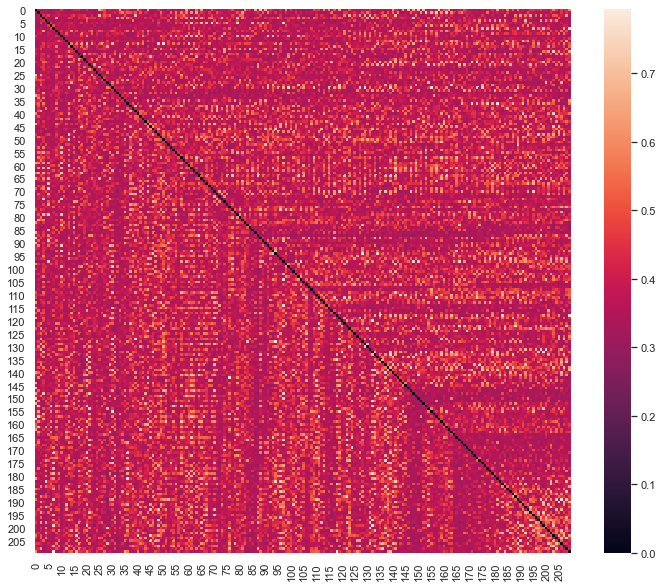

In [49]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.color_palette("hls", 8)
sns.heatmap(conn_matrices_train.band1[0], ax=ax)
plt.show()

##### Consensus Functional Connectivity

In [50]:
# Calculating the positive and negative consensus sets for each band
consensus_pos_band1, consensus_pos_band2, consensus_pos_band3, consensus_pos_band4, consensus_pos_band5 = np.ones_like(list_of_pos_masks_band1_train[0]), np.ones_like(list_of_pos_masks_band2_train[0]), np.ones_like(list_of_pos_masks_band3_train[0]), np.ones_like(list_of_pos_masks_band4_train[0]), np.ones_like(list_of_pos_masks_band5_train[0])
consensus_neg_band1, consensus_neg_band2, consensus_neg_band3, consensus_neg_band4, consensus_neg_band5 = np.ones_like(list_of_neg_masks_band1_train[0]), np.ones_like(list_of_neg_masks_band2_train[0]), np.ones_like(list_of_neg_masks_band3_train[0]), np.ones_like(list_of_neg_masks_band4_train[0]), np.ones_like(list_of_neg_masks_band5_train[0])

for i in range(len(list_of_pos_masks_band1_train)):
    
    consensus_pos_band1 = np.multiply(consensus_pos_band1,list_of_pos_masks_band1_train[i])
    consensus_pos_band2 = np.multiply(consensus_pos_band2,list_of_pos_masks_band2_train[i])
    consensus_pos_band3 = np.multiply(consensus_pos_band3,list_of_pos_masks_band3_train[i])
    consensus_pos_band4 = np.multiply(consensus_pos_band4,list_of_pos_masks_band4_train[i])
    consensus_pos_band5 = np.multiply(consensus_pos_band5,list_of_pos_masks_band5_train[i])
    
    consensus_neg_band1 = np.multiply(consensus_neg_band1,list_of_neg_masks_band1_train[i])
    consensus_neg_band2 = np.multiply(consensus_neg_band2,list_of_neg_masks_band2_train[i])
    consensus_neg_band3 = np.multiply(consensus_neg_band3,list_of_neg_masks_band3_train[i])
    consensus_neg_band4 = np.multiply(consensus_neg_band4,list_of_neg_masks_band4_train[i])
    consensus_neg_band5 = np.multiply(consensus_neg_band5,list_of_neg_masks_band5_train[i])

##### Number of features left in each band for the positive tail

In [51]:
np.count_nonzero(consensus_pos_band1 == 1)/2, np.count_nonzero(consensus_pos_band2 == 1)/2, np.count_nonzero(consensus_pos_band3 == 1)/2, np.count_nonzero(consensus_pos_band4 == 1)/2, np.count_nonzero(consensus_pos_band5 == 1)/2

(92.0, 1981.0, 3.0, 58.0, 640.0)

##### Number of features left in each band for the negative tail

In [52]:
np.count_nonzero(consensus_neg_band1 == 1)/2, np.count_nonzero(consensus_neg_band2 == 1)/2, np.count_nonzero(consensus_neg_band3 == 1)/2, np.count_nonzero(consensus_neg_band4 == 1)/2, np.count_nonzero(consensus_neg_band5 == 1)/2

(130.0, 7.0, 1008.0, 2027.0, 1006.0)

##### Plotting the consensus connectivity masks for the five frequency bands in the case of positive tail

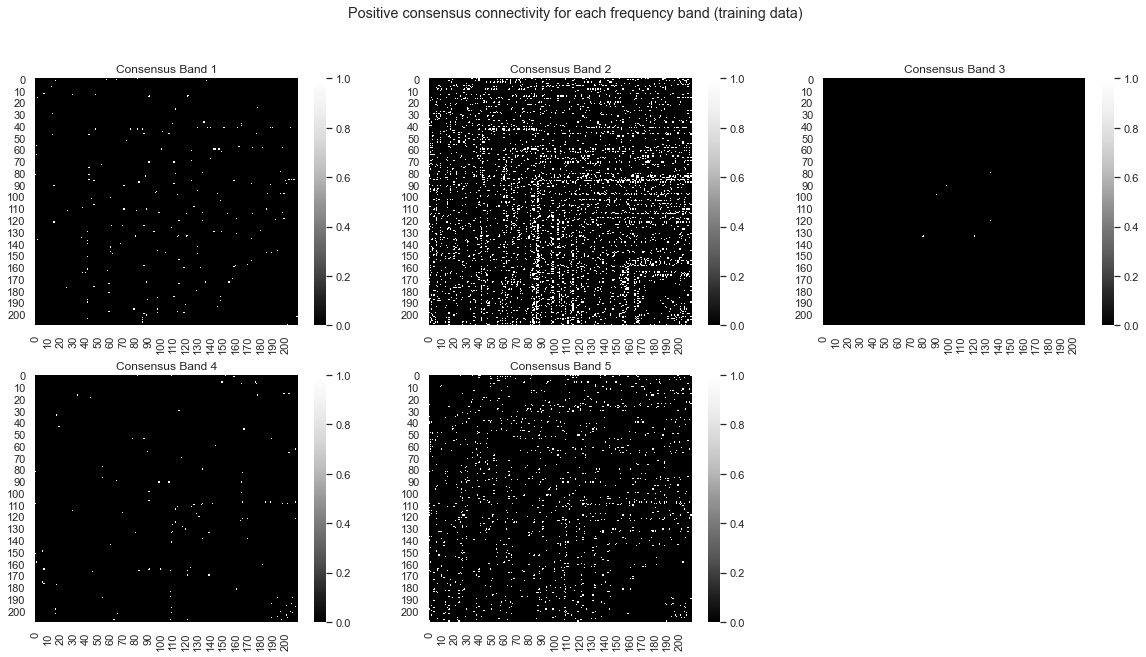

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(20, 10))         # Sample figsize in inches

fig.suptitle('Positive consensus connectivity for each frequency band (training data)')

axes[0, 0].set_title("Consensus Band 1")
sns.heatmap(consensus_pos_band1, ax=axes[0, 0], cmap='Greys_r')
axes[0, 1].set_title("Consensus Band 2")
sns.heatmap(consensus_pos_band2, ax=axes[0, 1], cmap='Greys_r')
axes[0, 2].set_title("Consensus Band 3")
sns.heatmap(consensus_pos_band3, ax=axes[0, 2], cmap='Greys_r')
axes[1, 0].set_title("Consensus Band 4")
sns.heatmap(consensus_pos_band4, ax=axes[1, 0], cmap='Greys_r')
axes[1, 1].set_title("Consensus Band 5")
sns.heatmap(consensus_pos_band5, ax=axes[1, 1], cmap='Greys_r')

fig.delaxes(axes[1,2])

plt.show()

##### Plotting the consensus connectivity masks for the five frequency bands in the case of negative tail

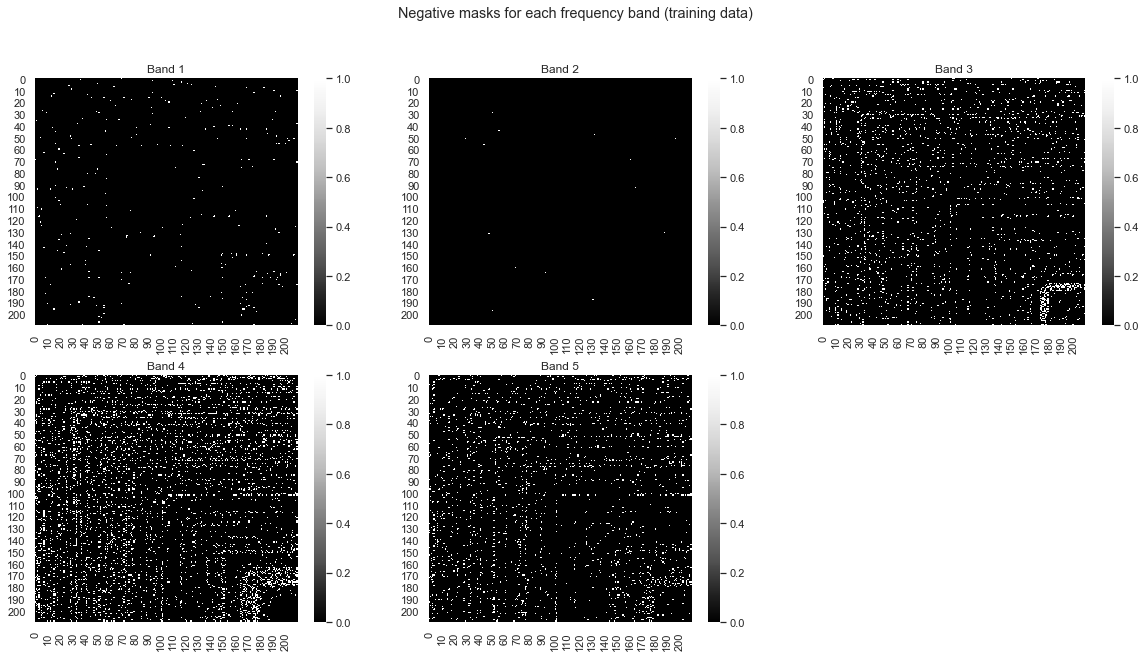

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))         # Sample figsize in inches

fig.suptitle('Negative masks for each frequency band (training data)')

axes[0, 0].set_title("Band 1")
sns.heatmap(consensus_neg_band1, ax=axes[0, 0], cmap='Greys_r')
axes[0, 1].set_title("Band 2")
sns.heatmap(consensus_neg_band2, ax=axes[0, 1], cmap='Greys_r')
axes[0, 2].set_title("Band 3")
sns.heatmap(consensus_neg_band3, ax=axes[0, 2], cmap='Greys_r')
axes[1, 0].set_title("Band 4")
sns.heatmap(consensus_neg_band4, ax=axes[1, 0], cmap='Greys_r')
axes[1, 1].set_title("Band 5")
sns.heatmap(consensus_neg_band5, ax=axes[1, 1], cmap='Greys_r')

fig.delaxes(axes[1,2])

plt.show()

## Training the models with PLV Features & Demographics
<a id="training"></a>

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from mlxtend.data import mnist_data
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# The training data
X_train = df.iloc[:,2:]
y_train = df.iloc[:,1]
brain_regions = 210
PLV_train = get_PLV_by_bands(X_train, brain_regions)

# Extracting the connectivity matrices of the training set
conn_matrices_train = get_conn_matrices_by_bands(PLV_train, brain_regions)


# Initializing Classifiers
clf0 = DummyClassifier()
clf1 = LogisticRegression(random_state=1)
clf2 = ExtraTreesClassifier(random_state=1)
clf3 = DecisionTreeClassifier(random_state=1)
clf4 = SVC(probability=True, random_state=1)
clf5 = RandomForestClassifier(random_state=1)

# Building the pipelines
pipe0 = Pipeline([('std', StandardScaler()),
                  ('clf0', clf0)])

pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', clf1)])

pipe4 = Pipeline([('std', StandardScaler()),
                  ('clf4', clf4)])


# Setting up the parameter grids

# Dummy
param_grid0 = {'clf0__strategy': ['stratified','most_frequent','uniform']}

# Logistic Regression
param_grid1 = [{'clf1__penalty': ['none', 'l2'],
                'clf1__solver': ['newton-cg', 'lbfgs'], 
                #'clf1__C': np.power(10., np.arange(-4, 4))
                'clf1__C': [0.001, 0.01, 0.1, 0.5, 0.8, 1]}]

# Extra Trees
#param_grid2 = [{'clf2__n_estimators': list(range(10, 100, 10)),
#                'clf2__criterion': ['gini', 'entropy'],
#                #'clf2__min_samples_leaf': list(range(1, 50)),
#                'clf2__max_depth': list(range(2, 20)) + [None],
#                #'clf2__max_features': ['auto', 'sqrt'],
#                #'clf2__bootstrap': [True, False]
#               }]
param_grid2 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

# Decision Tree
#param_grid3 = [{'clf3__criterion': ['gini', 'entropy'],
#                #'clf3__min_samples_leaf': list(range(1, 50)),
#                'clf3__max_depth': list(range(2, 20)) + [None],
#                #'clf3__max_features': ['auto', 'sqrt']
#               }]
param_grid3 = [{'max_depth': list(range(1, 10)) + [None],
                'criterion': ['gini', 'entropy']}]

# SVM
param_grid4 = [{'clf4__kernel': ['rbf'],
                #'clf4__C': np.power(10., np.arange(-4, 4)),
                'clf4__C': [0.001, 0.01, 0.1, 0.5, 0.8, 1],
                #'clf4__gamma': np.power(10., np.arange(-5, 0))
                'clf4__gamma': [0.001, 0.01, 0.1, 0.5, 0.8, 1]},
               {'clf4__kernel': ['linear'],
                #'clf4__C': np.power(10., np.arange(-4, 4))
                'clf4__C': [0.001, 0.01, 0.1, 0.5, 0.8, 1]}]

# Random Forest                
#param_grid5 = [{'clf5__n_estimators': list(range(10, 100, 10)),
#                'clf5__criterion': ['gini', 'entropy'],
#                #'clf5__min_samples_leaf': list(range(1, 50)),
#                'clf5__max_depth': list(range(2, 20)) + [None],
#                #'clf5__max_features': ['auto', 'sqrt'],
#                #'clf5__bootstrap': [True, False]
#               }]
param_grid5 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

# Setting up multiple GridSearchCV objects, 1 for each algorithm
# (Setting up the inner loop)
gridcvs = {}

inner_cv = StratifiedKFold(n_splits=2,shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid0, param_grid1, param_grid2,
                             param_grid3, param_grid4, param_grid5),
                            (pipe0, pipe1, clf2, clf3, pipe4, clf5),
                            ('Dummy','LogRegression', 'ExtraTrees', 'DTree', 'SVM', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True,
                       error_score='raise')
    gridcvs[name] = gcv

- Next, we define the outer loop
- The training folds from the outer loop will be used in the inner loop for model tuning
- The inner loop selects the best hyperparameter setting
- This best hyperparameter setting can be evaluated on both the avg. over the inner test folds and the 1 corresponding test fold of the outer loop

## Positive NS features only:
<a id="PLV_dem_pos"></a>

In [63]:
brain_regions = 210
p_thresh = 0.05

outer_scores_pos = {}
outer_roc_scores_pos = {}
specificity_pos = {}
sensitivity_pos = {}
precision_pos = {}
f1_pos = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores_pos['{}'.format(name)] = []
    outer_roc_scores_pos['{}'.format(name)] = []
    specificity_pos['{}'.format(name)] = []
    sensitivity_pos['{}'.format(name)] = []
    precision_pos['{}'.format(name)] = []
    f1_pos['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        X_train_pos = X_train.copy(deep = True)
        pos_rmat_train, pos_mask_train, neg_mask_train, pos_NS_train, neg_NS_train, mix_NS_train = ccf_train(X_train, y_train, brain_regions, p_thresh)
        X_train_pos.drop(columns=X_train_pos.columns[-5:], axis=1,  inplace=True)
        X_train_pos.loc[:, 'PLV Pos NS band 1'] = pos_NS_train.band1
        X_train_pos.loc[:, 'PLV Pos NS band 2'] = pos_NS_train.band2
        X_train_pos.loc[:, 'PLV Pos NS band 3'] = pos_NS_train.band3
        X_train_pos.loc[:, 'PLV Pos NS band 4'] = pos_NS_train.band4
        X_train_pos.loc[:, 'PLV Pos NS band 5'] = pos_NS_train.band5
        
        gridcvs[name].fit(X_train_pos.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_cv = X_train.iloc[valid_idx]
        y_test_cv = y_train.iloc[valid_idx]
        
        X_test_pos = X_test_cv.copy(deep = True)
        pos_NS_test, neg_NS_test, mix_NS_test = ccf_test(X_test_cv, y_test_cv, brain_regions, pos_mask_train, neg_mask_train)
        X_test_pos.drop(columns=X_test_pos.columns[-5:], axis=1,  inplace=True)
        X_test_pos.loc[:, 'PLV Pos NS band 1'] = pos_NS_test.band1
        X_test_pos.loc[:, 'PLV Pos NS band 2'] = pos_NS_test.band2
        X_test_pos.loc[:, 'PLV Pos NS band 3'] = pos_NS_test.band3
        X_test_pos.loc[:, 'PLV Pos NS band 4'] = pos_NS_test.band4
        X_test_pos.loc[:, 'PLV Pos NS band 5'] = pos_NS_test.band5
        
        outer_roc_scores_pos['{}'.format(name)].append(roc_auc_score(y_test_cv, gridcvs[name].best_estimator_.predict_proba(X_test_pos)[:,1]))
        outer_scores_pos['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_pos, y_test_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_pos)).ravel()
        sensitivity_pos['{}'.format(name)].append(tp / (tp+fn))
        specificity_pos['{}'.format(name)].append(tn / (tn+fp))
        precision_pos['{}'.format(name)].append(tp / (tp+fp))
        f1_pos['{}'.format(name)].append(2*(sensitivity_pos['{}'.format(name)][-1] * precision_pos['{}'.format(name)][-1])/(sensitivity_pos['{}'.format(name)][-1] + precision_pos['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores_pos['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (outer_roc_scores_pos['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (specificity_pos['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (sensitivity_pos['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (precision_pos['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (f1_pos['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_pos)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores_pos['{}'.format(name)]) * 100, np.std(outer_scores_pos['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(outer_roc_scores_pos['{}'.format(name)]), np.std(outer_roc_scores_pos['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(specificity_pos['{}'.format(name)]), np.std(specificity_pos['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(sensitivity_pos['{}'.format(name)]), np.std(sensitivity_pos['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(precision_pos['{}'.format(name)]), np.std(precision_pos['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(f1_pos['{}'.format(name)]), np.std(f1_pos['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 68.60%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.66
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 0.81
        Precision (on outer test fold) 0.81
        F1-Score (on outer test fold) 0.81
        Confusion matrix: 
[[ 3  3]
 [ 3 13]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'criterion': 'entropy', 'max_depth': 4}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 69.00%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.90
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.82
        F1-Score (on outer test fold) 0.87
        Confusion matrix: 
[[ 3  3]
 [ 1 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.57%
        Best parameters: {'n_estimators': 100}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.79
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fo

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 71.33%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.71
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 1  5]
 [ 1 14]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 77.06%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.81
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.81
        F1-Score (on outer test fold) 0.84
        Confusion matrix: 
[[ 3  3]
 [ 2 13]]

    Outer Loop:
        ACC 71.34% +/- 6.49
        ROC-AUC 0.80 +/- 0.06
        Specificity 0.35 +/- 0.11
        Sensitivity 0.86 +/- 0.10
        Precision 0.77 +/- 0.04
        F1-Score 0.81 +/- 0.06
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25

In [62]:
X_train

,Age,EduTot,Sex,Delta Band PLV,Theta Band PLV,Alpha-1 Band PLV,Alpha-2 Band PLV,Beta Band PLV
0,67.0,18.0,0.0,"[0.3299719341123857, 0.3421083623846939, 0.338...","[0.42783390861769055, 0.43974943039037623, 0.4...","[0.6297937282246409, 0.5860556883800777, 0.626...","[0.5807397402041623, 0.5619380172392363, 0.592...","[0.40023660331289274, 0.39117798378274804, 0.4..."
1,70.0,10.0,1.0,"[0.5232535547529593, 0.3169627430507698, 0.351...","[0.5077720158552852, 0.420239215261448, 0.4710...","[0.7339541940937256, 0.686837237333406, 0.6894...","[0.6509953299886201, 0.602640331435429, 0.6025...","[0.4646928750179029, 0.410852543594747, 0.4136..."
2,62.0,11.0,0.0,"[0.6361501266679429, 0.5186073906512177, 0.558...","[0.5709007731123399, 0.493772124076352, 0.5310...","[0.7264734332210528, 0.7097373049127511, 0.663...","[0.5782090129570738, 0.6221600321468722, 0.536...","[0.4451717037875112, 0.5188650604689992, 0.439..."
3,59.0,11.0,0.0,"[0.3403584406729545, 0.3418135772917265, 0.313...","[0.4262743722645898, 0.43705285373364355, 0.46...","[0.5988926102847753, 0.6525952495161779, 0.643...","[0.531048673711687, 0.5487255289286241, 0.5850...","[0.4096211090620683, 0.4726363681806558, 0.488..."
4,59.0,11.0,0.0,"[0.4595195028925641, 0.4370547199294692, 0.400...","[0.54403770511117, 0.4940320705510591, 0.47178...","[0.5987911331542768, 0.617755301386667, 0.5735...","[0.579825193259185, 0.6023892907542882, 0.5656...","[0.43807249620905014, 0.4618428712858114, 0.43..."
...,...,...,...,...,...,...,...,...
103,67.0,17.0,0.0,"[0.40124677796522884, 0.35873119478348964, 0.3...","[0.5625786544817638, 0.4762571131643108, 0.475...","[0.7280394240181173, 0.6079151051400026, 0.619...","[0.6297983269043267, 0.6164896216244006, 0.593...","[0.4560688022370609, 0.4346896382751522, 0.439..."
104,67.0,18.0,0.0,"[0.5765239241793428, 0.5037303169970976, 0.458...","[0.553411456126455, 0.5315950366231612, 0.4941...","[0.7239515791727588, 0.6706700364255954, 0.689...","[0.5541502220713473, 0.5780218062127834, 0.515...","[0.40977074667411917, 0.4329740748039863, 0.40..."
105,65.0,12.0,0.0,"[0.3431558718190335, 0.4429635415770021, 0.326...","[0.44891866884997617, 0.534800977678432, 0.446...","[0.6386568829624572, 0.7189273308959878, 0.638...","[0.5544547886666213, 0.7097535936714793, 0.555...","[0.4106965590186487, 0.5323963692230238, 0.407..."
106,71.0,17.0,1.0,"[0.49059352552559693, 0.3630125473432296, 0.35...","[0.5904037376581118, 0.44856504909522465, 0.45...","[0.6809239507573247, 0.5717326516743754, 0.569...","[0.6823224279983672, 0.6043584071157723, 0.583...","[0.5675166389697893, 0.45050736467407115, 0.44..."


In [68]:
pos_mask_train.band1.shape

(210, 210)

## Negative NS features only:
<a id="PLV_dem_neg"></a>

In [69]:
brain_regions = 210
p_thresh = 0.05

outer_scores_neg = {}
outer_roc_scores_neg = {}
specificity_neg = {}
sensitivity_neg = {}
precision_neg = {}
f1_neg = {}
    
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores_neg['{}'.format(name)] = []
    outer_roc_scores_neg['{}'.format(name)] = []
    specificity_neg['{}'.format(name)] = []
    sensitivity_neg['{}'.format(name)] = []
    precision_neg['{}'.format(name)] = []
    f1_neg['{}'.format(name)] = []
    
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    #X_train_pos = X_train.copy(deep = True)
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        X_train_neg = X_train.copy(deep = True)
        rmat_train, pos_mask_train, neg_mask_train, pos_NS_train, neg_NS_train, mix_NS_train = ccf_train(X_train, y_train, brain_regions, p_thresh)
        X_train_neg.drop(columns=X_train_neg.columns[-5:], axis=1,  inplace=True)
        X_train_neg.loc[:, 'Negative NS band 1'] = neg_NS_train.band1
        X_train_neg.loc[:, 'Negative NS band 2'] = neg_NS_train.band2
        X_train_neg.loc[:, 'Negative NS band 3'] = neg_NS_train.band3
        X_train_neg.loc[:, 'Negative NS band 4'] = neg_NS_train.band4
        X_train_neg.loc[:, 'Negative NS band 5'] = neg_NS_train.band5
        
        gridcvs[name].fit(X_train_neg.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # perf on test fold (valid_idx)
        X_test_cv = X_train.iloc[valid_idx]
        y_test_cv = y_train.iloc[valid_idx]
        
        X_test_neg = X_test_cv.copy(deep = True)
        pos_NS_test, neg_NS_test, mix_NS_test = ccf_test(X_test_cv, y_test_cv, brain_regions, pos_mask_train, neg_mask_train)
        X_test_neg.drop(columns=X_test_neg.columns[-5:], axis=1,  inplace=True)
        X_test_neg.loc[:, 'Negative NS band 1'] = neg_NS_test.band1
        X_test_neg.loc[:, 'Negative NS band 2'] = neg_NS_test.band2
        X_test_neg.loc[:, 'Negative NS band 3'] = neg_NS_test.band3
        X_test_neg.loc[:, 'Negative NS band 4'] = neg_NS_test.band4
        X_test_neg.loc[:, 'Negative NS band 5'] = neg_NS_test.band5
        
        outer_roc_scores_neg['{}'.format(name)].append(roc_auc_score(y_test_cv, gridcvs[name].best_estimator_.predict_proba(X_test_neg)[:,1]))
        outer_scores_neg['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_neg, y_test_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_neg)).ravel()
        sensitivity_neg['{}'.format(name)].append(tp / (tp+fn))
        specificity_neg['{}'.format(name)].append(tn / (tn+fp))
        precision_neg['{}'.format(name)].append(tp / (tp+fp))
        f1_neg['{}'.format(name)].append(2*(sensitivity_neg['{}'.format(name)][-1] * precision_neg['{}'.format(name)][-1])/(sensitivity_neg['{}'.format(name)][-1] + precision_neg['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores_neg['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (outer_roc_scores_neg['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (specificity_neg['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (sensitivity_neg['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (precision_neg['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (f1_neg['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_neg)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores_neg['{}'.format(name)]) * 100, np.std(outer_scores_neg['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(outer_roc_scores_neg['{}'.format(name)]), np.std(outer_roc_scores_neg['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(specificity_neg['{}'.format(name)]), np.std(specificity_neg['{}'.format(name)])))
    print('        sensitivity %.2f +/- %.2f' % 
              (np.mean(sensitivity_neg['{}'.format(name)]), np.std(sensitivity_neg['{}'.format(name)])))
    print('        precision %.2f +/- %.2f' % 
              (np.mean(precision_neg['{}'.format(name)]), np.std(precision_neg['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(f1_neg['{}'.format(name)]), np.std(f1_neg['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 80.23%
        Best parameters: {'criterion': 'entropy', 'max_depth': 3}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer test fold) 0.52
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.80
        F1-Score (on outer test fold) 0.89
        Confusion matrix: 
[[ 2  4]
 [ 0 16]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 80.23%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.57%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.91
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.88
        F1-Score (on outer test fold) 0.90
        Confusion matrix: 
[[ 4  2]
 [ 1 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 78.20%
        Best parameters: {'n_estimators': 100}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.87
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fol

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 83.72%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.73
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 1  5]
 [ 1 15]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 82.56%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.86
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fold) 0.69
        Precision (on outer test fold) 0.92
        F1-Score (on outer test fold) 0.79
        Confusion matrix: 
[[ 5  1]
 [ 5 11]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 79.07%
        Best parameters: {'clf1__C': 1, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer tes

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 77.03%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 95.24%
        ROC-AUC (on outer test fold) 0.86
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.94
        F1-Score (on outer test fold) 0.97
        Confusion matrix: 
[[ 5  1]
 [ 0 15]]

    Outer Loop:
        ACC 78.79% +/- 9.03
        ROC-AUC 0.86 +/- 0.07
        Specificity 0.51 +/- 0.30
        sensitivity 0.90 +/- 0.11
        precision 0.83 +/- 0.08
        F1-Score 0.86 +/- 0.06
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25

## Mixed NS features (Positive - Negative):
<a id="PLV_dem_mix"></a>

In [64]:
brain_regions = 210
p_thresh = 0.05

outer_scores_mix = {}
outer_roc_scores_mix = {}
specificity_mix = {}
sensitivity_mix = {}
precision_mix = {}
f1_mix = {}
    
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    

    outer_scores_mix['{}'.format(name)] = []
    outer_roc_scores_mix['{}'.format(name)] = []
    specificity_mix['{}'.format(name)] = []
    sensitivity_mix['{}'.format(name)] = []
    precision_mix['{}'.format(name)] = []
    f1_mix['{}'.format(name)] = []
    
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    #X_train_pos = X_train.copy(deep = True)
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        X_train_mix = X_train.copy(deep = True)
        rmat_train, pos_mask_train, neg_mask_train, pos_NS_train, neg_NS_train, mix_NS_train = ccf_train(X_train, y_train, brain_regions, p_thresh)
        X_train_mix.drop(columns=X_train_mix.columns[-5:], axis=1,  inplace=True)
        X_train_mix.loc[:, 'Mixed NS band 1'] = mix_NS_train.band1
        X_train_mix.loc[:, 'Mixed NS band 2'] = mix_NS_train.band2
        X_train_mix.loc[:, 'Mixed NS band 3'] = mix_NS_train.band3
        X_train_mix.loc[:, 'Mixed NS band 4'] = mix_NS_train.band4
        X_train_mix.loc[:, 'Mixed NS band 5'] = mix_NS_train.band5
        
        gridcvs[name].fit(X_train_mix.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (valid_idx)
        X_test_cv = X_train.iloc[valid_idx]
        y_test_cv = y_train.iloc[valid_idx]
        
        X_test_mix = X_test_cv.copy(deep = True)
        pos_NS_test, neg_NS_test, mix_NS_test = ccf_test(X_test_cv, y_test_cv, brain_regions, pos_mask_train, neg_mask_train)
        X_test_mix.drop(columns=X_test_mix.columns[-5:], axis=1,  inplace=True)
        X_test_mix.loc[:, 'Mixed NS band 1'] = mix_NS_test.band1
        X_test_mix.loc[:, 'Mixed NS band 2'] = mix_NS_test.band2
        X_test_mix.loc[:, 'Mixed NS band 3'] = mix_NS_test.band3
        X_test_mix.loc[:, 'Mixed NS band 4'] = mix_NS_test.band4
        X_test_mix.loc[:, 'Mixed NS band 5'] = mix_NS_test.band5
        
        outer_roc_scores_mix['{}'.format(name)].append(roc_auc_score(y_test_cv, gridcvs[name].best_estimator_.predict_proba(X_test_mix)[:,1]))
        outer_scores_mix['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_mix, y_test_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_mix)).ravel()
        sensitivity_mix['{}'.format(name)].append(tp / (tp+fn))
        specificity_mix['{}'.format(name)].append(tn / (tn+fp))
        precision_mix['{}'.format(name)].append(tp / (tp+fp))
        f1_mix['{}'.format(name)].append(2*(sensitivity_mix['{}'.format(name)][-1] * precision_mix['{}'.format(name)][-1])/(sensitivity_mix['{}'.format(name)][-1] + precision_mix['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores_mix['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (outer_roc_scores_mix['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (specificity_mix['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (sensitivity_mix['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (precision_mix['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (f1_mix['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_mix)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores_mix['{}'.format(name)]) * 100, np.std(outer_scores_mix['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(outer_roc_scores_mix['{}'.format(name)]), np.std(outer_roc_scores_mix['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(specificity_mix['{}'.format(name)]), np.std(specificity_mix['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(sensitivity_mix['{}'.format(name)]), np.std(sensitivity_mix['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(precision_mix['{}'.format(name)]), np.std(precision_mix['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(f1_mix['{}'.format(name)]), np.std(f1_mix['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer test fold) 0.72
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.83
        F1-Score (on outer test fold) 0.88
        Confusion matrix: 
[[ 3  3]
 [ 1 15]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 87.21%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.91%
       


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 82.88%
        Best parameters: {'n_estimators': 100}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.97
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.83
        F1-Score (on outer test fold) 0.91
        Confusion matrix: 
[[ 3  3]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 89.69%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.93
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fol


        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 84.88%
        Best parameters: {'clf4__C': 0.8, 'clf4__gamma': 0.1, 'clf4__kernel': 'rbf'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.91%
        ROC-AUC (on outer test fold) 0.97
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.89
        F1-Score (on outer test fold) 0.94
        Confusion matrix: 
[[ 4  2]
 [ 0 16]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 83.72%
        Best parameters: {'clf4__C': 0.5, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer test fold) 0.90
        Specificity (on 

##### Plotting one example of ROC curves

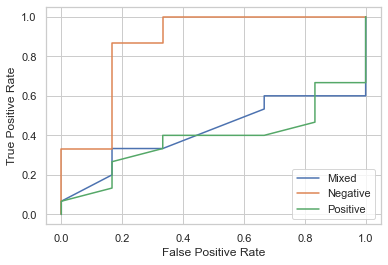

In [77]:
from sklearn import metrics
import matplotlib.pyplot as plt 

fpr, tpr, _ = metrics.roc_curve(y_test_cv,  gridcvs['ExtraTrees'].best_estimator_.predict_proba(X_test_mix)[:,1])
fpr_neg, tpr_neg, _ = metrics.roc_curve(y_test_cv,  gridcvs['ExtraTrees'].best_estimator_.predict_proba(X_test_neg)[:,1])
fpr_pos, tpr_pos, _ = metrics.roc_curve(y_test_cv,  gridcvs['ExtraTrees'].best_estimator_.predict_proba(X_test_pos)[:,1])

#create ROC curve
plt.plot(fpr,tpr,label='Mixed')
plt.plot(fpr_neg,tpr_neg,label='Negative')
plt.plot(fpr_pos,tpr_pos,label='Positive')
plt.legend(loc = 0)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Plotting boxplots of the accuracies of all different algorithms in the case of positive, negative and mixed tails of the connectivity features

No handles with labels found to put in legend.


Text(0, 0.5, 'Accuracy')

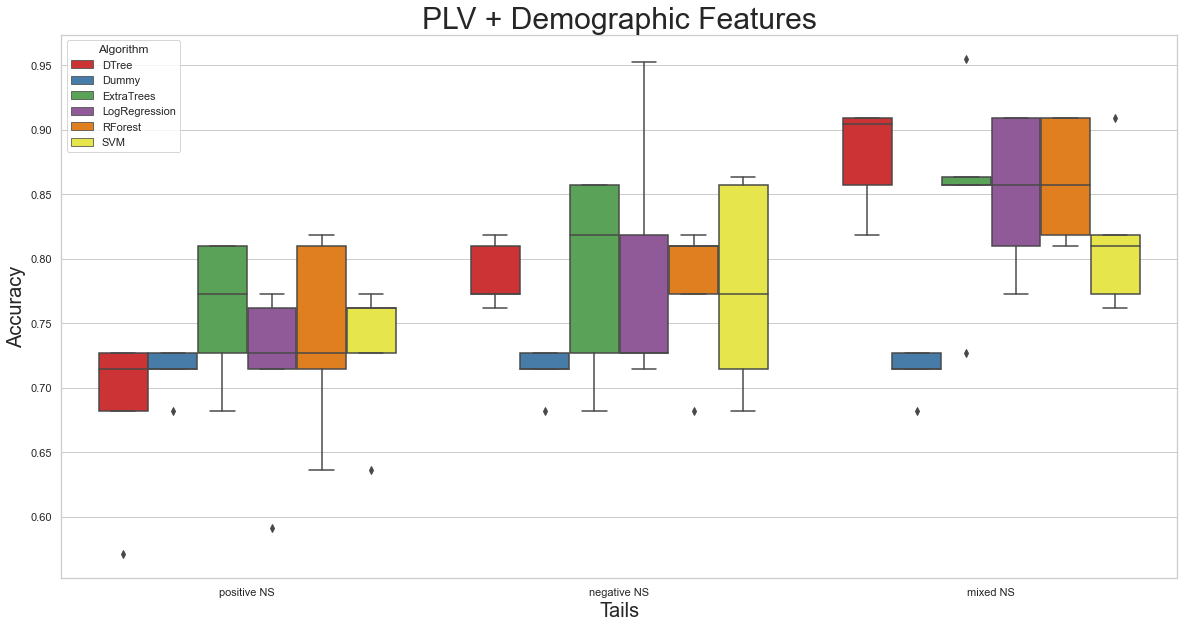

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_pos = pd.DataFrame.from_dict(outer_scores_pos).assign(Features="positive NS")
df_neg = pd.DataFrame.from_dict(outer_scores_neg).assign(Features="negative NS")
df_mix = pd.DataFrame.from_dict(outer_scores_mix).assign(Features="mixed NS")

cdf = pd.concat([df_pos, df_neg, df_mix]) 
mdf = pd.melt(cdf, id_vars=['Features'], var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)
plt.title("Accuracy")
# sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf, palette='Set1')  # RUN PLOT  

a = sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf, palette='Set1') # RUN PLOT  
a.set_title("PLV + Demographic Features", fontsize = 30)
a.set_xlabel("Tails", fontsize = 20)
a.set_ylabel("Accuracy", fontsize = 20)

#plt.legend(bbox_to_anchor=(1, 0.6))
#sns.set(rc = {'figure.figsize':(10,5)})
#sns.show()

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'ROC-AUC'}, xlabel='Features', ylabel='value'>

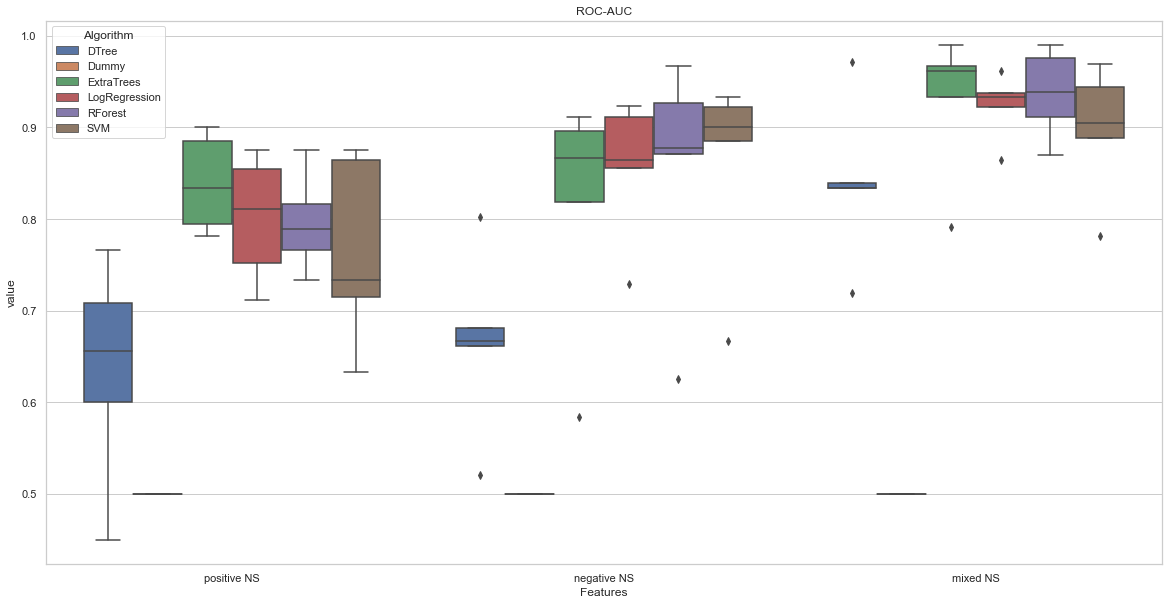

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_pos_roc = pd.DataFrame.from_dict(outer_roc_scores_pos).assign(Features="positive NS")
df_neg_roc = pd.DataFrame.from_dict(outer_roc_scores_neg).assign(Features="negative NS")
df_mix_roc = pd.DataFrame.from_dict(outer_roc_scores_mix).assign(Features="mixed NS")

cdf = pd.concat([df_pos_roc, df_neg_roc, df_mix_roc]) 
mdf = pd.melt(cdf, id_vars=['Features'], var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)
plt.title("ROC-AUC")
sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf)  # RUN PLOT  

# Spectral Features (RBP) with the demographics

<a id="section_3"></a>

In [91]:
# Loading the RBP features
import pandas as pd
import numpy as np
import scipy.io

data_dir = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Demographic_BL.xlsx'

df = pd.read_excel (data_dir)
df.drop(['Visit','Disease Duration (months)','LED'], 1, inplace=True)
df.drop(85, inplace=True)

RBP_dir_HC = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\RBP_features_HC_BL.mat'
RBP_dir_PD = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\RBP_features_PD_BL.mat'

RBP_features_HC = scipy.io.loadmat(RBP_dir_HC)
RBP_features_PD = scipy.io.loadmat(RBP_dir_PD)
RBP_features_HC = RBP_features_HC['pfeat']
RBP_features_PD = RBP_features_PD['pfeat']
RBP_features_HC = np.delete(RBP_features_HC, 8, axis=0)
RBP_features_HC.shape, RBP_features_PD.shape

((31, 210, 5), (77, 210, 5))

In [92]:
df.head()

,ID,Group,Age,EduTot,Sex
0,CG001,PD,67.0,18.0,0.0
1,CG002,PD,70.0,10.0,1.0
2,CG005,PD,62.0,11.0,0.0
3,CG006,PD,59.0,11.0,0.0
4,CG007,PD,59.0,11.0,0.0


In [93]:
# Concatenating the spectral features for the PD and HC groups
RBP_features = np.concatenate((RBP_features_PD,RBP_features_HC))
RBP_features

array([[[0.27930139, 0.25835871, 0.22815206, 0.07531577, 0.12936007],
        [0.19024677, 0.31726876, 0.2794546 , 0.06603027, 0.1204354 ],
        [0.22724376, 0.32614591, 0.19535174, 0.08687174, 0.13660446],
        ...,
        [0.25883379, 0.25986116, 0.16152959, 0.0771946 , 0.15907809],
        [0.16381618, 0.32298347, 0.29481469, 0.05793584, 0.12515827],
        [0.26972763, 0.364699  , 0.21682993, 0.04377105, 0.10135579]],

       [[0.22968751, 0.12860245, 0.19572055, 0.11953575, 0.2229835 ],
        [0.19024352, 0.12418702, 0.22544211, 0.11877545, 0.22293942],
        [0.15755663, 0.13128257, 0.31478433, 0.17421042, 0.21772407],
        ...,
        [0.19292852, 0.13426095, 0.1886756 , 0.10632016, 0.23979131],
        [0.18199935, 0.13021435, 0.28214467, 0.14024994, 0.20158105],
        [0.23600254, 0.13707407, 0.16201555, 0.1002124 , 0.22884335]],

       [[0.26924537, 0.24561985, 0.22764062, 0.05561103, 0.13415972],
        [0.36945071, 0.32908029, 0.16372989, 0.03224532, 0.0

In [94]:
# Re-making the Group column (independent variable) numerical again: 1 for PD and 0 for HC
if df['Group'][0] == 'PD' or df['Group'][0] == 'HC':
    temp = {'PD': 1, 'HC': 0}
    a = np.array(df['Group'].map(temp))
    df['Group'] = a
df = df.reset_index(drop=True)
df

,ID,Group,Age,EduTot,Sex
0,CG001,1,67.0,18.0,0.0
1,CG002,1,70.0,10.0,1.0
2,CG005,1,62.0,11.0,0.0
3,CG006,1,59.0,11.0,0.0
4,CG007,1,59.0,11.0,0.0
...,...,...,...,...,...
103,CT095,0,67.0,17.0,0.0
104,CT096,0,67.0,18.0,0.0
105,CT097,0,65.0,12.0,0.0
106,CT098,0,71.0,17.0,1.0


In [95]:
# Extracting RBP features by bands for all of the subjects
band1_RBP_features = RBP_features[:,:,0]
band2_RBP_features = RBP_features[:,:,1]
band3_RBP_features = RBP_features[:,:,2]
band4_RBP_features = RBP_features[:,:,3]
band5_RBP_features = RBP_features[:,:,4]

band1_RBP_features.shape

(108, 210)

In [96]:
df['Delta Band RBP']  = band1_RBP_features.tolist()
df['Theta Band RBP']  = band2_RBP_features.tolist()
df['Alpha-1 Band RBP']  = band3_RBP_features.tolist()
df['Alpha-2 Band RBP']  = band4_RBP_features.tolist()
df['Beta Band RBP']  = band5_RBP_features.tolist()

df

,ID,Group,Age,EduTot,Sex,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP
0,CG001,1,67.0,18.0,0.0,"[0.27930139353789984, 0.19024676915696115, 0.2...","[0.25835871019414774, 0.31726876297320866, 0.3...","[0.22815205927333498, 0.279454600991002, 0.195...","[0.07531577054384589, 0.06603027320331795, 0.0...","[0.12936006655785498, 0.12043540468151072, 0.1..."
1,CG002,1,70.0,10.0,1.0,"[0.22968750759266282, 0.19024352157788255, 0.1...","[0.1286024502955175, 0.1241870220956375, 0.131...","[0.19572054506665773, 0.2254421122622552, 0.31...","[0.11953575488386645, 0.11877545314674051, 0.1...","[0.22298349718807436, 0.22293942452775042, 0.2..."
2,CG005,1,62.0,11.0,0.0,"[0.2692453709455037, 0.3694507134790448, 0.272...","[0.24561985172856493, 0.3290802905458041, 0.28...","[0.22764061635514324, 0.16372989275579322, 0.2...","[0.055611025026598926, 0.032245321613351245, 0...","[0.13415971926473544, 0.08259742688413606, 0.1..."
3,CG006,1,59.0,11.0,0.0,"[0.14498675662575233, 0.06531583153881207, 0.0...","[0.07481915409340427, 0.05215206114154541, 0.0...","[0.11924888877906527, 0.06686816952603757, 0.1...","[0.08232851231858683, 0.11768016053489298, 0.1...","[0.35183540421112863, 0.4363283982376636, 0.37..."
4,CG007,1,59.0,11.0,0.0,"[0.3685978632708119, 0.369832049637512, 0.3092...","[0.27556531865155437, 0.30224504799851004, 0.3...","[0.07671323709089958, 0.09273848085472787, 0.1...","[0.05651310027012748, 0.052161919208139486, 0....","[0.16211884139635227, 0.13284025052199788, 0.1..."
...,...,...,...,...,...,...,...,...,...,...
103,CT095,0,67.0,17.0,0.0,"[0.16067718839912773, 0.09594023088716817, 0.1...","[0.08084086695485623, 0.09996837652701186, 0.0...","[0.08293866483883205, 0.1456452882049573, 0.05...","[0.10355281214717352, 0.12504007700557998, 0.1...","[0.3847789177421604, 0.3721691367368385, 0.454..."
104,CT096,0,67.0,18.0,0.0,"[0.09475555555408682, 0.15582165399309697, 0.1...","[0.07736646301329678, 0.17198809001946047, 0.0...","[0.15075150664972756, 0.3268058078190336, 0.16...","[0.06838639023790474, 0.03851254026667337, 0.0...","[0.3205376975010563, 0.19011553629948322, 0.30..."
105,CT097,0,65.0,12.0,0.0,"[0.14777732835184124, 0.1915809381020874, 0.11...","[0.20868064733565006, 0.2384539843786895, 0.23...","[0.2947869619427068, 0.31758950473849984, 0.40...","[0.1050475990773537, 0.08025385750304162, 0.12...","[0.1900977239015252, 0.14189855516085698, 0.13..."
106,CT098,0,71.0,17.0,1.0,"[0.2257626410565894, 0.23650706334569102, 0.11...","[0.12589392817376982, 0.1203177080498927, 0.11...","[0.09351664984477781, 0.08723689884222707, 0.1...","[0.1216491888665059, 0.13980042956914487, 0.20...","[0.34443473360459204, 0.30815954183943334, 0.3..."


##### Seperating the features X_RBP and the label y_RBP (independent variable) 

In [97]:
X_RBP = df.iloc[:,2:]
y_RBP = df.iloc[:,1]
  
    
X_RBP,y_RBP

(      Age  EduTot  Sex                                     Delta Band RBP  \
 0    67.0    18.0  0.0  [0.27930139353789984, 0.19024676915696115, 0.2...   
 1    70.0    10.0  1.0  [0.22968750759266282, 0.19024352157788255, 0.1...   
 2    62.0    11.0  0.0  [0.2692453709455037, 0.3694507134790448, 0.272...   
 3    59.0    11.0  0.0  [0.14498675662575233, 0.06531583153881207, 0.0...   
 4    59.0    11.0  0.0  [0.3685978632708119, 0.369832049637512, 0.3092...   
 ..    ...     ...  ...                                                ...   
 103  67.0    17.0  0.0  [0.16067718839912773, 0.09594023088716817, 0.1...   
 104  67.0    18.0  0.0  [0.09475555555408682, 0.15582165399309697, 0.1...   
 105  65.0    12.0  0.0  [0.14777732835184124, 0.1915809381020874, 0.11...   
 106  71.0    17.0  1.0  [0.2257626410565894, 0.23650706334569102, 0.11...   
 107  66.0    10.0  1.0  [0.3180793691251068, 0.3451674818845246, 0.299...   
 
                                         Theta Band RBP  \
 0 

##### Plotting the distributions of the spectral features in each group for the five frequency bands

In [98]:
y_RBP

0      1
1      1
2      1
3      1
4      1
      ..
103    0
104    0
105    0
106    0
107    0
Name: Group, Length: 108, dtype: int64

In [99]:
brain_regions = 210
p_thresh = 0.5
X_plot_RBP = X_RBP.copy(deep = True)
pos_mask_X_RBP, neg_mask_X_RBP, pos_NS_X_RBP, neg_NS_X_RBP, mix_NS_X_RBP = ccf_train_RBP(X_plot_RBP, y_RBP, brain_regions, p_thresh)
X_plot_RBP.drop(columns=X_plot_RBP.columns[-5:], axis=1,  inplace=True)

X_plot_RBP.loc[:, 'Delta Band (pos)'] = pos_NS_X_RBP.band1
X_plot_RBP.loc[:, 'Theta Band (pos)'] = pos_NS_X_RBP.band2
X_plot_RBP.loc[:, 'Alpha-1 Band (pos)'] = pos_NS_X_RBP.band3
X_plot_RBP.loc[:, 'Alpha-2 Band (pos)'] = pos_NS_X_RBP.band4
X_plot_RBP.loc[:, 'Beta Band (pos)'] = pos_NS_X_RBP.band5

X_plot_RBP.loc[:, 'Delta Band (neg)'] = neg_NS_X_RBP.band1
X_plot_RBP.loc[:, 'Theta Band (neg)'] = neg_NS_X_RBP.band2
X_plot_RBP.loc[:, 'Alpha-1 Band (neg)'] = neg_NS_X_RBP.band3
X_plot_RBP.loc[:, 'Alpha-2 Band (neg)'] = neg_NS_X_RBP.band4
X_plot_RBP.loc[:, 'Beta Band (neg)'] = neg_NS_X_RBP.band5

X_plot_RBP.loc[:, 'Delta Band (mix)'] = mix_NS_X_RBP.band1
X_plot_RBP.loc[:, 'Theta Band (mix)'] = mix_NS_X_RBP.band2
X_plot_RBP.loc[:, 'Alpha-1 Band (mix)'] = mix_NS_X_RBP.band3
X_plot_RBP.loc[:, 'Alpha-2 Band (mix)'] = mix_NS_X_RBP.band4
X_plot_RBP.loc[:, 'Beta Band (mix)'] = mix_NS_X_RBP.band5

y_plot_RBP = y_RBP.copy(deep=True)
# Making the Group column (independent variable) numerical: 1 for PD and 0 for HC
if y_plot_RBP[0] == 0 or y_plot_RBP[0] == 1:
    temp = {1: 'PD', 0: 'HC'}
    y_plot_RBP = np.array(y_plot_RBP.map(temp))

X_plot_RBP.loc[:, 'Group'] = y_plot_RBP
X_plot_RBP

,Age,EduTot,Sex,Delta Band (pos),Theta Band (pos),Alpha-1 Band (pos),Alpha-2 Band (pos),Beta Band (pos),Delta Band (neg),Theta Band (neg),Alpha-1 Band (neg),Alpha-2 Band (neg),Beta Band (neg),Delta Band (mix),Theta Band (mix),Alpha-1 Band (mix),Alpha-2 Band (mix),Beta Band (mix),Group
0,67.0,18.0,0.0,0.094942,0.290762,0.0,0.0,0.002992,0.015492,0.0,0.195188,0.210891,0.099452,0.079450,0.290762,-0.195188,-0.210891,-0.096460,PD
1,70.0,10.0,1.0,0.080704,0.134041,0.0,0.0,0.002947,0.014353,0.0,0.195700,0.216988,0.173792,0.066351,0.134041,-0.195700,-0.216988,-0.170846,PD
2,62.0,11.0,0.0,0.108158,0.286998,0.0,0.0,0.001801,0.021665,0.0,0.151506,0.167318,0.101337,0.086493,0.286998,-0.151506,-0.167318,-0.099536,PD
3,59.0,11.0,0.0,0.042961,0.067406,0.0,0.0,0.006411,0.004719,0.0,0.101628,0.112732,0.286933,0.038242,0.067406,-0.101628,-0.112732,-0.280522,PD
4,59.0,11.0,0.0,0.128355,0.305400,0.0,0.0,0.002828,0.019480,0.0,0.071353,0.079125,0.121267,0.108875,0.305400,-0.071353,-0.079125,-0.118440,PD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,67.0,17.0,0.0,0.045515,0.078170,0.0,0.0,0.006403,0.005309,0.0,0.077920,0.083575,0.318712,0.040206,0.078170,-0.077920,-0.083575,-0.312309,HC
104,67.0,18.0,0.0,0.037884,0.098190,0.0,0.0,0.003726,0.007652,0.0,0.146911,0.156299,0.243815,0.030233,0.098190,-0.146911,-0.156299,-0.240089,HC
105,65.0,12.0,0.0,0.071380,0.231387,0.0,0.0,0.002380,0.014653,0.0,0.236339,0.261771,0.132178,0.056727,0.231387,-0.236339,-0.261771,-0.129798,HC
106,71.0,17.0,1.0,0.077660,0.132733,0.0,0.0,0.004405,0.016271,0.0,0.092155,0.101740,0.262494,0.061389,0.132733,-0.092155,-0.101740,-0.258090,HC


Positive tail:

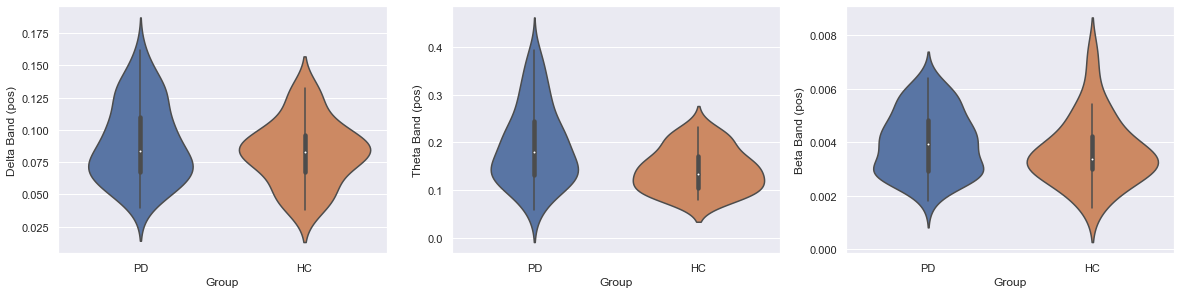

In [100]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
sns.violinplot(x="Group", y="Delta Band (pos)", data=X_plot_RBP, ax=axes[0,0])
sns.violinplot(x="Group", y="Theta Band (pos)", data=X_plot_RBP, ax=axes[0,1])
sns.violinplot(x="Group", y="Alpha-1 Band (pos)", data=X_plot_RBP, ax=axes[1,1])
sns.violinplot(x="Group", y="Alpha-2 Band (pos)", data=X_plot_RBP, ax=axes[1,0])
sns.violinplot(x="Group", y="Beta Band (pos)", data=X_plot_RBP, ax=axes[0,2])

fig.delaxes(axes[1,2])
fig.delaxes(axes[1,1])
fig.delaxes(axes[1,0])

Negative tail:

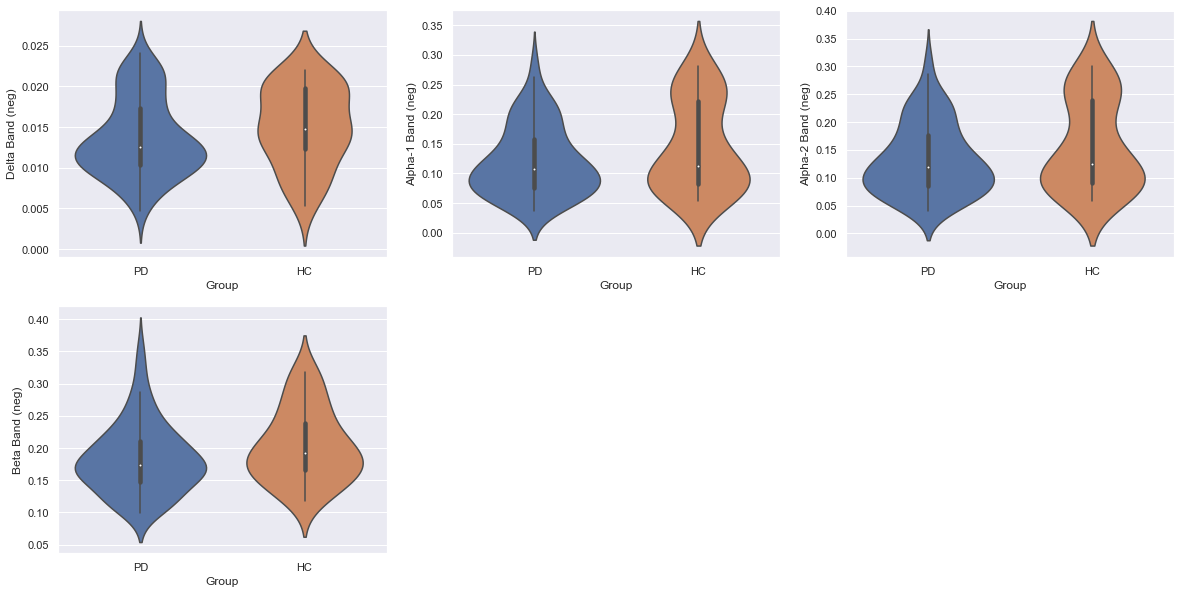

In [101]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
sns.violinplot(x="Group", y="Delta Band (neg)", data=X_plot_RBP, ax=axes[0,0])
sns.violinplot(x="Group", y="Theta Band (neg)", data=X_plot_RBP, ax=axes[1,1])
sns.violinplot(x="Group", y="Alpha-1 Band (neg)", data=X_plot_RBP, ax=axes[0,1])
sns.violinplot(x="Group", y="Alpha-2 Band (neg)", data=X_plot_RBP, ax=axes[0,2])
sns.violinplot(x="Group", y="Beta Band (neg)", data=X_plot_RBP, ax=axes[1,0])

fig.delaxes(axes[1,2])
fig.delaxes(axes[1,1])

Mixed tail:

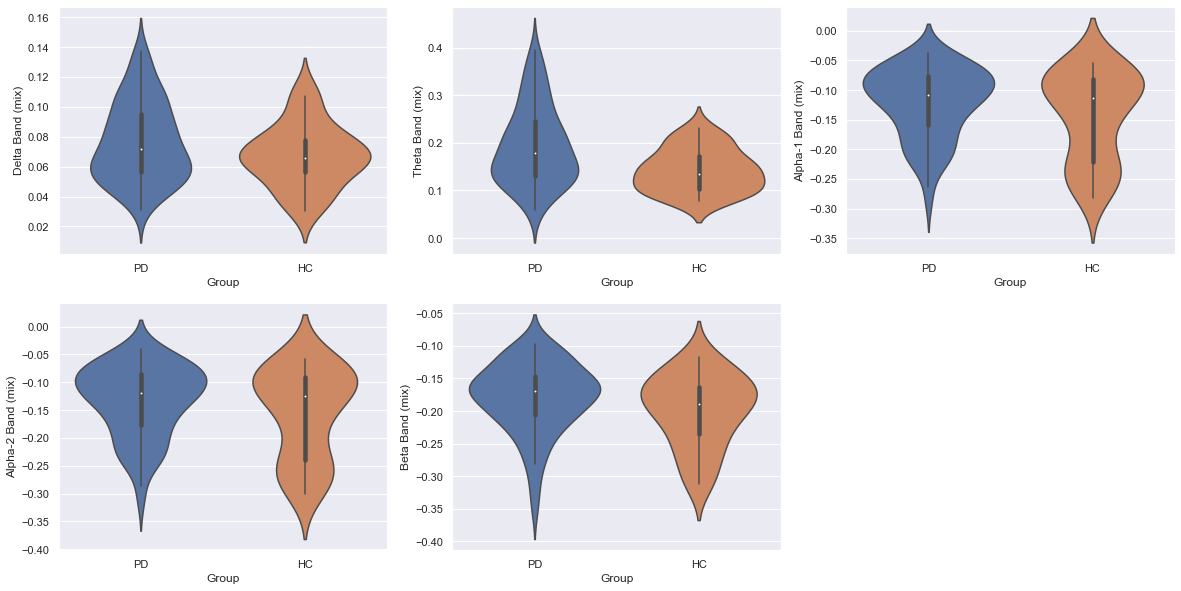

In [102]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
sns.violinplot(x="Group", y="Delta Band (mix)", data=X_plot_RBP, ax=axes[0,0])
sns.violinplot(x="Group", y="Theta Band (mix)", data=X_plot_RBP, ax=axes[0,1])
sns.violinplot(x="Group", y="Alpha-1 Band (mix)", data=X_plot_RBP, ax=axes[0,2])
sns.violinplot(x="Group", y="Alpha-2 Band (mix)", data=X_plot_RBP, ax=axes[1,0])
sns.violinplot(x="Group", y="Beta Band (mix)", data=X_plot_RBP, ax=axes[1,1])

fig.delaxes(axes[1,2])

In [111]:
a = stats.pointbiserialr(X_plot_RBP['Delta Band (mix)'],y)
b = stats.pointbiserialr(X_plot_RBP['Theta Band (mix)'],y)
c = stats.pointbiserialr(X_plot_RBP['Alpha-1 Band (mix)'],y)
d = stats.pointbiserialr(X_plot_RBP['Alpha-2 Band (mix)'],y)
e = stats.pointbiserialr(X_plot_RBP['Beta Band (mix)'],y)

print(a)
print(b)
print(c)
print(d)
print(e)

print('\nTo test their significance, we compare the p-values to the number ' + str(0.05/210) + ' (Bonferroni)')

PointbiserialrResult(correlation=0.16682024470787213, pvalue=0.0844216617653549)
PointbiserialrResult(correlation=0.3048278790416844, pvalue=0.00133799170717262)
PointbiserialrResult(correlation=0.16463754010518442, pvalue=0.0886253331199562)
PointbiserialrResult(correlation=0.1563078690253143, pvalue=0.10621472436523224)
PointbiserialrResult(correlation=0.1665580677940673, pvalue=0.08491802265237129)

To test their significance, we compare the p-values to the number 0.0002380952380952381 (Bonferroni)


# Calculating the consensus set of spectral features using the LOOCV

In [112]:
import time
from sklearn.model_selection import LeaveOneOut

start_time = time.time()
loo = LeaveOneOut()
brain_regions = 210
threshold = 0.05
nb = 5
list_of_pos_vect_masks_band1_train, list_of_pos_vect_masks_band2_train, list_of_pos_vect_masks_band3_train, list_of_pos_vect_masks_band4_train, list_of_pos_vect_masks_band5_train = [], [], [], [], []
list_of_neg_vect_masks_band1_train, list_of_neg_vect_masks_band2_train, list_of_neg_vect_masks_band3_train, list_of_neg_vect_masks_band4_train, list_of_neg_vect_masks_band5_train = [], [], [], [], []

for train_index, test_index in loo.split(X_RBP):
    X_train, X_test = X_RBP.iloc[train_index], X_RBP.iloc[test_index]
    y_train, y_test = y_RBP.iloc[train_index], y_RBP.iloc[test_index]
    
    # Getting the Connectivity matrices of each band for the training dataset 
    RBP_train = get_RBP_by_bands(X_train, brain_regions)
    
    # Dropping the list of features from the dataframe since we don't need them anymore
    X_train.drop(columns=X_train.columns[-nb:], axis=1,  inplace=True)
    
    # Calculating r and p matrices for the training data
    r_vect_train, p_vect_train = get_r_and_p_vects_by_bands(X_train, y_train, RBP_train, brain_regions)
    
    # Calculating positive and negative masks masks for the training data
    pos_vect_masks_train = get_pos_vect_masks_by_bands(threshold, r_vect_train, p_vect_train)
    neg_vect_mask_train = get_neg_vect_masks_by_bands(threshold, r_vect_train, p_vect_train)
    
    # Extracting the upper triangular part (21495 features)
    #pos_mask_band1_train_1D, pos_mask_band2_train_1D, pos_mask_band3_train_1D, pos_mask_band4_train_1D, pos_mask_band5_train_1D = pos_mask_band1_train[np.triu_indices(brain_regions, k=1)], pos_mask_band2_train[np.triu_indices(brain_regions, k=1)], pos_mask_band3_train[np.triu_indices(brain_regions, k=1)], pos_mask_band4_train[np.triu_indices(brain_regions, k=1)], pos_mask_band5_train[np.triu_indices(brain_regions, k=1)]
    #neg_mask_band1_train_1D, neg_mask_band2_train_1D, neg_mask_band3_train_1D, neg_mask_band4_train_1D, neg_mask_band5_train_1D = neg_mask_band1_train[np.triu_indices(brain_regions, k=1)], neg_mask_band2_train[np.triu_indices(brain_regions, k=1)], neg_mask_band3_train[np.triu_indices(brain_regions, k=1)], neg_mask_band4_train[np.triu_indices(brain_regions, k=1)], neg_mask_band5_train[np.triu_indices(brain_regions, k=1)]
    
    # Making lists of positive masks in each band (to store them for later use when computing consensus)
    list_of_pos_vect_masks_band1_train.append(pos_vect_masks_train.band1)
    list_of_pos_vect_masks_band2_train.append(pos_vect_masks_train.band2)
    list_of_pos_vect_masks_band3_train.append(pos_vect_masks_train.band3)
    list_of_pos_vect_masks_band4_train.append(pos_vect_masks_train.band4)
    list_of_pos_vect_masks_band5_train.append(pos_vect_masks_train.band5)
    
    # Making lists of negative masks in each band (to store them for later use when computing consensus)
    list_of_neg_vect_masks_band1_train.append(neg_vect_mask_train.band1)
    list_of_neg_vect_masks_band2_train.append(neg_vect_mask_train.band2)
    list_of_neg_vect_masks_band3_train.append(neg_vect_mask_train.band3)
    list_of_neg_vect_masks_band4_train.append(neg_vect_mask_train.band4)
    list_of_neg_vect_masks_band5_train.append(neg_vect_mask_train.band5)
    
print("--- %f minutes ---" % (float(time.time() - start_time)/60))

C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


--- 0.398546 minutes ---


##### Calculating the positive and negative consensus sets for each band

In [113]:
RBP_consensus_pos_band1, RBP_consensus_pos_band2, RBP_consensus_pos_band3, RBP_consensus_pos_band4, RBP_consensus_pos_band5 = np.ones_like(list_of_pos_vect_masks_band1_train[0]), np.ones_like(list_of_pos_vect_masks_band2_train[0]), np.ones_like(list_of_pos_vect_masks_band3_train[0]), np.ones_like(list_of_pos_vect_masks_band4_train[0]), np.ones_like(list_of_pos_vect_masks_band5_train[0])
RBP_consensus_neg_band1, RBP_consensus_neg_band2, RBP_consensus_neg_band3, RBP_consensus_neg_band4, RBP_consensus_neg_band5 = np.ones_like(list_of_neg_vect_masks_band1_train[0]), np.ones_like(list_of_neg_vect_masks_band2_train[0]), np.ones_like(list_of_neg_vect_masks_band3_train[0]), np.ones_like(list_of_neg_vect_masks_band4_train[0]), np.ones_like(list_of_neg_vect_masks_band5_train[0])

for i in range(len(list_of_pos_vect_masks_band1_train)):
    
    RBP_consensus_pos_band1 = np.multiply(RBP_consensus_pos_band1,list_of_pos_vect_masks_band1_train[i])
    RBP_consensus_pos_band2 = np.multiply(RBP_consensus_pos_band2,list_of_pos_vect_masks_band2_train[i])
    RBP_consensus_pos_band3 = np.multiply(RBP_consensus_pos_band3,list_of_pos_vect_masks_band3_train[i])
    RBP_consensus_pos_band4 = np.multiply(RBP_consensus_pos_band4,list_of_pos_vect_masks_band4_train[i])
    RBP_consensus_pos_band5 = np.multiply(RBP_consensus_pos_band5,list_of_pos_vect_masks_band5_train[i])
    
    RBP_consensus_neg_band1 = np.multiply(RBP_consensus_neg_band1,list_of_neg_vect_masks_band1_train[i])
    RBP_consensus_neg_band2 = np.multiply(RBP_consensus_neg_band2,list_of_neg_vect_masks_band2_train[i])
    RBP_consensus_neg_band3 = np.multiply(RBP_consensus_neg_band3,list_of_neg_vect_masks_band3_train[i])
    RBP_consensus_neg_band4 = np.multiply(RBP_consensus_neg_band4,list_of_neg_vect_masks_band4_train[i])
    RBP_consensus_neg_band5 = np.multiply(RBP_consensus_neg_band5,list_of_neg_vect_masks_band5_train[i])

##### Number of features left in each band for the positive tail

In [114]:
np.count_nonzero(RBP_consensus_pos_band1 == 1), np.count_nonzero(RBP_consensus_pos_band2 == 1), np.count_nonzero(RBP_consensus_pos_band3 == 1), np.count_nonzero(RBP_consensus_pos_band4 == 1), np.count_nonzero(RBP_consensus_pos_band5 == 1)

(0, 197, 0, 0, 0)

##### Number of features left in each band for the negative tail

In [115]:
np.count_nonzero(RBP_consensus_neg_band1 == 1), np.count_nonzero(RBP_consensus_neg_band2 == 1), np.count_nonzero(RBP_consensus_neg_band3 == 1), np.count_nonzero(RBP_consensus_neg_band4 == 1), np.count_nonzero(RBP_consensus_neg_band5 == 1)

(0, 0, 7, 121, 11)

# Training the models

In [116]:
X_train_RBP = X_RBP
y_train_RBP = y_RBP
brain_regions = 210
RBP_train = get_RBP_by_bands(X_train_RBP, brain_regions)
X_train_RBP

,Age,EduTot,Sex,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP
0,67.0,18.0,0.0,"[0.27930139353789984, 0.19024676915696115, 0.2...","[0.25835871019414774, 0.31726876297320866, 0.3...","[0.22815205927333498, 0.279454600991002, 0.195...","[0.07531577054384589, 0.06603027320331795, 0.0...","[0.12936006655785498, 0.12043540468151072, 0.1..."
1,70.0,10.0,1.0,"[0.22968750759266282, 0.19024352157788255, 0.1...","[0.1286024502955175, 0.1241870220956375, 0.131...","[0.19572054506665773, 0.2254421122622552, 0.31...","[0.11953575488386645, 0.11877545314674051, 0.1...","[0.22298349718807436, 0.22293942452775042, 0.2..."
2,62.0,11.0,0.0,"[0.2692453709455037, 0.3694507134790448, 0.272...","[0.24561985172856493, 0.3290802905458041, 0.28...","[0.22764061635514324, 0.16372989275579322, 0.2...","[0.055611025026598926, 0.032245321613351245, 0...","[0.13415971926473544, 0.08259742688413606, 0.1..."
3,59.0,11.0,0.0,"[0.14498675662575233, 0.06531583153881207, 0.0...","[0.07481915409340427, 0.05215206114154541, 0.0...","[0.11924888877906527, 0.06686816952603757, 0.1...","[0.08232851231858683, 0.11768016053489298, 0.1...","[0.35183540421112863, 0.4363283982376636, 0.37..."
4,59.0,11.0,0.0,"[0.3685978632708119, 0.369832049637512, 0.3092...","[0.27556531865155437, 0.30224504799851004, 0.3...","[0.07671323709089958, 0.09273848085472787, 0.1...","[0.05651310027012748, 0.052161919208139486, 0....","[0.16211884139635227, 0.13284025052199788, 0.1..."
...,...,...,...,...,...,...,...,...
103,67.0,17.0,0.0,"[0.16067718839912773, 0.09594023088716817, 0.1...","[0.08084086695485623, 0.09996837652701186, 0.0...","[0.08293866483883205, 0.1456452882049573, 0.05...","[0.10355281214717352, 0.12504007700557998, 0.1...","[0.3847789177421604, 0.3721691367368385, 0.454..."
104,67.0,18.0,0.0,"[0.09475555555408682, 0.15582165399309697, 0.1...","[0.07736646301329678, 0.17198809001946047, 0.0...","[0.15075150664972756, 0.3268058078190336, 0.16...","[0.06838639023790474, 0.03851254026667337, 0.0...","[0.3205376975010563, 0.19011553629948322, 0.30..."
105,65.0,12.0,0.0,"[0.14777732835184124, 0.1915809381020874, 0.11...","[0.20868064733565006, 0.2384539843786895, 0.23...","[0.2947869619427068, 0.31758950473849984, 0.40...","[0.1050475990773537, 0.08025385750304162, 0.12...","[0.1900977239015252, 0.14189855516085698, 0.13..."
106,71.0,17.0,1.0,"[0.2257626410565894, 0.23650706334569102, 0.11...","[0.12589392817376982, 0.1203177080498927, 0.11...","[0.09351664984477781, 0.08723689884222707, 0.1...","[0.1216491888665059, 0.13980042956914487, 0.20...","[0.34443473360459204, 0.30815954183943334, 0.3..."


## Positive NS features only:
<a id="RBP_dem_pos"></a>

In [117]:
brain_regions = 210
p_thresh = 0.05

RBP_outer_scores_pos = {}
RBP_outer_roc_scores_pos = {}
RBP_specificity_pos = {}
RBP_sensitivity_pos = {}
RBP_precision_pos = {}
RBP_f1_pos = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    RBP_outer_scores_pos['{}'.format(name)] = []
    RBP_outer_roc_scores_pos['{}'.format(name)] = []
    RBP_specificity_pos['{}'.format(name)] = []
    RBP_sensitivity_pos['{}'.format(name)] = []
    RBP_precision_pos['{}'.format(name)] = []
    RBP_f1_pos['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train_RBP, y_train_RBP):
        
        X_train_pos_RBP = X_train_RBP.copy(deep = True)
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_train_RBP, y_train_RBP, brain_regions, p_thresh)
        X_train_pos_RBP.drop(columns=X_train_pos_RBP.columns[-5:], axis=1,  inplace=True)
        X_train_pos_RBP.loc[:, 'Positive NS band 1'] = pos_NS_train_RBP.band1
        X_train_pos_RBP.loc[:, 'Positive NS band 2'] = pos_NS_train_RBP.band2
        X_train_pos_RBP.loc[:, 'Positive NS band 3'] = pos_NS_train_RBP.band3
        X_train_pos_RBP.loc[:, 'Positive NS band 4'] = pos_NS_train_RBP.band4
        X_train_pos_RBP.loc[:, 'Positive NS band 5'] = pos_NS_train_RBP.band5
        
        gridcvs[name].fit(X_train_pos_RBP.iloc[train_idx], y_train_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_RBP_cv = X_train_RBP.iloc[valid_idx]
        y_test_RBP_cv = y_train_RBP.iloc[valid_idx]
    
        X_test_pos_RBP = X_test_RBP_cv.copy(deep = True)
        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_RBP_cv, y_test_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_pos_RBP.drop(columns=X_test_pos_RBP.columns[-5:], axis=1,  inplace=True)
        X_test_pos_RBP.loc[:, 'Positive NS band 1'] = pos_NS_test_RBP.band1
        X_test_pos_RBP.loc[:, 'Positive NS band 2'] = pos_NS_test_RBP.band2
        X_test_pos_RBP.loc[:, 'Positive NS band 3'] = pos_NS_test_RBP.band3
        X_test_pos_RBP.loc[:, 'Positive NS band 4'] = pos_NS_test_RBP.band4
        X_test_pos_RBP.loc[:, 'Positive NS band 5'] = pos_NS_test_RBP.band5
        
        RBP_outer_roc_scores_pos['{}'.format(name)].append(roc_auc_score(y_test_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_pos_RBP)[:,1]))
        RBP_outer_scores_pos['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_pos_RBP, y_test_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_RBP)).ravel()
        RBP_sensitivity_pos['{}'.format(name)].append(tp / (tp+fn))
        RBP_specificity_pos['{}'.format(name)].append(tn / (tn+fp))
        RBP_precision_pos['{}'.format(name)].append(tp / (tp+fp))
        RBP_f1_pos['{}'.format(name)].append(2*(RBP_sensitivity_pos['{}'.format(name)][-1] * RBP_precision_pos['{}'.format(name)][-1])/(RBP_sensitivity_pos['{}'.format(name)][-1] + RBP_precision_pos['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (RBP_outer_scores_pos['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (RBP_outer_roc_scores_pos['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (RBP_specificity_pos['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (RBP_sensitivity_pos['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (RBP_precision_pos['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (RBP_f1_pos['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_RBP)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(RBP_outer_scores_pos['{}'.format(name)]) * 100, np.std(RBP_outer_scores_pos['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(RBP_outer_roc_scores_pos['{}'.format(name)]), np.std(RBP_outer_roc_scores_pos['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(RBP_specificity_pos['{}'.format(name)]), np.std(RBP_specificity_pos['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_pos['{}'.format(name)]), np.std(RBP_sensitivity_pos['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(RBP_precision_pos['{}'.format(name)]), np.std(RBP_precision_pos['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(RBP_f1_pos['{}'.format(name)]), np.std(RBP_f1_pos['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.62
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.73
        F1-Score (on outer test fold) 0.84
        Confusion matrix: 
[[ 0  6]
 [ 0 16]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'criterion': 'entropy', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    

KeyboardInterrupt: 

## Negative NS features only: 
<a id="RBP_dem_neg"></a>

In [118]:
brain_regions = 210
p_thresh = 0.05

RBP_outer_scores_neg = {}
RBP_outer_roc_scores_neg = {}
RBP_specificity_neg = {}
RBP_sensitivity_neg = {}
RBP_precision_neg = {}
RBP_f1_neg = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    RBP_outer_scores_neg['{}'.format(name)] = []
    RBP_outer_roc_scores_neg['{}'.format(name)] = []
    RBP_specificity_neg['{}'.format(name)] = []
    RBP_sensitivity_neg['{}'.format(name)] = []
    RBP_precision_neg['{}'.format(name)] = []
    RBP_f1_neg['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train_RBP, y_train_RBP):
        
        X_train_neg_RBP = X_train_RBP.copy(deep = True)
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_train_RBP, y_train_RBP, brain_regions, p_thresh)
        X_train_neg_RBP.drop(columns=X_train_neg_RBP.columns[-5:], axis=1,  inplace=True)
        X_train_neg_RBP.loc[:, 'Negative NS band 1'] = neg_NS_train_RBP.band1
        X_train_neg_RBP.loc[:, 'Negative NS band 2'] = neg_NS_train_RBP.band2
        X_train_neg_RBP.loc[:, 'Negative NS band 3'] = neg_NS_train_RBP.band3
        X_train_neg_RBP.loc[:, 'Negative NS band 4'] = neg_NS_train_RBP.band4
        X_train_neg_RBP.loc[:, 'Negative NS band 5'] = neg_NS_train_RBP.band5
        
        gridcvs[name].fit(X_train_neg_RBP.iloc[train_idx], y_train_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_RBP_cv = X_train_RBP.iloc[valid_idx]
        y_test_RBP_cv = y_train_RBP.iloc[valid_idx]
    
        X_test_neg_RBP = X_test_RBP_cv.copy(deep = True)
        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_RBP_cv, y_test_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_neg_RBP.drop(columns=X_test_neg_RBP.columns[-5:], axis=1,  inplace=True)
        X_test_neg_RBP.loc[:, 'Negative NS band 1'] = neg_NS_test_RBP.band1
        X_test_neg_RBP.loc[:, 'Negative NS band 2'] = neg_NS_test_RBP.band2
        X_test_neg_RBP.loc[:, 'Negative NS band 3'] = neg_NS_test_RBP.band3
        X_test_neg_RBP.loc[:, 'Negative NS band 4'] = neg_NS_test_RBP.band4
        X_test_neg_RBP.loc[:, 'Negative NS band 5'] = neg_NS_test_RBP.band5
        
        RBP_outer_roc_scores_neg['{}'.format(name)].append(roc_auc_score(y_test_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_neg_RBP)[:,1]))
        RBP_outer_scores_neg['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_neg_RBP, y_test_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_RBP)).ravel()
        RBP_sensitivity_neg['{}'.format(name)].append(tp / (tp+fn))
        RBP_specificity_neg['{}'.format(name)].append(tn / (tn+fp))
        RBP_precision_neg['{}'.format(name)].append(tp / (tp+fp))
        RBP_f1_neg['{}'.format(name)].append(2*(RBP_sensitivity_neg['{}'.format(name)][-1] * RBP_precision_neg['{}'.format(name)][-1])/(RBP_sensitivity_neg['{}'.format(name)][-1] + RBP_precision_neg['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (RBP_outer_scores_neg['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (RBP_outer_roc_scores_neg['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (RBP_specificity_neg['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (RBP_sensitivity_neg['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (RBP_precision_neg['{}'.format(name)][-1]))
        print('        F1-Score on outer test fold) %.2f' % (RBP_f1_neg['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_RBP)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(RBP_outer_scores_neg['{}'.format(name)]) * 100, np.std(RBP_outer_scores_neg['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(RBP_outer_roc_scores_neg['{}'.format(name)]), np.std(RBP_outer_roc_scores_neg['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(RBP_specificity_neg['{}'.format(name)]), np.std(RBP_specificity_neg['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_neg['{}'.format(name)]), np.std(RBP_sensitivity_neg['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(RBP_precision_neg['{}'.format(name)]), np.std(RBP_precision_neg['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(RBP_f1_neg['{}'.format(name)]), np.std(RBP_f1_neg['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 74.42%
        Best parameters: {'criterion': 'entropy', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.57
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.81
        Precision (on outer test fold) 0.76
        F1-Score on outer test fold) 0.79
        Confusion matrix: 
[[ 2  4]
 [ 3 13]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'criterion': 'entropy', 'max_depth': 9}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
  


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 71.33%
        Best parameters: {'n_estimators': 1000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 66.67%
        ROC-AUC (on outer test fold) 0.70
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.72
        F1-Score on outer test fold) 0.79
        Confusion matrix: 
[[ 1  5]
 [ 2 13]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.11%
        Best parameters: {'n_estimators': 10000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.80
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test 

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 74.42%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 59.09%
        ROC-AUC (on outer test fold) 0.67
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 0.81
        Precision (on outer test fold) 0.68
        F1-Score on outer test fold) 0.74
        Confusion matrix: 
[[ 0  6]
 [ 3 13]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer test fold) 0.88
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.79
        F1-Score on outer test fold) 0.86
        Confusion matrix: 
[[ 2  4]
 [ 1 15]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer test fold) 0.93
        Specificity (on outer test fold) 0.71
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.87
        F1-Score on outer test fold) 0.87
        Confusion matrix: 
[[ 5  2]
 [ 2 13]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.44%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.70
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.75
        F1-Score on outer test fold) 0.86
        Confusion matrix: 
[[ 1  5]
 [ 0 15]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 71.33%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.89
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.93
        F1-Score on outer test fold) 0.90
        Confusion matrix: 
[[ 5  1]
 [ 2 13]]

    Outer Loop:
        ACC 76.02% +/- 9.12
        ROC-AUC 0.81 +/- 0.11
        Specificity 0.41 +/- 0.32
        Sensitivity 0.90 +/- 0.07
        Precision 0.80 +/- 0.09
        F1-Score 0.84 +/- 0.05
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25


## Mixed NS features (Positive - Negative) 
<a id="RBP_dem_mix"></a>

In [119]:
brain_regions = 210
p_thresh = 0.05

RBP_outer_scores_mix = {}
RBP_outer_roc_scores_mix = {}
RBP_specificity_mix = {}
RBP_sensitivity_mix = {}
RBP_precision_mix = {}
RBP_f1_mix = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    RBP_outer_scores_mix['{}'.format(name)] = []
    RBP_outer_roc_scores_mix['{}'.format(name)] = []
    RBP_specificity_mix['{}'.format(name)] = []
    RBP_sensitivity_mix['{}'.format(name)] = []
    RBP_precision_mix['{}'.format(name)] = []
    RBP_f1_mix['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train_RBP, y_train_RBP):
        
        X_train_mix_RBP = X_train_RBP.copy(deep = True)
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_train_RBP, y_train_RBP, brain_regions, p_thresh)
        X_train_mix_RBP.drop(columns=X_train_mix_RBP.columns[-5:], axis=1,  inplace=True)
        X_train_mix_RBP.loc[:, 'Mixed NS band 1'] = mix_NS_train_RBP.band1
        X_train_mix_RBP.loc[:, 'Mixed NS band 2'] = mix_NS_train_RBP.band2
        X_train_mix_RBP.loc[:, 'Mixed NS band 3'] = mix_NS_train_RBP.band3
        X_train_mix_RBP.loc[:, 'Mixed NS band 4'] = mix_NS_train_RBP.band4
        X_train_mix_RBP.loc[:, 'Mixed NS band 5'] = mix_NS_train_RBP.band5
        
        gridcvs[name].fit(X_train_mix_RBP.iloc[train_idx], y_train_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_RBP_cv = X_train_RBP.iloc[valid_idx]
        y_test_RBP_cv = y_train_RBP.iloc[valid_idx]
    
        X_test_mix_RBP = X_test_RBP_cv.copy(deep = True)
        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_RBP_cv, y_test_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_mix_RBP.drop(columns=X_test_mix_RBP.columns[-5:], axis=1,  inplace=True)
        X_test_mix_RBP.loc[:, 'Mixed NS band 1'] = mix_NS_test_RBP.band1
        X_test_mix_RBP.loc[:, 'Mixed NS band 2'] = mix_NS_test_RBP.band2
        X_test_mix_RBP.loc[:, 'Mixed NS band 3'] = mix_NS_test_RBP.band3
        X_test_mix_RBP.loc[:, 'Mixed NS band 4'] = mix_NS_test_RBP.band4
        X_test_mix_RBP.loc[:, 'Mixed NS band 5'] = mix_NS_test_RBP.band5
        
        RBP_outer_roc_scores_mix['{}'.format(name)].append(roc_auc_score(y_test_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_mix_RBP)[:,1]))
        RBP_outer_scores_mix['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_mix_RBP, y_test_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_RBP)).ravel()
        RBP_sensitivity_mix['{}'.format(name)].append(tp / (tp+fn))
        RBP_specificity_mix['{}'.format(name)].append(tn / (tn+fp))
        RBP_precision_mix['{}'.format(name)].append(tp / (tp+fp))
        RBP_f1_mix['{}'.format(name)].append(2*(RBP_sensitivity_mix['{}'.format(name)][-1] * RBP_precision_mix['{}'.format(name)][-1])/(RBP_sensitivity_mix['{}'.format(name)][-1] + RBP_precision_mix['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (RBP_outer_scores_mix['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (RBP_outer_roc_scores_mix['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (RBP_specificity_mix['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (RBP_sensitivity_mix['{}'.format(name)][-1]))
        print('        PRecision (on outer test fold) %.2f' % (RBP_precision_mix['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (RBP_f1_mix['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_RBP)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(RBP_outer_scores_mix['{}'.format(name)]) * 100, np.std(RBP_outer_scores_mix['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(RBP_outer_roc_scores_mix['{}'.format(name)]), np.std(RBP_outer_roc_scores_mix['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(RBP_specificity_mix['{}'.format(name)]), np.std(RBP_specificity_mix['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_mix['{}'.format(name)]), np.std(RBP_sensitivity_mix['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(RBP_precision_mix['{}'.format(name)]), np.std(RBP_precision_mix['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(RBP_f1_mix['{}'.format(name)]), np.std(RBP_f1_mix['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.09%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 63.64%
        ROC-AUC (on outer test fold) 0.54
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.75
        PRecision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.75
        Confusion matrix: 
[[ 2  4]
 [ 4 12]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 68.60%
        Best parameters: {'criterion': 'entropy', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.19%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 66.67%
        ROC-AUC (on outer test fold) 0.64
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.87
        PRecision (on outer test fold) 0.72
        F1-Score (on outer test fold) 0.79
        Confusion matrix: 
[[ 1  5]
 [ 2 13]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 68.95%
        Best parameters: {'n_estimators': 1000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 66.67%
        ROC-AUC (on outer test fold) 0.72
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test f

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.58%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 63.64%
        ROC-AUC (on outer test fold) 0.64
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.81
        PRecision (on outer test fold) 0.72
        F1-Score (on outer test fold) 0.76
        Confusion matrix: 
[[ 1  5]
 [ 3 13]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer test fold) 0.81
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.94
        PRecision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 2  4]
 [ 1 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf1__C': 0.1, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer t


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 71.27%
        Best parameters: {'clf4__C': 0.001, 'clf4__gamma': 0.001, 'clf4__kernel': 'rbf'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.26
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 1.00
        PRecision (on outer test fold) 0.71
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 0  6]
 [ 0 15]]

    Outer Loop:
        ACC 72.21% +/- 2.94
        ROC-AUC 0.55 +/- 0.19
        Specificity 0.03 +/- 0.07
        Sensitivity 1.00 +/- 0.00
        Precision 0.72 +/- 0.03
        F1-Score 0.84 +/- 0.02


##### Plotting boxplots of the accuracies of all different algorithms in the case of positive, negative and mixed tails of the spectral features

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_pos_RBP = pd.DataFrame.from_dict(RBP_outer_scores_pos).assign(Features="positive NS")
df_neg_RBP = pd.DataFrame.from_dict(RBP_outer_scores_neg).assign(Features="negative NS")
df_mix_RBP = pd.DataFrame.from_dict(RBP_outer_scores_mix).assign(Features="mixed NS")

cdf_RBP = pd.concat([df_pos_RBP, df_neg_RBP, df_mix_RBP]) 
mdf_RBP = pd.melt(cdf_RBP, id_vars=['Features'], var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)
plt.title("Accuracy")
sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf_RBP, palette='Set1')  # RUN PLOT  

#plt.legend(bbox_to_anchor=(1, 0.6))
#sns.set(rc = {'figure.figsize':(10,5)})
#sns.show()

ValueError: arrays must all be same length

# Conenctivity and spectral (PLV & RBP) with the demographics

##### Loading the data:

<a id="section_4"></a>

In [43]:
# Loading the PLV features
import scipy.io

# Connectivity features directory files (should be modified when executing on a different machine)
PLV_dir_HC = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\PLV_features_HC_BL.mat'
PLV_dir_PD = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\PLV_features_PD_BL.mat'
PLV_features_HC = scipy.io.loadmat(PLV_dir_HC)
PLV_features_PD = scipy.io.loadmat(PLV_dir_PD)
PLV_features_HC = PLV_features_HC['feathc']
PLV_features_PD = PLV_features_PD['feat']
PLV_features_HC = np.delete(PLV_features_HC, 8, axis=0)
# Concatenating the PLV features of the two groups
PLV_features = np.concatenate((PLV_features_PD,PLV_features_HC))
# Extracting PLV featues by bands for all of the subjects
band1_PLV_features = PLV_features[:,:,0]
band2_PLV_features = PLV_features[:,:,1]
band3_PLV_features = PLV_features[:,:,2]
band4_PLV_features = PLV_features[:,:,3]
band5_PLV_features = PLV_features[:,:,4]

# Spectral features directory files (should be modified when executing on a different machine)
RBP_dir_HC = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\RBP_features_HC_BL.mat'
RBP_dir_PD = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\RBP_features_PD_BL.mat'
RBP_features_HC = scipy.io.loadmat(RBP_dir_HC)
RBP_features_PD = scipy.io.loadmat(RBP_dir_PD)
RBP_features_HC = RBP_features_HC['pfeat']
RBP_features_PD = RBP_features_PD['pfeat']
RBP_features_HC = np.delete(RBP_features_HC, 8, axis=0)
# Concatenating the spectral features for the PD and HC groups
RBP_features = np.concatenate((RBP_features_PD,RBP_features_HC))
# Extracting RBP features by bands for all of the subjects
band1_RBP_features = RBP_features[:,:,0]
band2_RBP_features = RBP_features[:,:,1]
band3_RBP_features = RBP_features[:,:,2]
band4_RBP_features = RBP_features[:,:,3]
band5_RBP_features = RBP_features[:,:,4]

<a id="section_5"></a>

In [44]:
import pandas as pd

data_dir = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Demographic_BL.xlsx'
df = pd.read_excel (data_dir)
df.drop(['Visit','Disease Duration (months)','LED'], 1, inplace=True)
df.drop(85, inplace=True)

df['Delta Band PLV'] = band1_PLV_features.tolist()
df['Theta Band PLV'] = band2_PLV_features.tolist()
df['Alpha-1 Band PLV'] = band3_PLV_features.tolist()
df['Alpha-2 Band PLV'] = band4_PLV_features.tolist()
df['Beta Band PLV'] = band5_PLV_features.tolist()

df['Delta Band RBP'] = band1_RBP_features.tolist()
df['Theta Band RBP'] = band2_RBP_features.tolist()
df['Alpha-1 Band RBP'] = band3_RBP_features.tolist()
df['Alpha-2 Band RBP'] = band4_RBP_features.tolist()
df['Beta Band RBP'] = band5_RBP_features.tolist()

In [45]:
if df['Group'][0] == 'PD' or df['Group'][0] == 'HC':
    temp = {'PD': 1, 'HC': 0}
    a = np.array(df['Group'].map(temp))
    df['Group'] = a
df = df.reset_index(drop=True)
df

,ID,Group,Age,EduTot,Sex,Delta Band PLV,Theta Band PLV,Alpha-1 Band PLV,Alpha-2 Band PLV,Beta Band PLV,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP
0,CG001,1,67.0,18.0,0.0,"[0.3299719341123857, 0.3421083623846939, 0.338...","[0.42783390861769055, 0.43974943039037623, 0.4...","[0.6297937282246409, 0.5860556883800777, 0.626...","[0.5807397402041623, 0.5619380172392363, 0.592...","[0.40023660331289274, 0.39117798378274804, 0.4...","[0.27930139353789984, 0.19024676915696115, 0.2...","[0.25835871019414774, 0.31726876297320866, 0.3...","[0.22815205927333498, 0.279454600991002, 0.195...","[0.07531577054384589, 0.06603027320331795, 0.0...","[0.12936006655785498, 0.12043540468151072, 0.1..."
1,CG002,1,70.0,10.0,1.0,"[0.5232535547529593, 0.3169627430507698, 0.351...","[0.5077720158552852, 0.420239215261448, 0.4710...","[0.7339541940937256, 0.686837237333406, 0.6894...","[0.6509953299886201, 0.602640331435429, 0.6025...","[0.4646928750179029, 0.410852543594747, 0.4136...","[0.22968750759266282, 0.19024352157788255, 0.1...","[0.1286024502955175, 0.1241870220956375, 0.131...","[0.19572054506665773, 0.2254421122622552, 0.31...","[0.11953575488386645, 0.11877545314674051, 0.1...","[0.22298349718807436, 0.22293942452775042, 0.2..."
2,CG005,1,62.0,11.0,0.0,"[0.6361501266679429, 0.5186073906512177, 0.558...","[0.5709007731123399, 0.493772124076352, 0.5310...","[0.7264734332210528, 0.7097373049127511, 0.663...","[0.5782090129570738, 0.6221600321468722, 0.536...","[0.4451717037875112, 0.5188650604689992, 0.439...","[0.2692453709455037, 0.3694507134790448, 0.272...","[0.24561985172856493, 0.3290802905458041, 0.28...","[0.22764061635514324, 0.16372989275579322, 0.2...","[0.055611025026598926, 0.032245321613351245, 0...","[0.13415971926473544, 0.08259742688413606, 0.1..."
3,CG006,1,59.0,11.0,0.0,"[0.3403584406729545, 0.3418135772917265, 0.313...","[0.4262743722645898, 0.43705285373364355, 0.46...","[0.5988926102847753, 0.6525952495161779, 0.643...","[0.531048673711687, 0.5487255289286241, 0.5850...","[0.4096211090620683, 0.4726363681806558, 0.488...","[0.14498675662575233, 0.06531583153881207, 0.0...","[0.07481915409340427, 0.05215206114154541, 0.0...","[0.11924888877906527, 0.06686816952603757, 0.1...","[0.08232851231858683, 0.11768016053489298, 0.1...","[0.35183540421112863, 0.4363283982376636, 0.37..."
4,CG007,1,59.0,11.0,0.0,"[0.4595195028925641, 0.4370547199294692, 0.400...","[0.54403770511117, 0.4940320705510591, 0.47178...","[0.5987911331542768, 0.617755301386667, 0.5735...","[0.579825193259185, 0.6023892907542882, 0.5656...","[0.43807249620905014, 0.4618428712858114, 0.43...","[0.3685978632708119, 0.369832049637512, 0.3092...","[0.27556531865155437, 0.30224504799851004, 0.3...","[0.07671323709089958, 0.09273848085472787, 0.1...","[0.05651310027012748, 0.052161919208139486, 0....","[0.16211884139635227, 0.13284025052199788, 0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,CT095,0,67.0,17.0,0.0,"[0.40124677796522884, 0.35873119478348964, 0.3...","[0.5625786544817638, 0.4762571131643108, 0.475...","[0.7280394240181173, 0.6079151051400026, 0.619...","[0.6297983269043267, 0.6164896216244006, 0.593...","[0.4560688022370609, 0.4346896382751522, 0.439...","[0.16067718839912773, 0.09594023088716817, 0.1...","[0.08084086695485623, 0.09996837652701186, 0.0...","[0.08293866483883205, 0.1456452882049573, 0.05...","[0.10355281214717352, 0.12504007700557998, 0.1...","[0.3847789177421604, 0.3721691367368385, 0.454..."
104,CT096,0,67.0,18.0,0.0,"[0.5765239241793428, 0.5037303169970976, 0.458...","[0.553411456126455, 0.5315950366231612, 0.4941...","[0.7239515791727588, 0.6706700364255954, 0.689...","[0.5541502220713473, 0.5780218062127834, 0.515...","[0.40977074667411917, 0.4329740748039863, 0.40...","[0.09475555555408682, 0.15582165399309697, 0.1...","[0.07736646301329678, 0.17198809001946047, 0.0...","[0.15075150664972756, 0.3268058078190336, 0.16...","[0.06838639023790474, 0.03851254026667337, 0.0

In [46]:
X_PLV_RBP = df.iloc[:,2:]
y_PLV_RBP = df.iloc[:,1]
X_PLV_RBP,y_PLV_RBP

(      Age  EduTot  Sex                                     Delta Band PLV  \
 0    67.0    18.0  0.0  [0.3299719341123857, 0.3421083623846939, 0.338...   
 1    70.0    10.0  1.0  [0.5232535547529593, 0.3169627430507698, 0.351...   
 2    62.0    11.0  0.0  [0.6361501266679429, 0.5186073906512177, 0.558...   
 3    59.0    11.0  0.0  [0.3403584406729545, 0.3418135772917265, 0.313...   
 4    59.0    11.0  0.0  [0.4595195028925641, 0.4370547199294692, 0.400...   
 ..    ...     ...  ...                                                ...   
 103  67.0    17.0  0.0  [0.40124677796522884, 0.35873119478348964, 0.3...   
 104  67.0    18.0  0.0  [0.5765239241793428, 0.5037303169970976, 0.458...   
 105  65.0    12.0  0.0  [0.3431558718190335, 0.4429635415770021, 0.326...   
 106  71.0    17.0  1.0  [0.49059352552559693, 0.3630125473432296, 0.35...   
 107  66.0    10.0  1.0  [0.424549791513331, 0.3374003949617814, 0.3464...   
 
                                         Theta Band PLV  \
 0 

## Positive features only: 
<a id="PLV_RBP_dem_pos"></a>

In [ ]:
brain_regions = 210
p_thresh = 0.05

PLV_RBP_outer_scores_pos = {}
PLV_RBP_outer_roc_scores_pos = {}
PLV_RBP_specificity_pos = {}
PLV_RBP_sensitivity_pos = {}
PLV_RBP_precision_pos = {}
PLV_RBP_f1_pos = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    PLV_RBP_outer_scores_pos['{}'.format(name)] = []
    PLV_RBP_outer_roc_scores_pos['{}'.format(name)] = []
    PLV_RBP_specificity_pos['{}'.format(name)] = []
    PLV_RBP_sensitivity_pos['{}'.format(name)] = []
    PLV_RBP_precision_pos['{}'.format(name)] = []
    PLV_RBP_f1_pos['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_PLV_RBP, y_PLV_RBP):
        
        X_train_pos_PLV_RBP = X_PLV_RBP.copy(deep = True)
    
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_pos_PLV_RBP.drop(columns=X_train_pos_PLV_RBP.columns[-5:], axis=1,  inplace=True)
        X_train_pos_PLV_RBP.loc[:, 'RBP Pos NS band 1'] = pos_NS_train_RBP.band1
        X_train_pos_PLV_RBP.loc[:, 'RBP Pos NS band 2'] = pos_NS_train_RBP.band2
        X_train_pos_PLV_RBP.loc[:, 'RBP Pos NS band 3'] = pos_NS_train_RBP.band3
        X_train_pos_PLV_RBP.loc[:, 'RBP Pos NS band 4'] = pos_NS_train_RBP.band4
        X_train_pos_PLV_RBP.loc[:, 'RBP Pos NS band 5'] = pos_NS_train_RBP.band5
        
        pos_mask_train_PLV, neg_mask_train_PLV, pos_NS_train_PLV, neg_NS_train_PLV, mix_NS_train_PLV = ccf_train(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_pos_PLV_RBP.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_train_pos_PLV_RBP.loc[:, 'PLV Pos NS band 1'] = pos_NS_train_PLV.band1
        X_train_pos_PLV_RBP.loc[:, 'PLV Pos NS band 2'] = pos_NS_train_PLV.band2
        X_train_pos_PLV_RBP.loc[:, 'PLV Pos NS band 3'] = pos_NS_train_PLV.band3
        X_train_pos_PLV_RBP.loc[:, 'PLV Pos NS band 4'] = pos_NS_train_PLV.band4
        X_train_pos_PLV_RBP.loc[:, 'PLV Pos NS band 5'] = pos_NS_train_PLV.band5
        
        gridcvs[name].fit(X_train_pos_PLV_RBP.iloc[train_idx], y_PLV_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_PLV_RBP_cv = X_PLV_RBP.iloc[valid_idx]
        y_test_PLV_RBP_cv = y_PLV_RBP.iloc[valid_idx]
    
        X_test_pos_PLV_RBP = X_test_PLV_RBP_cv.copy(deep = True)

        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_pos_PLV_RBP.drop(columns=X_test_pos_PLV_RBP.columns[-5:], axis=1,  inplace=True)
        X_test_pos_PLV_RBP.loc[:, 'RBP Pos NS band 1'] = pos_NS_test_RBP.band1
        X_test_pos_PLV_RBP.loc[:, 'RBP Pos NS band 2'] = pos_NS_test_RBP.band2
        X_test_pos_PLV_RBP.loc[:, 'RBP Pos NS band 3'] = pos_NS_test_RBP.band3
        X_test_pos_PLV_RBP.loc[:, 'RBP Pos NS band 4'] = pos_NS_test_RBP.band4
        X_test_pos_PLV_RBP.loc[:, 'RBP Pos NS band 5'] = pos_NS_test_RBP.band5
        
        pos_NS_test_PLV, neg_NS_test_PLV, mix_NS_test_PLV = ccf_test(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_PLV, neg_mask_train_PLV)
        X_test_pos_PLV_RBP.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_test_pos_PLV_RBP.loc[:, 'PLV Pos NS band 1'] = pos_NS_test_PLV.band1
        X_test_pos_PLV_RBP.loc[:, 'PLV Pos NS band 2'] = pos_NS_test_PLV.band2
        X_test_pos_PLV_RBP.loc[:, 'PLV Pos NS band 3'] = pos_NS_test_PLV.band3
        X_test_pos_PLV_RBP.loc[:, 'PLV Pos NS band 4'] = pos_NS_test_PLV.band4
        X_test_pos_PLV_RBP.loc[:, 'PLV Pos NS band 5'] = pos_NS_test_PLV.band5
        
        
        PLV_RBP_outer_roc_scores_pos['{}'.format(name)].append(roc_auc_score(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_pos_PLV_RBP)[:,1]))
        PLV_RBP_outer_scores_pos['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_pos_PLV_RBP, y_test_PLV_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_PLV_RBP)).ravel()
        PLV_RBP_sensitivity_pos['{}'.format(name)].append(tp / (tp+fn))
        PLV_RBP_specificity_pos['{}'.format(name)].append(tn / (tn+fp))
        PLV_RBP_precision_pos['{}'.format(name)].append(tp / (tp+fp))
        PLV_RBP_f1_pos['{}'.format(name)].append(2*(PLV_RBP_sensitivity_pos['{}'.format(name)][-1] * PLV_RBP_precision_pos['{}'.format(name)][-1])/(PLV_RBP_sensitivity_pos['{}'.format(name)][-1] + PLV_RBP_precision_pos['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (PLV_RBP_outer_scores_pos['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (PLV_RBP_outer_roc_scores_pos['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (PLV_RBP_specificity_pos['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (PLV_RBP_sensitivity_pos['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (PLV_RBP_precision_pos['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (PLV_RBP_f1_pos['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_PLV_RBP)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(PLV_RBP_outer_scores_pos['{}'.format(name)]) * 100, np.std(PLV_RBP_outer_scores_pos['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_outer_roc_scores_pos['{}'.format(name)]), np.std(PLV_RBP_outer_roc_scores_pos['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_specificity_pos['{}'.format(name)]), np.std(PLV_RBP_specificity_pos['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_sensitivity_pos['{}'.format(name)]), np.std(PLV_RBP_sensitivity_pos['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_precision_pos['{}'.format(name)]), np.std(PLV_RBP_precision_pos['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_f1_pos['{}'.format(name)]), np.std(PLV_RBP_f1_pos['{}'.format(name)])))

## Negative features only:
<a id="PLV_RBP_dem_neg"></a>

In [82]:
brain_regions = 210
p_thresh = 0.05

PLV_RBP_outer_scores_neg = {}
PLV_RBP_outer_roc_scores_neg = {}
PLV_RBP_specificity_neg = {}
PLV_RBP_sensitivity_neg = {}
PLV_RBP_precision_neg = {}
PLV_RBP_f1_neg = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    PLV_RBP_outer_scores_neg['{}'.format(name)] = []
    PLV_RBP_outer_roc_scores_neg['{}'.format(name)] = []
    PLV_RBP_specificity_neg['{}'.format(name)] = []
    PLV_RBP_sensitivity_neg['{}'.format(name)] = []
    PLV_RBP_precision_neg['{}'.format(name)] = []
    PLV_RBP_f1_neg['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_PLV_RBP, y_PLV_RBP):
        
        X_train_neg_PLV_RBP = X_PLV_RBP.copy(deep = True)
        pos_mask_train_PLV, neg_mask_train_PLV, pos_NS_train_PLV, neg_NS_train_PLV, mix_NS_train_PLV = ccf_train(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
    
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_neg_PLV_RBP.drop(columns=X_train_neg_PLV_RBP.columns[-5:], axis=1,  inplace=True)
        X_train_neg_PLV_RBP.loc[:, 'RBP Neg NS band 1'] = neg_NS_train_RBP.band1
        X_train_neg_PLV_RBP.loc[:, 'RBP Neg NS band 2'] = neg_NS_train_RBP.band2
        X_train_neg_PLV_RBP.loc[:, 'RBP Neg NS band 3'] = neg_NS_train_RBP.band3
        X_train_neg_PLV_RBP.loc[:, 'RBP Neg NS band 4'] = neg_NS_train_RBP.band4
        X_train_neg_PLV_RBP.loc[:, 'RBP Neg NS band 5'] = neg_NS_train_RBP.band5
        
        X_train_neg_PLV_RBP.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_train_neg_PLV_RBP.loc[:, 'PLV Neg NS band 1'] = neg_NS_train_PLV.band1
        X_train_neg_PLV_RBP.loc[:, 'PLV Neg NS band 2'] = neg_NS_train_PLV.band2
        X_train_neg_PLV_RBP.loc[:, 'PLV Neg NS band 3'] = neg_NS_train_PLV.band3
        X_train_neg_PLV_RBP.loc[:, 'PLV Neg NS band 4'] = neg_NS_train_PLV.band4
        X_train_neg_PLV_RBP.loc[:, 'PLV Neg NS band 5'] = neg_NS_train_PLV.band5
        
        gridcvs[name].fit(X_train_neg_PLV_RBP.iloc[train_idx], y_PLV_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_PLV_RBP_cv = X_PLV_RBP.iloc[valid_idx]
        y_test_PLV_RBP_cv = y_PLV_RBP.iloc[valid_idx]
    
        X_test_neg_PLV_RBP = X_test_PLV_RBP_cv.copy(deep = True)

        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_neg_PLV_RBP.drop(columns=X_test_neg_PLV_RBP.columns[-5:], axis=1,  inplace=True)
        X_test_neg_PLV_RBP.loc[:, 'RBP Neg NS band 1'] = neg_NS_test_RBP.band1
        X_test_neg_PLV_RBP.loc[:, 'RBP Neg NS band 2'] = neg_NS_test_RBP.band2
        X_test_neg_PLV_RBP.loc[:, 'RBP Neg NS band 3'] = neg_NS_test_RBP.band3
        X_test_neg_PLV_RBP.loc[:, 'RBP Neg NS band 4'] = neg_NS_test_RBP.band4
        X_test_neg_PLV_RBP.loc[:, 'RBP Neg NS band 5'] = neg_NS_test_RBP.band5
        
        pos_NS_test_PLV, neg_NS_test_PLV, mix_NS_test_PLV = ccf_test(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_PLV, neg_mask_train_PLV)
        X_test_neg_PLV_RBP.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_test_neg_PLV_RBP.loc[:, 'PLV Neg NS band 1'] = neg_NS_test_PLV.band1
        X_test_neg_PLV_RBP.loc[:, 'PLV Neg NS band 2'] = neg_NS_test_PLV.band2
        X_test_neg_PLV_RBP.loc[:, 'PLV Neg NS band 3'] = neg_NS_test_PLV.band3
        X_test_neg_PLV_RBP.loc[:, 'PLV Neg NS band 4'] = neg_NS_test_PLV.band4
        X_test_neg_PLV_RBP.loc[:, 'PLV Neg NS band 5'] = neg_NS_test_PLV.band5
        
        
        PLV_RBP_outer_roc_scores_neg['{}'.format(name)].append(roc_auc_score(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_neg_PLV_RBP)[:,1]))
        PLV_RBP_outer_scores_neg['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_neg_PLV_RBP, y_test_PLV_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_PLV_RBP)).ravel()
        PLV_RBP_sensitivity_neg['{}'.format(name)].append(tp / (tp+fn))
        PLV_RBP_specificity_neg['{}'.format(name)].append(tn / (tn+fp))
        PLV_RBP_precision_neg['{}'.format(name)].append(tp / (tp+fp))
        PLV_RBP_f1_neg['{}'.format(name)].append(2*(PLV_RBP_sensitivity_neg['{}'.format(name)][-1] * PLV_RBP_precision_neg['{}'.format(name)][-1])/(PLV_RBP_sensitivity_neg['{}'.format(name)][-1] + PLV_RBP_precision_neg['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (PLV_RBP_outer_scores_neg['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (PLV_RBP_outer_roc_scores_neg['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (PLV_RBP_specificity_neg['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (PLV_RBP_sensitivity_neg['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (PLV_RBP_precision_neg['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (PLV_RBP_f1_neg['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_PLV_RBP)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(PLV_RBP_outer_scores_neg['{}'.format(name)]) * 100, np.std(PLV_RBP_outer_scores_neg['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_outer_roc_scores_neg['{}'.format(name)]), np.std(PLV_RBP_outer_roc_scores_neg['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_specificity_neg['{}'.format(name)]), np.std(PLV_RBP_specificity_neg['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_sensitivity_neg['{}'.format(name)]), np.std(PLV_RBP_sensitivity_neg['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_precision_neg['{}'.format(name)]), np.std(PLV_RBP_precision_neg['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_f1_neg['{}'.format(name)]), np.std(PLV_RBP_f1_neg['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.59
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.78
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 2  4]
 [ 2 14]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 77.91%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
       


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 78.14%
        Best parameters: {'n_estimators': 100}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.94
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 1  5]
 [ 1 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 74.74%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.48%
        ROC-AUC (on outer test fold) 0.93
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fo

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 87.21%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.75
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.78
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 2  4]
 [ 2 14]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 82.56%
        Best parameters: {'clf1__C': 0.8, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.91%
        ROC-AUC (on outer t


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 82.74%
        Best parameters: {'clf4__C': 0.5, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.86
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 1  5]
 [ 1 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.90%
        Best parameters: {'clf4__C': 0.5, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.91
        Specificity (on outer test fold) 

## Mixed features (Positive - Negative) 
<a id="PLV_RBP_dem_mix"></a>

In [56]:
brain_regions = 210
p_thresh = 0.05

PLV_RBP_outer_scores_mix = {}
PLV_RBP_outer_roc_scores_mix = {}
PLV_RBP_specificity_mix = {}
PLV_RBP_sensitivity_mix = {}
PLV_RBP_precision_mix = {}
PLV_RBP_f1_mix = {}
masks_band1 = {}
masks_band2 = {}
masks_band3 = {}
masks_band4 = {}
masks_band5 = {}

r_mats = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    PLV_RBP_outer_scores_mix['{}'.format(name)] = []
    PLV_RBP_outer_roc_scores_mix['{}'.format(name)] = []
    PLV_RBP_specificity_mix['{}'.format(name)] = []
    PLV_RBP_sensitivity_mix['{}'.format(name)] = []
    PLV_RBP_precision_mix['{}'.format(name)] = []
    PLV_RBP_f1_mix['{}'.format(name)] = []
    masks_band1['{}'.format(name)] = []
    masks_band2['{}'.format(name)] = []
    masks_band3['{}'.format(name)] = []
    masks_band4['{}'.format(name)] = []
    masks_band5['{}'.format(name)] = []
    r_mats['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    count = 1
    for train_idx, valid_idx in outer_cv.split(X_PLV_RBP, y_PLV_RBP):
        
        X_train_mix_PLV_RBP = X_PLV_RBP.copy(deep = True)
    
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_mix_PLV_RBP.drop(columns=X_train_mix_PLV_RBP.columns[-5:], axis=1,  inplace=True)
        X_train_mix_PLV_RBP.loc[:, 'RBP Mix NS band 1'] = mix_NS_train_RBP.band1
        X_train_mix_PLV_RBP.loc[:, 'RBP Mix NS band 2'] = mix_NS_train_RBP.band2
        X_train_mix_PLV_RBP.loc[:, 'RBP Mix NS band 3'] = mix_NS_train_RBP.band3
        X_train_mix_PLV_RBP.loc[:, 'RBP Mix NS band 4'] = mix_NS_train_RBP.band4
        X_train_mix_PLV_RBP.loc[:, 'RBP Mix NS band 5'] = mix_NS_train_RBP.band5
        
        r_mat_train, pos_mask_train_PLV, neg_mask_train_PLV, pos_NS_train_PLV, neg_NS_train_PLV, mix_NS_train_PLV = ccf_train(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_mix_PLV_RBP.drop(['Delta Band PLV', 'Theta Band PLV', 'Alpha-1 Band PLV', 'Alpha-2 Band PLV', 'Beta Band PLV'], axis=1,  inplace=True)
        X_train_mix_PLV_RBP.loc[:, 'PLV Mix NS band 1'] = mix_NS_train_PLV.band1
        X_train_mix_PLV_RBP.loc[:, 'PLV Mix NS band 2'] = mix_NS_train_PLV.band2
        X_train_mix_PLV_RBP.loc[:, 'PLV Mix NS band 3'] = mix_NS_train_PLV.band3
        X_train_mix_PLV_RBP.loc[:, 'PLV Mix NS band 4'] = mix_NS_train_PLV.band4
        X_train_mix_PLV_RBP.loc[:, 'PLV Mix NS band 5'] = mix_NS_train_PLV.band5
        
        masks_band1['{}'.format(name)].append(pos_mask_train_PLV.band1 + neg_mask_train_PLV.band1)
        masks_band2['{}'.format(name)].append(pos_mask_train_PLV.band2 + neg_mask_train_PLV.band2)
        masks_band3['{}'.format(name)].append(pos_mask_train_PLV.band3 + neg_mask_train_PLV.band3)
        masks_band4['{}'.format(name)].append(pos_mask_train_PLV.band4 + neg_mask_train_PLV.band4)
        masks_band5['{}'.format(name)].append(pos_mask_train_PLV.band5 + neg_mask_train_PLV.band5)
        
        r_mats['{}'.format(name)].append(r_mat_train)
        
        X_train_mix_PLV_RBP = X_train_mix_PLV_RBP.drop(columns='EduTot')
        
        gridcvs[name].fit(X_train_mix_PLV_RBP.iloc[train_idx], y_PLV_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_PLV_RBP_cv = X_PLV_RBP.iloc[valid_idx]
        y_test_PLV_RBP_cv = y_PLV_RBP.iloc[valid_idx]
    
        X_test_mix_PLV_RBP = X_test_PLV_RBP_cv.copy(deep = True)

        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_mix_PLV_RBP.drop(columns=X_test_mix_PLV_RBP.columns[-5:], axis=1,  inplace=True)
        X_test_mix_PLV_RBP.loc[:, 'RBP Mix NS Delta Band'] = mix_NS_test_RBP.band1
        X_test_mix_PLV_RBP.loc[:, 'RBP Mix NS Theta Band'] = mix_NS_test_RBP.band2
        X_test_mix_PLV_RBP.loc[:, 'RBP Mix NS Alpha-1 Band'] = mix_NS_test_RBP.band3
        X_test_mix_PLV_RBP.loc[:, 'RBP Mix NS Alpha-2 Band'] = mix_NS_test_RBP.band4
        X_test_mix_PLV_RBP.loc[:, 'RBP Mix NS Beta Band'] = mix_NS_test_RBP.band5
        
        pos_NS_test_PLV, neg_NS_test_PLV, mix_NS_test_PLV = ccf_test(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_PLV, neg_mask_train_PLV)
        X_test_mix_PLV_RBP.drop(['Delta Band PLV', 'Theta Band PLV', 'Alpha-1 Band PLV', 'Alpha-2 Band PLV', 'Beta Band PLV'], axis=1,  inplace=True)
        X_test_mix_PLV_RBP.loc[:, 'PLV Mix NS Delta Band'] = mix_NS_test_PLV.band1
        X_test_mix_PLV_RBP.loc[:, 'PLV Mix NS Theta Band'] = mix_NS_test_PLV.band2
        X_test_mix_PLV_RBP.loc[:, 'PLV Mix NS Alpha-1 Band'] = mix_NS_test_PLV.band3
        X_test_mix_PLV_RBP.loc[:, 'PLV Mix NS Alpha-2 Band'] = mix_NS_test_PLV.band4
        X_test_mix_PLV_RBP.loc[:, 'PLV Mix NS Beta Band'] = mix_NS_test_PLV.band5
        
        X_test_mix_PLV_RBP = X_test_mix_PLV_RBP.drop(columns='EduTot')
        
        PLV_RBP_outer_roc_scores_mix['{}'.format(name)].append(roc_auc_score(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_mix_PLV_RBP)[:,1]))
        PLV_RBP_outer_scores_mix['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_mix_PLV_RBP, y_test_PLV_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_PLV_RBP)).ravel()
        PLV_RBP_sensitivity_mix['{}'.format(name)].append(tp / (tp+fn))
        PLV_RBP_specificity_mix['{}'.format(name)].append(tn / (tn+fp))
        PLV_RBP_precision_mix['{}'.format(name)].append(tp / (tp+fp))
        PLV_RBP_f1_mix['{}'.format(name)].append(2*(PLV_RBP_sensitivity_mix['{}'.format(name)][-1] * PLV_RBP_precision_mix['{}'.format(name)][-1])/(PLV_RBP_sensitivity_mix['{}'.format(name)][-1] + PLV_RBP_precision_mix['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (PLV_RBP_outer_scores_mix['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (PLV_RBP_outer_roc_scores_mix['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (PLV_RBP_specificity_mix['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (PLV_RBP_sensitivity_mix['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (PLV_RBP_precision_mix['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (PLV_RBP_f1_mix['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_PLV_RBP)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(PLV_RBP_outer_scores_mix['{}'.format(name)]) * 100, np.std(PLV_RBP_outer_scores_mix['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_outer_roc_scores_mix['{}'.format(name)]), np.std(PLV_RBP_outer_roc_scores_mix['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_specificity_mix['{}'.format(name)]), np.std(PLV_RBP_specificity_mix['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_sensitivity_mix['{}'.format(name)]), np.std(PLV_RBP_sensitivity_mix['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_precision_mix['{}'.format(name)]), np.std(PLV_RBP_precision_mix['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_f1_mix['{}'.format(name)]), np.std(PLV_RBP_f1_mix['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer test fold) 0.64
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 2  4]
 [ 1 15]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 84.88%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.91%
       


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 85.12%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.97
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.88
        Confusion matrix: 
[[ 2  4]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 88.48%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.48%
        ROC-AUC (on outer test fold) 0.94
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fol


        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 86.05%
        Best parameters: {'clf4__C': 0.8, 'clf4__gamma': 0.1, 'clf4__kernel': 'rbf'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 86.36%
        ROC-AUC (on outer test fold) 0.97
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.84
        F1-Score (on outer test fold) 0.91
        Confusion matrix: 
[[ 3  3]
 [ 0 16]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 86.05%
        Best parameters: {'clf4__C': 1, 'clf4__gamma': 0.1, 'clf4__kernel': 'rbf'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 95.45%
        ROC-AUC (on outer test fold) 0.99
        S

##### Calculating the discriminant power of one each connectivity features:

In [58]:
r1 = np.zeros(r_mats['ExtraTrees'][0].band1.shape)
r2 = np.zeros(r_mats['ExtraTrees'][0].band2.shape)
r3 = np.zeros(r_mats['ExtraTrees'][0].band3.shape)
r4 = np.zeros(r_mats['ExtraTrees'][0].band4.shape)
r5 = np.zeros(r_mats['ExtraTrees'][0].band5.shape)
for i in range(len(r_mats['ExtraTrees'])):
    r1 = r1 + r_mats['ExtraTrees'][i].band1
    r2 = r2 + r_mats['ExtraTrees'][i].band2
    r3 = r3 + r_mats['ExtraTrees'][i].band3
    r4 = r4 + r_mats['ExtraTrees'][i].band4
    r5 = r5 + r_mats['ExtraTrees'][i].band5
rf1 = np.divide(r1,5)
rf2 = np.divide(r2,5)
rf3 = np.divide(r3,5)
rf4 = np.divide(r4,5)
rf5 = np.divide(r5,5)
#arr = np.zeros(r1.shape)
#rf_list = [rf1,rf2,rf3,rf4,rf5]
#for i in range(len(rf_list)):
#    r_final = np.add(arr,rf_list[i])
#    arr = r_final
#r_final = np.divide(r_final,5)

In [59]:
power_1 = np.multiply(rf1,sum(masks_band1['ExtraTrees']))
power_2 = np.multiply(rf2,sum(masks_band2['ExtraTrees']))
power_3 = np.multiply(rf3,sum(masks_band3['ExtraTrees']))
power_4 = np.multiply(rf4,sum(masks_band4['ExtraTrees']))
power_5 = np.multiply(rf5,sum(masks_band5['ExtraTrees']))
power_1, np.amax(power_1)

(array([[ 0., -0., -0., ..., -0., -0.,  0.],
        [-0.,  0.,  0., ...,  0.,  0.,  0.],
        [-0.,  0.,  0., ..., -0.,  0., -0.],
        ...,
        [-0.,  0., -0., ...,  0., -0.,  0.],
        [-0.,  0.,  0., ..., -0.,  0.,  0.],
        [ 0.,  0., -0., ...,  0.,  0.,  0.]]),
 1.7161379686220422)

 ## Testing our model with an independent dataset
 <a id="testing"></a>

###### importing the data

<a id="section_6"></a>

In [60]:
import pandas as pd

indep_data_dir = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Independent_Data\Demographics_TestData.xlsx' # Change the directory if needed to load the data

df_indep = pd.read_excel(indep_data_dir)
df_indep

,Code,Sex,Age,Education,Group
0,ANNGUE088,1,50,Bac+5,HC
1,BENHOU033,0,54,Bac+2,HC
2,CAMPAT076,1,58,Bac+5 ou plus,HC
3,CLAMEN 024,1,53,Bac+2,HC
4,DAMRIG 025,0,63,Bac+3/Bac+4,HC
5,FRALOU 021,0,66,Bac+3/Bac+4,HC
6,GEOPRE093,0,65,"CAP, BEP",HC
7,GLIMAU066,0,48,Bac+2,HC
8,LEMREU 023,1,50,Bac+3/Bac+4,HC
9,LIGGWE080,0,65,bac+3/bac+4,HC


##### importing their spectral features

<a id="section_7"></a>

In [61]:
# Loading the RBP features
import scipy.io
import numpy as np

# features directory files (should be modified when executing on a different machine)
RBP_dir_HC_indep = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Independent_Data\RBP_features_HC_allBands.mat'
RBP_dir_PD_indep = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Independent_Data\RBP_features_PD_allBands.mat'

RBP_features_HC_indep = scipy.io.loadmat(RBP_dir_HC_indep)
RBP_features_PD_indep = scipy.io.loadmat(RBP_dir_PD_indep)
RBP_features_HC_indep = RBP_features_HC_indep['pfeat']
RBP_features_PD_indep = RBP_features_PD_indep['pfeat']
RBP_features_HC_indep.shape, RBP_features_PD_indep.shape

((25, 210, 5), (25, 210, 5))

In [62]:
# Concatenating the spectral features for the PD and HC groups
RBP_features_indep = np.concatenate((RBP_features_PD_indep,RBP_features_HC_indep))
RBP_features_indep

array([[[0.24197212, 0.1041764 , 0.14577196, 0.07512408, 0.2329196 ],
        [0.17408144, 0.18202017, 0.32527154, 0.07971798, 0.16654618],
        [0.15031317, 0.10657807, 0.17446881, 0.21292613, 0.2318878 ],
        ...,
        [0.1699743 , 0.13303156, 0.18839034, 0.15058283, 0.24759926],
        [0.15527992, 0.10734959, 0.12867746, 0.12255878, 0.26241734],
        [0.19645835, 0.16197868, 0.38901205, 0.07476759, 0.13422858]],

       [[0.16264726, 0.20913789, 0.39543357, 0.04632885, 0.13364367],
        [0.18514292, 0.21778929, 0.37202792, 0.04359437, 0.13473196],
        [0.13791076, 0.25018097, 0.36518596, 0.05773728, 0.15514999],
        ...,
        [0.15149615, 0.24294865, 0.30591268, 0.05196826, 0.16857351],
        [0.18108925, 0.20648061, 0.38487499, 0.05008792, 0.12884067],
        [0.15279597, 0.28832186, 0.27749068, 0.05228804, 0.17156192]],

       [[0.21403127, 0.14380256, 0.1971356 , 0.17207886, 0.24472018],
        [0.21949399, 0.13859271, 0.22904168, 0.1485205 , 0.2

In [63]:
# Extracting RBP features by bands for all of the subjects
band1_RBP_features_indep = RBP_features_indep[:,:,0]
band2_RBP_features_indep = RBP_features_indep[:,:,1]
band3_RBP_features_indep = RBP_features_indep[:,:,2]
band4_RBP_features_indep = RBP_features_indep[:,:,3]
band5_RBP_features_indep = RBP_features_indep[:,:,4]

band1_RBP_features_indep.shape

(50, 210)

In [64]:
# Making the Group column (independent variable) a numerical: 1 for PD and 0 for HC
if df_indep['Group'][0] == 'HC' or df_indep['Group'][0] == 'PD':
    temp = {'PD': 1, 'HC': 0}
    a = np.array(df_indep['Group'].map(temp))
    df_indep['Group'] = a
#df = df.reset_index(drop=True)
df_indep

,Code,Sex,Age,Education,Group
0,ANNGUE088,1,50,Bac+5,0
1,BENHOU033,0,54,Bac+2,0
2,CAMPAT076,1,58,Bac+5 ou plus,0
3,CLAMEN 024,1,53,Bac+2,0
4,DAMRIG 025,0,63,Bac+3/Bac+4,0
5,FRALOU 021,0,66,Bac+3/Bac+4,0
6,GEOPRE093,0,65,"CAP, BEP",0
7,GLIMAU066,0,48,Bac+2,0
8,LEMREU 023,1,50,Bac+3/Bac+4,0
9,LIGGWE080,0,65,bac+3/bac+4,0


In [65]:
df_indep['Delta Band RBP']  = band1_RBP_features_indep.tolist()
df_indep['Theta Band RBP']  = band2_RBP_features_indep.tolist()
df_indep['Alpha-1 Band RBP']  = band3_RBP_features_indep.tolist()
df_indep['Alpha-2 Band RBP']  = band4_RBP_features_indep.tolist()
df_indep['Beta Band RBP']  = band5_RBP_features_indep.tolist()

df_indep

,Code,Sex,Age,Education,Group,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP
0,ANNGUE088,1,50,Bac+5,0,"[0.24197212001531362, 0.17408144041356705, 0.1...","[0.10417640076159702, 0.1820201657438958, 0.10...","[0.14577196361528508, 0.325271537919705, 0.174...","[0.0751240753455999, 0.07971798121623928, 0.21...","[0.23291960206169668, 0.16654618491641968, 0.2..."
1,BENHOU033,0,54,Bac+2,0,"[0.16264725943023772, 0.18514292349525666, 0.1...","[0.20913789398061935, 0.21778929230091107, 0.2...","[0.39543357412446295, 0.3720279221897212, 0.36...","[0.04632884788871441, 0.043594373285642724, 0....","[0.13364367460135532, 0.13473196071219595, 0.1..."
2,CAMPAT076,1,58,Bac+5 ou plus,0,"[0.21403127181486853, 0.2194939873381763, 0.18...","[0.1438025644566462, 0.13859271023870476, 0.13...","[0.1971355950503728, 0.2290416757410741, 0.144...","[0.17207886478960369, 0.14852049944994838, 0.1...","[0.24472018478101484, 0.22326265071366408, 0.2..."
3,CLAMEN 024,1,53,Bac+2,0,"[0.31719877246345757, 0.21949232641495378, 0.2...","[0.1708935184822302, 0.14298373960552815, 0.11...","[0.24431495369594314, 0.3312009222340832, 0.27...","[0.06486927039333353, 0.08404901658870852, 0.1...","[0.16190758787738216, 0.1599472838646324, 0.21..."
4,DAMRIG 025,0,63,Bac+3/Bac+4,0,"[0.18570920491317786, 0.15827098909992088, 0.1...","[0.3524340796593086, 0.22965600065528274, 0.36...","[0.07586263563600988, 0.05897942589070509, 0.0...","[0.05692870865573057, 0.06907354492061585, 0.0...","[0.2920376304295263, 0.35220372455901144, 0.33..."
5,FRALOU 021,0,66,Bac+3/Bac+4,0,"[0.23899930537138006, 0.23393893481218042, 0.1...","[0.24386388618185967, 0.25000882544677117, 0.2...","[0.23614722336493107, 0.2794548301020627, 0.31...","[0.08480740873335174, 0.07954190542205718, 0.1...","[0.16045375204547083, 0.12241048013844083, 0.1..."
6,GEOPRE093,0,65,"CAP, BEP",0,"[0.12953591883081284, 0.15193650641853004, 0.1...","[0.21996321794218954, 0.27342574711243506, 0.1...","[0.17109988371088955, 0.13202525059408288, 0.1...","[0.08343155811649318, 0.0751205865104874, 0.10...","[0.31150159870128097, 0.2366994306528398, 0.26..."
7,GLIMAU066,0,48,Bac+2,0,"[0.25773517580125577, 0.16325945637764447, 0.2...","[0.12273352359761107, 0.09767453597402416, 0.1...","[0.11892122301092839, 0.18174780283204803, 0.1...","[0.11400903996938296, 0.10066753382552246, 0.1...","[0.36848065437168626, 0.38097650097177677, 0.4..."
8,LEMREU 023,1,50,Bac+3/Bac+4,0,"[0.4300923706679216, 0.3696670854623492, 0.400...","[0.24612822273420568, 0.2777814475608482, 0.29...","[0.07817172165862744, 0.10665567148598168, 0.1...","[0.058794031888582655, 0.0726354491037795, 0.0...","[0.13969606512207572, 0.1303484245467833, 0.09..."
9,LIGGWE080,0,65,bac+3/bac+4,0,"[0.29291421115593697, 0.22623693745528087, 0.1...","[0.1291543831795066, 0.11049243510204576, 0.12...","[0.07204618821833841, 0.10709095171608404, 0.0...","[0.28743499975754166, 0.33097146410612244, 0.3...","[0.1804311263313464, 0.17454210138413154, 0.24..."


In [66]:
X_RBP_indep = df_indep[['Sex','Age','Education','Delta Band RBP','Theta Band RBP','Alpha-1 Band RBP','Alpha-2 Band RBP','Beta Band RBP']]
y_RBP_indep = df_indep['Group']
  
    
X_RBP_indep, y_RBP_indep

(    Sex  Age          Education  \
 0     1   50              Bac+5   
 1     0   54              Bac+2   
 2     1   58      Bac+5 ou plus   
 3     1   53              Bac+2   
 4     0   63        Bac+3/Bac+4   
 5     0   66        Bac+3/Bac+4   
 6     0   65           CAP, BEP   
 7     0   48              Bac+2   
 8     1   50        Bac+3/Bac+4   
 9     0   65        bac+3/bac+4   
 10    1   56  Bac ou brevet pro   
 11    0   58           CAP, BEP   
 12    1   48              Bac+2   
 13    0   67      Bac+5 ou plus   
 14    0   65           CAP, BEP   
 15    0   63      Bac+5 ou plus   
 16    0   63        Bac+3/Bac+4   
 17    1   55              Bac+5   
 18    0   67           CAP, BEP   
 19    1   49      Bac+5 ou plus   
 20    0   48        Bac+3/Bac+4   
 21    1   46  Bac ou brevet pro   
 22    1   50           CAP, BEP   
 23    1   39        Bac+3/Bac+4   
 24    1   68  Bac ou brevet pro   
 25    1   66                CAP   
 26    1   64               

In [67]:
X_RBP_indep

,Sex,Age,Education,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP
0,1,50,Bac+5,"[0.24197212001531362, 0.17408144041356705, 0.1...","[0.10417640076159702, 0.1820201657438958, 0.10...","[0.14577196361528508, 0.325271537919705, 0.174...","[0.0751240753455999, 0.07971798121623928, 0.21...","[0.23291960206169668, 0.16654618491641968, 0.2..."
1,0,54,Bac+2,"[0.16264725943023772, 0.18514292349525666, 0.1...","[0.20913789398061935, 0.21778929230091107, 0.2...","[0.39543357412446295, 0.3720279221897212, 0.36...","[0.04632884788871441, 0.043594373285642724, 0....","[0.13364367460135532, 0.13473196071219595, 0.1..."
2,1,58,Bac+5 ou plus,"[0.21403127181486853, 0.2194939873381763, 0.18...","[0.1438025644566462, 0.13859271023870476, 0.13...","[0.1971355950503728, 0.2290416757410741, 0.144...","[0.17207886478960369, 0.14852049944994838, 0.1...","[0.24472018478101484, 0.22326265071366408, 0.2..."
3,1,53,Bac+2,"[0.31719877246345757, 0.21949232641495378, 0.2...","[0.1708935184822302, 0.14298373960552815, 0.11...","[0.24431495369594314, 0.3312009222340832, 0.27...","[0.06486927039333353, 0.08404901658870852, 0.1...","[0.16190758787738216, 0.1599472838646324, 0.21..."
4,0,63,Bac+3/Bac+4,"[0.18570920491317786, 0.15827098909992088, 0.1...","[0.3524340796593086, 0.22965600065528274, 0.36...","[0.07586263563600988, 0.05897942589070509, 0.0...","[0.05692870865573057, 0.06907354492061585, 0.0...","[0.2920376304295263, 0.35220372455901144, 0.33..."
5,0,66,Bac+3/Bac+4,"[0.23899930537138006, 0.23393893481218042, 0.1...","[0.24386388618185967, 0.25000882544677117, 0.2...","[0.23614722336493107, 0.2794548301020627, 0.31...","[0.08480740873335174, 0.07954190542205718, 0.1...","[0.16045375204547083, 0.12241048013844083, 0.1..."
6,0,65,"CAP, BEP","[0.12953591883081284, 0.15193650641853004, 0.1...","[0.21996321794218954, 0.27342574711243506, 0.1...","[0.17109988371088955, 0.13202525059408288, 0.1...","[0.08343155811649318, 0.0751205865104874, 0.10...","[0.31150159870128097, 0.2366994306528398, 0.26..."
7,0,48,Bac+2,"[0.25773517580125577, 0.16325945637764447, 0.2...","[0.12273352359761107, 0.09767453597402416, 0.1...","[0.11892122301092839, 0.18174780283204803, 0.1...","[0.11400903996938296, 0.10066753382552246, 0.1...","[0.36848065437168626, 0.38097650097177677, 0.4..."
8,1,50,Bac+3/Bac+4,"[0.4300923706679216, 0.3696670854623492, 0.400...","[0.24612822273420568, 0.2777814475608482, 0.29...","[0.07817172165862744, 0.10665567148598168, 0.1...","[0.058794031888582655, 0.0726354491037795, 0.0...","[0.13969606512207572, 0.1303484245467833, 0.09..."
9,0,65,bac+3/bac+4,"[0.29291421115593697, 0.22623693745528087, 0.1...","[0.1291543831795066, 0.11049243510204576, 0.12...","[0.07204618821833841, 0.10709095171608404, 0.0...","[0.28743499975754166, 0.33097146410612244, 0.3...","[0.1804311263313464, 0.17454210138413154, 0.24..."


In [68]:
from scipy import stats

brain_regions = 210
p_thresh = 0.5
pos_mask_X_RBP_indep, neg_mask_X_RBP_indep, pos_NS_X_RBP_indep, neg_NS_X_RBP_indep, mix_NS_X_RBP_indep = ccf_train_RBP(X_RBP_indep, y_RBP_indep, brain_regions, p_thresh)
X_RBP_indep.drop(columns=X_RBP_indep.columns[-5:], axis=1,  inplace=True)

X_RBP_indep.loc[:, 'Delta Band (pos)'] = pos_NS_X_RBP_indep.band1
X_RBP_indep.loc[:, 'Theta Band (pos)'] = pos_NS_X_RBP_indep.band2
X_RBP_indep.loc[:, 'Alpha-1 Band (pos)'] = pos_NS_X_RBP_indep.band3
X_RBP_indep.loc[:, 'Alpha-2 Band (pos)'] = pos_NS_X_RBP_indep.band4
X_RBP_indep.loc[:, 'Beta Band (pos)'] = pos_NS_X_RBP_indep.band5

X_RBP_indep.loc[:, 'Delta Band (neg)'] = neg_NS_X_RBP_indep.band1
X_RBP_indep.loc[:, 'Theta Band (neg)'] = neg_NS_X_RBP_indep.band2
X_RBP_indep.loc[:, 'Alpha-1 Band (neg)'] = neg_NS_X_RBP_indep.band3
X_RBP_indep.loc[:, 'Alpha-2 Band (neg)'] = neg_NS_X_RBP_indep.band4
X_RBP_indep.loc[:, 'Beta Band (neg)'] = neg_NS_X_RBP_indep.band5

X_RBP_indep.loc[:, 'Delta Band (mix)'] = mix_NS_X_RBP_indep.band1
X_RBP_indep.loc[:, 'Theta Band (mix)'] = mix_NS_X_RBP_indep.band2
X_RBP_indep.loc[:, 'Alpha-1 Band (mix)'] = mix_NS_X_RBP_indep.band3
X_RBP_indep.loc[:, 'Alpha-2 Band (mix)'] = mix_NS_X_RBP_indep.band4
X_RBP_indep.loc[:, 'Beta Band (mix)'] = mix_NS_X_RBP_indep.band5

X_RBP_indep

C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,Sex,Age,Education,Delta Band (pos),Theta Band (pos),Alpha-1 Band (pos),Alpha-2 Band (pos),Beta Band (pos),Delta Band (neg),Theta Band (neg),Alpha-1 Band (neg),Alpha-2 Band (neg),Beta Band (neg),Delta Band (mix),Theta Band (mix),Alpha-1 Band (mix),Alpha-2 Band (mix),Beta Band (mix)
0,1,50,Bac+5,0.015070,0.0,0.233337,0.220799,0.0,0.069862,0.130574,0.0,0.0,0.042321,-0.054792,-0.130574,0.233337,0.220799,-0.042321
1,0,54,Bac+2,0.015596,0.0,0.275671,0.259750,0.0,0.063023,0.224268,0.0,0.0,0.034898,-0.047427,-0.224268,0.275671,0.259750,-0.034898
2,1,58,Bac+5 ou plus,0.016018,0.0,0.184924,0.176240,0.0,0.069526,0.119918,0.0,0.0,0.052900,-0.053508,-0.119918,0.184924,0.176240,-0.052900
3,1,53,Bac+2,0.016137,0.0,0.290054,0.274747,0.0,0.076577,0.148260,0.0,0.0,0.042116,-0.060440,-0.148260,0.290054,0.274747,-0.042116
4,0,63,Bac+3/Bac+4,0.012973,0.0,0.077606,0.071863,0.0,0.054229,0.342189,0.0,0.0,0.054927,-0.041256,-0.342189,0.077606,0.071863,-0.054927
5,0,66,Bac+3/Bac+4,0.017156,0.0,0.246977,0.231255,0.0,0.074823,0.230430,0.0,0.0,0.030754,-0.057667,-0.230430,0.246977,0.231255,-0.030754
6,0,65,"CAP, BEP",0.010423,0.0,0.143738,0.134027,0.0,0.059519,0.243847,0.0,0.0,0.050957,-0.049095,-0.243847,0.143738,0.134027,-0.050957
7,0,48,Bac+2,0.015100,0.0,0.128904,0.120779,0.0,0.074302,0.104719,0.0,0.0,0.071009,-0.059202,-0.104719,0.128904,0.120779,-0.071009
8,1,50,Bac+3/Bac+4,0.026840,0.0,0.096798,0.090100,0.0,0.123034,0.252618,0.0,0.0,0.030064,-0.096194,-0.252618,0.096798,0.090100,-0.030064
9,0,65,bac+3/bac+4,0.021210,0.0,0.098174,0.092623,0.0,0.080830,0.113381,0.0,0.0,0.035122,-0.059620,-0.113381,0.098174,0.092623,-0.035122


##### importing their connectivity features

<a id="section_8"></a>

In [69]:
# Loading the PLV features
import scipy.io
import numpy as np

# features directory files (should be modified when executing on a different machine)
PLV_dir_HC_indep = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Independent_Data\FC_features_HC_allBands.mat'
PLV_dir_PD_indep = r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Independent_Data\FC_features_PD_allBands.mat'

PLV_features_HC_indep = scipy.io.loadmat(PLV_dir_HC_indep)
PLV_features_PD_indep = scipy.io.loadmat(PLV_dir_PD_indep)
PLV_features_HC_indep = PLV_features_HC_indep['feat']
PLV_features_PD_indep = PLV_features_PD_indep['feat']
PLV_features_HC_indep.shape, PLV_features_PD_indep.shape

((25, 21945, 5), (25, 21945, 5))

In [70]:
# Concatenating the spectral features for the PD and HC groups
PLV_features_indep = np.concatenate((PLV_features_PD_indep,PLV_features_HC_indep))
PLV_features_indep

array([[[0.43041078, 0.54532227, 0.80267768, 0.72238318, 0.51348445],
        [0.32892293, 0.42950689, 0.66044775, 0.68983992, 0.48510349],
        [0.34226926, 0.40717998, 0.67742001, 0.69325402, 0.48905149],
        ...,
        [0.38347697, 0.47030539, 0.58860549, 0.63291152, 0.45666038],
        [0.49229986, 0.53818861, 0.62206991, 0.76793846, 0.50507588],
        [0.5747561 , 0.57693741, 0.61001277, 0.84403093, 0.62309487]],

       [[0.66479673, 0.64100852, 0.8406837 , 0.76676431, 0.69433756],
        [0.33631666, 0.47847151, 0.67977769, 0.60449841, 0.48979376],
        [0.31471172, 0.46900764, 0.68396952, 0.59209814, 0.49715566],
        ...,
        [0.42069529, 0.54055168, 0.67845863, 0.578853  , 0.45721681],
        [0.3900673 , 0.48875877, 0.69010223, 0.54177278, 0.42491973],
        [0.51768529, 0.66755938, 0.82249296, 0.68692879, 0.54878027]],

       [[0.4267977 , 0.5027904 , 0.82431252, 0.79698473, 0.62155474],
        [0.3992116 , 0.52385732, 0.64228989, 0.63736888, 0.5

In [71]:
# Extracting RBP features by bands for all of the subjects
band1_PLV_features_indep = PLV_features_indep[:,:,0]
band2_PLV_features_indep = PLV_features_indep[:,:,1]
band3_PLV_features_indep = PLV_features_indep[:,:,2]
band4_PLV_features_indep = PLV_features_indep[:,:,3]
band5_PLV_features_indep = PLV_features_indep[:,:,4]

band1_PLV_features_indep.shape

(50, 21945)

In [72]:
# Making the Group column (independent variable) a numerical: 1 for PD and 0 for HC
if df_indep['Group'][0] == 'HC' or df_indep['Group'][0] == 'PD':
    temp = {'PD': 1, 'HC': 0}
    a = np.array(df_indep['Group'].map(temp))
    df_indep['Group'] = a
#df = df.reset_index(drop=True)
df_indep

,Code,Sex,Age,Education,Group,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP
0,ANNGUE088,1,50,Bac+5,0,"[0.24197212001531362, 0.17408144041356705, 0.1...","[0.10417640076159702, 0.1820201657438958, 0.10...","[0.14577196361528508, 0.325271537919705, 0.174...","[0.0751240753455999, 0.07971798121623928, 0.21...","[0.23291960206169668, 0.16654618491641968, 0.2..."
1,BENHOU033,0,54,Bac+2,0,"[0.16264725943023772, 0.18514292349525666, 0.1...","[0.20913789398061935, 0.21778929230091107, 0.2...","[0.39543357412446295, 0.3720279221897212, 0.36...","[0.04632884788871441, 0.043594373285642724, 0....","[0.13364367460135532, 0.13473196071219595, 0.1..."
2,CAMPAT076,1,58,Bac+5 ou plus,0,"[0.21403127181486853, 0.2194939873381763, 0.18...","[0.1438025644566462, 0.13859271023870476, 0.13...","[0.1971355950503728, 0.2290416757410741, 0.144...","[0.17207886478960369, 0.14852049944994838, 0.1...","[0.24472018478101484, 0.22326265071366408, 0.2..."
3,CLAMEN 024,1,53,Bac+2,0,"[0.31719877246345757, 0.21949232641495378, 0.2...","[0.1708935184822302, 0.14298373960552815, 0.11...","[0.24431495369594314, 0.3312009222340832, 0.27...","[0.06486927039333353, 0.08404901658870852, 0.1...","[0.16190758787738216, 0.1599472838646324, 0.21..."
4,DAMRIG 025,0,63,Bac+3/Bac+4,0,"[0.18570920491317786, 0.15827098909992088, 0.1...","[0.3524340796593086, 0.22965600065528274, 0.36...","[0.07586263563600988, 0.05897942589070509, 0.0...","[0.05692870865573057, 0.06907354492061585, 0.0...","[0.2920376304295263, 0.35220372455901144, 0.33..."
5,FRALOU 021,0,66,Bac+3/Bac+4,0,"[0.23899930537138006, 0.23393893481218042, 0.1...","[0.24386388618185967, 0.25000882544677117, 0.2...","[0.23614722336493107, 0.2794548301020627, 0.31...","[0.08480740873335174, 0.07954190542205718, 0.1...","[0.16045375204547083, 0.12241048013844083, 0.1..."
6,GEOPRE093,0,65,"CAP, BEP",0,"[0.12953591883081284, 0.15193650641853004, 0.1...","[0.21996321794218954, 0.27342574711243506, 0.1...","[0.17109988371088955, 0.13202525059408288, 0.1...","[0.08343155811649318, 0.0751205865104874, 0.10...","[0.31150159870128097, 0.2366994306528398, 0.26..."
7,GLIMAU066,0,48,Bac+2,0,"[0.25773517580125577, 0.16325945637764447, 0.2...","[0.12273352359761107, 0.09767453597402416, 0.1...","[0.11892122301092839, 0.18174780283204803, 0.1...","[0.11400903996938296, 0.10066753382552246, 0.1...","[0.36848065437168626, 0.38097650097177677, 0.4..."
8,LEMREU 023,1,50,Bac+3/Bac+4,0,"[0.4300923706679216, 0.3696670854623492, 0.400...","[0.24612822273420568, 0.2777814475608482, 0.29...","[0.07817172165862744, 0.10665567148598168, 0.1...","[0.058794031888582655, 0.0726354491037795, 0.0...","[0.13969606512207572, 0.1303484245467833, 0.09..."
9,LIGGWE080,0,65,bac+3/bac+4,0,"[0.29291421115593697, 0.22623693745528087, 0.1...","[0.1291543831795066, 0.11049243510204576, 0.12...","[0.07204618821833841, 0.10709095171608404, 0.0...","[0.28743499975754166, 0.33097146410612244, 0.3...","[0.1804311263313464, 0.17454210138413154, 0.24..."


In [73]:
df_indep['Delta Band PLV']  = band1_PLV_features_indep.tolist()
df_indep['Theta Band PLV']  = band2_PLV_features_indep.tolist()
df_indep['Alpha-1 Band PLV']  = band3_PLV_features_indep.tolist()
df_indep['Alpha-2 Band PLV']  = band4_PLV_features_indep.tolist()
df_indep['Beta Band PLV']  = band5_PLV_features_indep.tolist()

df_indep

,Code,Sex,Age,Education,Group,Delta Band RBP,Theta Band RBP,Alpha-1 Band RBP,Alpha-2 Band RBP,Beta Band RBP,Delta Band PLV,Theta Band PLV,Alpha-1 Band PLV,Alpha-2 Band PLV,Beta Band PLV
0,ANNGUE088,1,50,Bac+5,0,"[0.24197212001531362, 0.17408144041356705, 0.1...","[0.10417640076159702, 0.1820201657438958, 0.10...","[0.14577196361528508, 0.325271537919705, 0.174...","[0.0751240753455999, 0.07971798121623928, 0.21...","[0.23291960206169668, 0.16654618491641968, 0.2...","[0.43041077927987, 0.32892293157218105, 0.3422...","[0.5453222707785993, 0.42950688933958925, 0.40...","[0.802677682753575, 0.6604477489645474, 0.6774...","[0.7223831785493976, 0.6898399204784663, 0.693...","[0.5134844485466526, 0.4851034912771844, 0.489..."
1,BENHOU033,0,54,Bac+2,0,"[0.16264725943023772, 0.18514292349525666, 0.1...","[0.20913789398061935, 0.21778929230091107, 0.2...","[0.39543357412446295, 0.3720279221897212, 0.36...","[0.04632884788871441, 0.043594373285642724, 0....","[0.13364367460135532, 0.13473196071219595, 0.1...","[0.6647967321868812, 0.33631666266024557, 0.31...","[0.6410085217057516, 0.4784715115752795, 0.469...","[0.8406836975420687, 0.6797776915066999, 0.683...","[0.7667643149137304, 0.6044984081616707, 0.592...","[0.6943375629244836, 0.4897937643647403, 0.497..."
2,CAMPAT076,1,58,Bac+5 ou plus,0,"[0.21403127181486853, 0.2194939873381763, 0.18...","[0.1438025644566462, 0.13859271023870476, 0.13...","[0.1971355950503728, 0.2290416757410741, 0.144...","[0.17207886478960369, 0.14852049944994838, 0.1...","[0.24472018478101484, 0.22326265071366408, 0.2...","[0.4267977025209797, 0.39921159617255014, 0.31...","[0.5027904003751109, 0.5238573194990135, 0.465...","[0.8243125211972656, 0.6422898917969473, 0.604...","[0.7969847324116164, 0.637368876574186, 0.5623...","[0.6215547399039291, 0.5226568719641306, 0.420..."
3,CLAMEN 024,1,53,Bac+2,0,"[0.31719877246345757, 0.21949232641495378, 0.2...","[0.1708935184822302, 0.14298373960552815, 0.11...","[0.24431495369594314, 0.3312009222340832, 0.27...","[0.06486927039333353, 0.08404901658870852, 0.1...","[0.16190758787738216, 0.1599472838646324, 0.21...","[0.41807432327557464, 0.42227598131910654, 0.3...","[0.5611786777099419, 0.4854899269155326, 0.505...","[0.8764486017673875, 0.7447305407412359, 0.742...","[0.684926822093152, 0.62470716296768, 0.571804...","[0.5507136714685076, 0.592102905805634, 0.4796..."
4,DAMRIG 025,0,63,Bac+3/Bac+4,0,"[0.18570920491317786, 0.15827098909992088, 0.1...","[0.3524340796593086, 0.22965600065528274, 0.36...","[0.07586263563600988, 0.05897942589070509, 0.0...","[0.05692870865573057, 0.06907354492061585, 0.0...","[0.2920376304295263, 0.35220372455901144, 0.33...","[0.43610925164401465, 0.6162195193279401, 0.35...","[0.5410730338741123, 0.673207508906839, 0.5032...","[0.6632202504170298, 0.7700966578515734, 0.628...","[0.6844655440562538, 0.8018603523090618, 0.637...","[0.6140471197274124, 0.7919435718133854, 0.533..."
5,FRALOU 021,0,66,Bac+3/Bac+4,0,"[0.23899930537138006, 0.23393893481218042, 0.1...","[0.24386388618185967, 0.25000882544677117, 0.2...","[0.23614722336493107, 0.2794548301020627, 0.31...","[0.08480740873335174, 0.07954190542205718, 0.1...","[0.16045375204547083, 0.12241048013844083, 0.1...","[0.5532899145065516, 0.4740650783061362, 0.411...","[0.6608466526958566, 0.544925967138633, 0.5494...","[0.8497185515961663, 0.7527264676309643, 0.771...","[0.7409102409275999, 0.683080390109799, 0.7243...","[0.589004945016495, 0.576310748343086, 0.61351..."
6,GEOPRE093,0,65,"CAP, BEP",0,"[0.12953591883081284, 0.15193650641853004, 0.1...","[0.21996321794218954, 0.27342574711243506, 0.1...","[0.17109988371088955, 0.13202525059408288, 0.1...","[0.08343155811649318, 0.0751205865104874, 0.10...","[0.31150159870128097, 0.2366994306528398, 0.26...","[0.6430224101176276, 0.4543975811151266, 0.453...","[0.7517058861627332, 0.5575127553940062, 0.537...","[0.8345454424398735, 0.7157403332772456, 0.701...","[0.7795073595799499, 0.6833742352422237, 0.672...","[0.6792321123290578, 0

In [74]:
X_PLV_indep = df_indep[['Sex','Age','Education','Delta Band PLV','Theta Band PLV','Alpha-1 Band PLV','Alpha-2 Band PLV','Beta Band PLV']]
y_PLV_indep = df_indep['Group']
  
    
X_PLV_indep, y_PLV_indep

(    Sex  Age          Education  \
 0     1   50              Bac+5   
 1     0   54              Bac+2   
 2     1   58      Bac+5 ou plus   
 3     1   53              Bac+2   
 4     0   63        Bac+3/Bac+4   
 5     0   66        Bac+3/Bac+4   
 6     0   65           CAP, BEP   
 7     0   48              Bac+2   
 8     1   50        Bac+3/Bac+4   
 9     0   65        bac+3/bac+4   
 10    1   56  Bac ou brevet pro   
 11    0   58           CAP, BEP   
 12    1   48              Bac+2   
 13    0   67      Bac+5 ou plus   
 14    0   65           CAP, BEP   
 15    0   63      Bac+5 ou plus   
 16    0   63        Bac+3/Bac+4   
 17    1   55              Bac+5   
 18    0   67           CAP, BEP   
 19    1   49      Bac+5 ou plus   
 20    0   48        Bac+3/Bac+4   
 21    1   46  Bac ou brevet pro   
 22    1   50           CAP, BEP   
 23    1   39        Bac+3/Bac+4   
 24    1   68  Bac ou brevet pro   
 25    1   66                CAP   
 26    1   64               

In [75]:
X_PLV_indep

,Sex,Age,Education,Delta Band PLV,Theta Band PLV,Alpha-1 Band PLV,Alpha-2 Band PLV,Beta Band PLV
0,1,50,Bac+5,"[0.43041077927987, 0.32892293157218105, 0.3422...","[0.5453222707785993, 0.42950688933958925, 0.40...","[0.802677682753575, 0.6604477489645474, 0.6774...","[0.7223831785493976, 0.6898399204784663, 0.693...","[0.5134844485466526, 0.4851034912771844, 0.489..."
1,0,54,Bac+2,"[0.6647967321868812, 0.33631666266024557, 0.31...","[0.6410085217057516, 0.4784715115752795, 0.469...","[0.8406836975420687, 0.6797776915066999, 0.683...","[0.7667643149137304, 0.6044984081616707, 0.592...","[0.6943375629244836, 0.4897937643647403, 0.497..."
2,1,58,Bac+5 ou plus,"[0.4267977025209797, 0.39921159617255014, 0.31...","[0.5027904003751109, 0.5238573194990135, 0.465...","[0.8243125211972656, 0.6422898917969473, 0.604...","[0.7969847324116164, 0.637368876574186, 0.5623...","[0.6215547399039291, 0.5226568719641306, 0.420..."
3,1,53,Bac+2,"[0.41807432327557464, 0.42227598131910654, 0.3...","[0.5611786777099419, 0.4854899269155326, 0.505...","[0.8764486017673875, 0.7447305407412359, 0.742...","[0.684926822093152, 0.62470716296768, 0.571804...","[0.5507136714685076, 0.592102905805634, 0.4796..."
4,0,63,Bac+3/Bac+4,"[0.43610925164401465, 0.6162195193279401, 0.35...","[0.5410730338741123, 0.673207508906839, 0.5032...","[0.6632202504170298, 0.7700966578515734, 0.628...","[0.6844655440562538, 0.8018603523090618, 0.637...","[0.6140471197274124, 0.7919435718133854, 0.533..."
5,0,66,Bac+3/Bac+4,"[0.5532899145065516, 0.4740650783061362, 0.411...","[0.6608466526958566, 0.544925967138633, 0.5494...","[0.8497185515961663, 0.7527264676309643, 0.771...","[0.7409102409275999, 0.683080390109799, 0.7243...","[0.589004945016495, 0.576310748343086, 0.61351..."
6,0,65,"CAP, BEP","[0.6430224101176276, 0.4543975811151266, 0.453...","[0.7517058861627332, 0.5575127553940062, 0.537...","[0.8345454424398735, 0.7157403332772456, 0.701...","[0.7795073595799499, 0.6833742352422237, 0.672...","[0.6792321123290578, 0.5888647960100378, 0.533..."
7,0,48,Bac+2,"[0.46813323778963506, 0.391372828873683, 0.383...","[0.605428117963859, 0.5453972122138089, 0.4825...","[0.8188305897985382, 0.68740951449187, 0.67498...","[0.7472686592227943, 0.6300311846184441, 0.600...","[0.6682603289776728, 0.4909055226580397, 0.459..."
8,1,50,Bac+3/Bac+4,"[0.4878284907310429, 0.5304938650433701, 0.469...","[0.594320800751564, 0.5780522150459343, 0.5314...","[0.7118741873042588, 0.6818878818222679, 0.677...","[0.7095175648721286, 0.6925783575077865, 0.647...","[0.5592363457860018, 0.6127738651922628, 0.524..."
9,0,65,bac+3/bac+4,"[0.43691986268193933, 0.3716325925691793, 0.31...","[0.6266165037178911, 0.5335547492269602, 0.483...","[0.7236158441815741, 0.6692182816775913, 0.672...","[0.87955513230815, 0.783143654802562, 0.770029...","[0.5832231271218526, 0.551477347730258, 0.5163..."


In [76]:
from scipy import stats

brain_regions = 210
p_thresh = 0.5
rmat_train, pos_mask_X_PLV_indep, neg_mask_X_PLV_indep, pos_NS_X_PLV_indep, neg_NS_X_PLV_indep, mix_NS_X_PLV_indep = ccf_train(X_PLV_indep, y_PLV_indep, brain_regions, p_thresh)
X_PLV_indep.drop(columns=X_PLV_indep.columns[-5:], axis=1,  inplace=True)

X_PLV_indep.loc[:, 'Delta Band (pos)'] = pos_NS_X_PLV_indep.band1
X_PLV_indep.loc[:, 'Theta Band (pos)'] = pos_NS_X_PLV_indep.band2
X_PLV_indep.loc[:, 'Alpha-1 Band (pos)'] = pos_NS_X_PLV_indep.band3
X_PLV_indep.loc[:, 'Alpha-2 Band (pos)'] = pos_NS_X_PLV_indep.band4
X_PLV_indep.loc[:, 'Beta Band (pos)'] = pos_NS_X_PLV_indep.band5

X_PLV_indep.loc[:, 'Delta Band (neg)'] = neg_NS_X_PLV_indep.band1
X_PLV_indep.loc[:, 'Theta Band (neg)'] = neg_NS_X_PLV_indep.band2
X_PLV_indep.loc[:, 'Alpha-1 Band (neg)'] = neg_NS_X_PLV_indep.band3
X_PLV_indep.loc[:, 'Alpha-2 Band (neg)'] = neg_NS_X_PLV_indep.band4
X_PLV_indep.loc[:, 'Beta Band (neg)'] = neg_NS_X_PLV_indep.band5

X_PLV_indep.loc[:, 'Delta Band (mix)'] = mix_NS_X_PLV_indep.band1
X_PLV_indep.loc[:, 'Theta Band (mix)'] = mix_NS_X_PLV_indep.band2
X_PLV_indep.loc[:, 'Alpha-1 Band (mix)'] = mix_NS_X_PLV_indep.band3
X_PLV_indep.loc[:, 'Alpha-2 Band (mix)'] = mix_NS_X_PLV_indep.band4
X_PLV_indep.loc[:, 'Beta Band (mix)'] = mix_NS_X_PLV_indep.band5

X_PLV_indep

C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,Sex,Age,Education,Delta Band (pos),Theta Band (pos),Alpha-1 Band (pos),Alpha-2 Band (pos),Beta Band (pos),Delta Band (neg),Theta Band (neg),Alpha-1 Band (neg),Alpha-2 Band (neg),Beta Band (neg),Delta Band (mix),Theta Band (mix),Alpha-1 Band (mix),Alpha-2 Band (mix),Beta Band (mix)
0,1,50,Bac+5,0.414667,0.531453,0.687667,0.694300,0.473511,0.418925,0.519031,0.726440,0.702942,0.491700,-0.004258,0.012422,-0.038773,-0.008643,-0.018189
1,0,54,Bac+2,0.451970,0.574557,0.721292,0.729955,0.496067,0.451921,0.568813,0.780996,0.745423,0.510648,0.000049,0.005743,-0.059705,-0.015467,-0.014581
2,1,58,Bac+5 ou plus,0.402014,0.522018,0.670206,0.678369,0.499608,0.409226,0.498100,0.707604,0.679210,0.517155,-0.007212,0.023919,-0.037398,-0.000841,-0.017547
3,1,53,Bac+2,0.393635,0.499711,0.745316,0.752050,0.471820,0.402180,0.490032,0.808230,0.781139,0.515352,-0.008545,0.009679,-0.062914,-0.029089,-0.043533
4,0,63,Bac+3/Bac+4,0.443331,0.586167,0.629071,0.631692,0.533849,0.445479,0.579000,0.694502,0.679236,0.548917,-0.002147,0.007167,-0.065431,-0.047544,-0.015068
5,0,66,Bac+3/Bac+4,0.423082,0.523076,0.698734,0.709087,0.477940,0.425786,0.523764,0.752422,0.711230,0.478540,-0.002704,-0.000688,-0.053687,-0.002143,-0.000601
6,0,65,"CAP, BEP",0.435759,0.542493,0.657542,0.664833,0.485695,0.463852,0.571620,0.770106,0.729045,0.528912,-0.028093,-0.029127,-0.112564,-0.064212,-0.043217
7,0,48,Bac+2,0.412623,0.519620,0.682776,0.689416,0.523015,0.418319,0.514829,0.742888,0.715343,0.548037,-0.005696,0.004790,-0.060112,-0.025927,-0.025021
8,1,50,Bac+3/Bac+4,0.397379,0.523682,0.626740,0.630436,0.457185,0.411989,0.530255,0.713846,0.690645,0.481446,-0.014610,-0.006574,-0.087106,-0.060209,-0.024260
9,0,65,bac+3/bac+4,0.430032,0.565920,0.641096,0.645139,0.518075,0.420951,0.520072,0.691385,0.663482,0.521574,0.009081,0.045847,-0.050289,-0.018343,-0.003500


##### Preparing the testing data

In [77]:
X_test_PLV_RBP = df_indep[['Age','Sex']]

X_test_PLV_RBP.loc[:, 'RBP Mix NS Delta Band'] = mix_NS_X_RBP_indep.band1 
X_test_PLV_RBP.loc[:, 'RBP Mix NS Theta Band'] = mix_NS_X_RBP_indep.band2 
X_test_PLV_RBP.loc[:, 'RBP Mix NS Alpha-1 Band'] = mix_NS_X_RBP_indep.band3 
X_test_PLV_RBP.loc[:, 'RBP Mix NS Alpha-2 Band'] = mix_NS_X_RBP_indep.band4 
X_test_PLV_RBP.loc[:, 'RBP Mix NS Beta Band'] = mix_NS_X_RBP_indep.band5

X_test_PLV_RBP.loc[:, 'PLV Mix NS Delta Band'] = mix_NS_X_PLV_indep.band1 
X_test_PLV_RBP.loc[:, 'PLV Mix NS Theta Band'] = mix_NS_X_PLV_indep.band2
X_test_PLV_RBP.loc[:, 'PLV Mix NS Alpha-1 Band'] = mix_NS_X_PLV_indep.band3
X_test_PLV_RBP.loc[:, 'PLV Mix NS Alpha-2 Band'] = mix_NS_X_PLV_indep.band4
X_test_PLV_RBP.loc[:, 'PLV Mix NS Beta Band'] = mix_NS_X_PLV_indep.band5

y_test_PLV_RBP = df_indep['Group']

C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rawad\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [91]:
gridcvs['ExtraTrees'].best_estimator_.score(X_test_PLV_RBP, y_test_PLV_RBP)*100

52.0

In [92]:
y_fin = gridcvs['ExtraTrees'].best_estimator_.predict(X_test_PLV_RBP)
cor_class = y_fin == y_test_PLV_RBP
acc = np.mean(cor_class)
acc*100

52.0

In [93]:
confusion_matrix(y_test_PLV_RBP, gridcvs['ExtraTrees'].best_estimator_.predict(X_test_PLV_RBP))

array([[25,  0],
       [24,  1]], dtype=int64)

##### Plotting boxplots of the accuracies of all different algorithms in the case of positive, negative and mixed tails of the spectral and connectivity features

No handles with labels found to put in legend.


Text(0, 0.5, 'Accuracy')

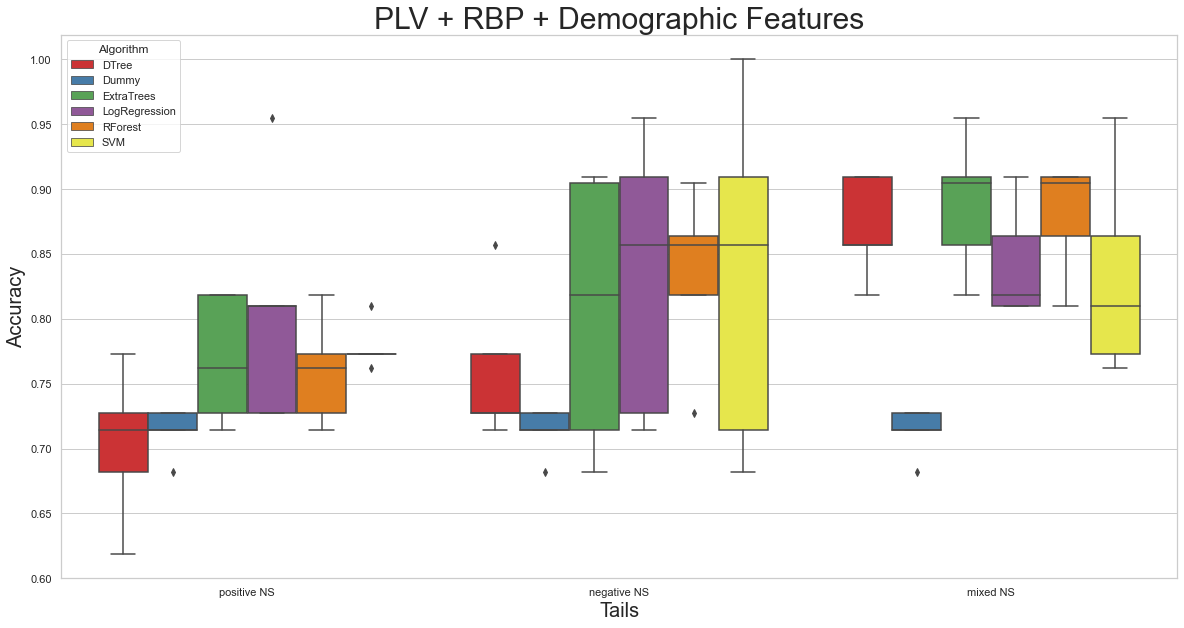

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_pos_PLV_RBP = pd.DataFrame.from_dict(PLV_RBP_outer_scores_pos).assign(Features="positive NS")
df_neg_PLV_RBP = pd.DataFrame.from_dict(PLV_RBP_outer_scores_neg).assign(Features="negative NS")
df_mix_PLV_RBP = pd.DataFrame.from_dict(PLV_RBP_outer_scores_mix).assign(Features="mixed NS")

cdf_PLV_RBP = pd.concat([df_pos_PLV_RBP, df_neg_PLV_RBP, df_mix_PLV_RBP]) 
mdf_PLV_RBP = pd.melt(cdf_PLV_RBP, id_vars=['Features'], var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)

a = sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf_PLV_RBP, palette='Set1')  # RUN PLOT  
a.set_title("PLV + RBP + Demographic Features", fontsize = 30)
a.set_xlabel("Tails", fontsize = 20)
a.set_ylabel("Accuracy", fontsize = 20)

#plt.legend(bbox_to_anchor=(1, 0.6))
#sns.set(rc = {'figure.figsize':(10,5)})
#sns.show()

##### Plotting an example of a confusion matrix

<AxesSubplot:>

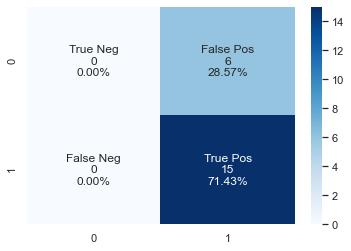

In [538]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test_PLV_RBP_cv, gridcvs["RForest"].best_estimator_.predict(X_test_pos_PLV_RBP_NoCov))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## ROC-AUC comparison for the positive tail: 

Text(0.5, 0.98, 'Positive Tail')

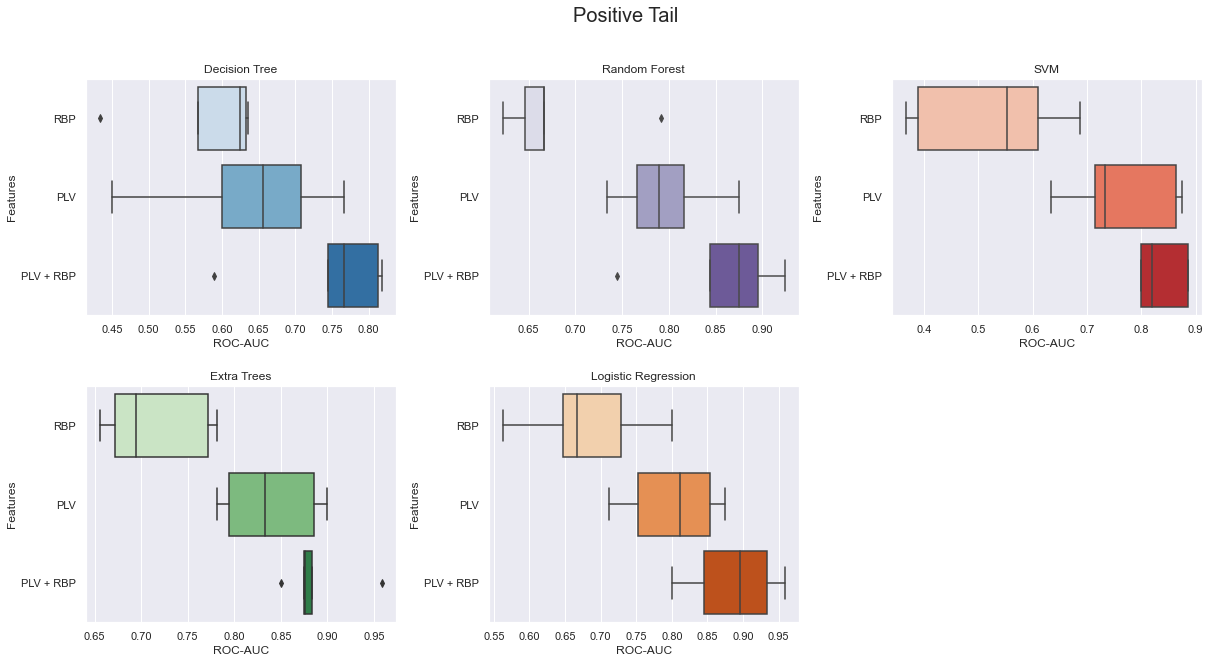

In [491]:
cols = ['ROC-AUC', 'Features']
features = ['RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP']

df_roc_rforest_pos = pd.DataFrame(columns=cols)
df_roc_rforest_pos['ROC-AUC'] = RBP_outer_roc_scores_pos['RForest'] + outer_roc_scores_pos['RForest'] + PLV_RBP_outer_roc_scores_pos['RForest']
df_roc_rforest_pos['Features'] = features

df_roc_dtree_pos = pd.DataFrame(columns=cols)
df_roc_dtree_pos['ROC-AUC'] = RBP_outer_roc_scores_pos['DTree'] + outer_roc_scores_pos['DTree'] + PLV_RBP_outer_roc_scores_pos['DTree']
df_roc_dtree_pos['Features'] = features

df_roc_svm_pos = pd.DataFrame(columns=cols)
df_roc_svm_pos['ROC-AUC'] = RBP_outer_roc_scores_pos['SVM'] + outer_roc_scores_pos['SVM'] + PLV_RBP_outer_roc_scores_pos['SVM']
df_roc_svm_pos['Features'] = features

df_roc_extratrees_pos = pd.DataFrame(columns=cols)
df_roc_extratrees_pos['ROC-AUC'] = RBP_outer_roc_scores_pos['ExtraTrees'] + outer_roc_scores_pos['ExtraTrees'] + PLV_RBP_outer_roc_scores_pos['ExtraTrees']
df_roc_extratrees_pos['Features'] = features

df_roc_logregression_pos = pd.DataFrame(columns=cols)
df_roc_logregression_pos['ROC-AUC'] = RBP_outer_roc_scores_pos['LogRegression'] + outer_roc_scores_pos['LogRegression'] + PLV_RBP_outer_roc_scores_pos['LogRegression']
df_roc_logregression_pos['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.3)

sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_pos, ax=axes[0,0], palette="Blues")
axes[0,0].title.set_text('Decision Tree')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_pos, ax=axes[0,1], palette="Purples")
axes[0,1].title.set_text('Random Forest')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_pos, ax=axes[0,2], palette="Reds")
axes[0,2].title.set_text('SVM')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_pos, ax=axes[1,0], palette="Greens")
axes[1,0].title.set_text('Extra Trees')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_pos, ax=axes[1,1], palette="Oranges")
axes[1,1].title.set_text('Logistic Regression')

fig.delaxes(axes[1,2])
fig.suptitle('Positive Tail', fontsize=20)

## ROC-AUC comparison for the negative tail: 

Text(0.5, 0.98, 'Negative Tail')

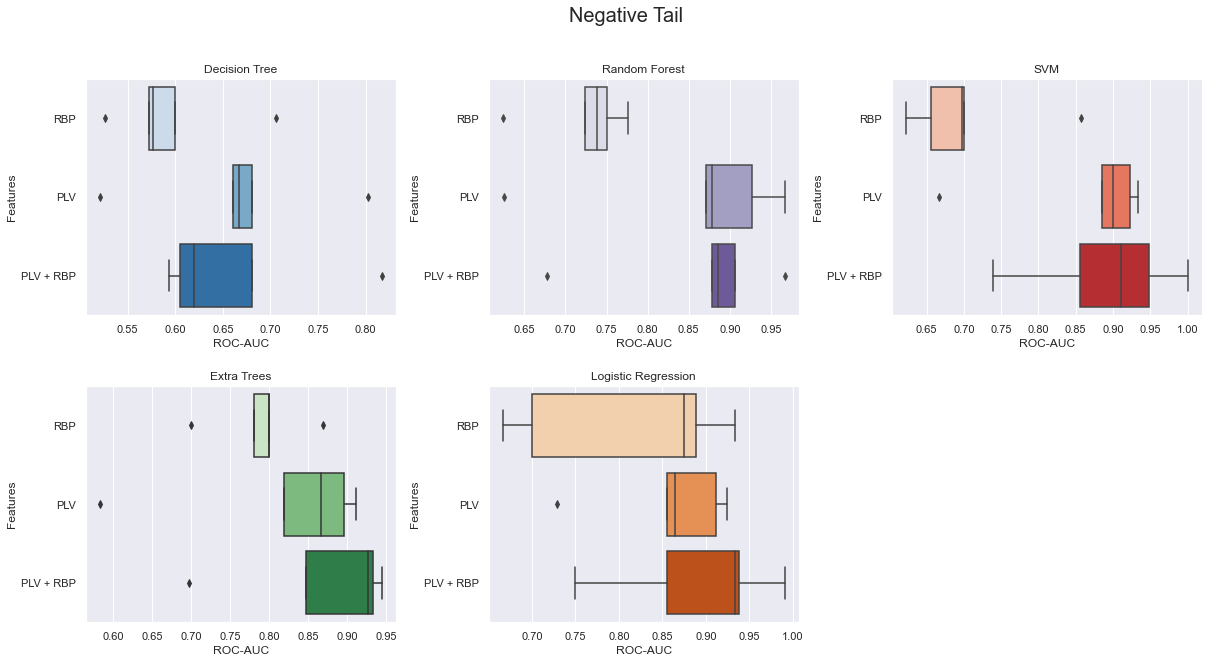

In [493]:
cols = ['ROC-AUC', 'Features']
features = ['RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP']

df_roc_rforest_neg = pd.DataFrame(columns=cols)
df_roc_rforest_neg['ROC-AUC'] = RBP_outer_roc_scores_neg['RForest'] + outer_roc_scores_neg['RForest'] + PLV_RBP_outer_roc_scores_neg['RForest']
df_roc_rforest_neg['Features'] = features

df_roc_dtree_neg = pd.DataFrame(columns=cols)
df_roc_dtree_neg['ROC-AUC'] = RBP_outer_roc_scores_neg['DTree'] + outer_roc_scores_neg['DTree'] + PLV_RBP_outer_roc_scores_neg['DTree']
df_roc_dtree_neg['Features'] = features

df_roc_svm_neg = pd.DataFrame(columns=cols)
df_roc_svm_neg['ROC-AUC'] = RBP_outer_roc_scores_neg['SVM'] + outer_roc_scores_neg['SVM'] + PLV_RBP_outer_roc_scores_neg['SVM']
df_roc_svm_neg['Features'] = features

df_roc_extratrees_neg = pd.DataFrame(columns=cols)
df_roc_extratrees_neg['ROC-AUC'] = RBP_outer_roc_scores_neg['ExtraTrees'] + outer_roc_scores_neg['ExtraTrees'] + PLV_RBP_outer_roc_scores_neg['ExtraTrees']
df_roc_extratrees_neg['Features'] = features

df_roc_logregression_neg = pd.DataFrame(columns=cols)
df_roc_logregression_neg['ROC-AUC'] = RBP_outer_roc_scores_neg['LogRegression'] + outer_roc_scores_neg['LogRegression'] + PLV_RBP_outer_roc_scores_neg['LogRegression']
df_roc_logregression_neg['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.3)

sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_neg, ax=axes[0,0], palette="Blues")
axes[0,0].title.set_text('Decision Tree')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_neg, ax=axes[0,1], palette="Purples")
axes[0,1].title.set_text('Random Forest')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_neg, ax=axes[0,2], palette="Reds")
axes[0,2].title.set_text('SVM')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_neg, ax=axes[1,0], palette="Greens")
axes[1,0].title.set_text('Extra Trees')
sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_neg, ax=axes[1,1], palette="Oranges")
axes[1,1].title.set_text('Logistic Regression')

fig.delaxes(axes[1,2])
fig.suptitle('Negative Tail', fontsize=20)

## ROC-AUC comparison for the mixed tail: 

Text(0.5, 0.98, 'Mixed Tail (Positive - Negative)')

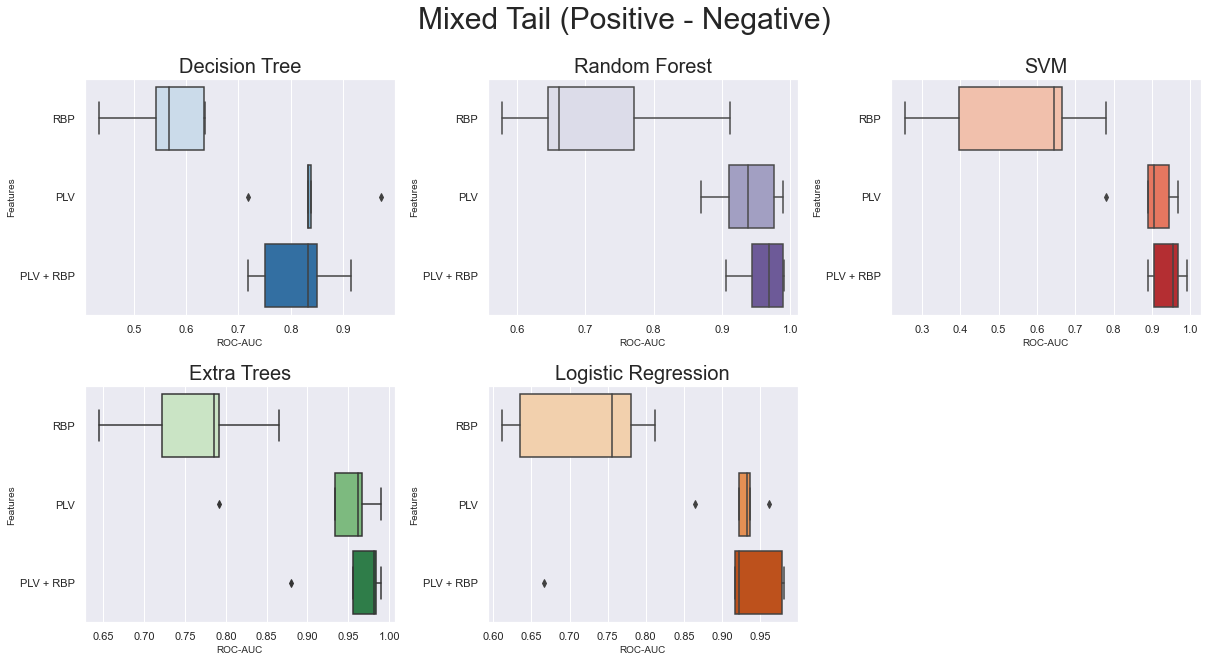

In [188]:
cols = ['ROC-AUC', 'Features']
features = ['RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP']

df_roc_rforest = pd.DataFrame(columns=cols)
df_roc_rforest['ROC-AUC'] = RBP_outer_roc_scores_mix['RForest'] + outer_roc_scores_mix['RForest'] + PLV_RBP_outer_roc_scores_mix['RForest']
df_roc_rforest['Features'] = features

df_roc_dtree = pd.DataFrame(columns=cols)
df_roc_dtree['ROC-AUC'] = RBP_outer_roc_scores_mix['DTree'] + outer_roc_scores_mix['DTree'] + PLV_RBP_outer_roc_scores_mix['DTree']
df_roc_dtree['Features'] = features

df_roc_svm = pd.DataFrame(columns=cols)
df_roc_svm['ROC-AUC'] = RBP_outer_roc_scores_mix['SVM'] + outer_roc_scores_mix['SVM'] + PLV_RBP_outer_roc_scores_mix['SVM']
df_roc_svm['Features'] = features

df_roc_extratrees = pd.DataFrame(columns=cols)
df_roc_extratrees['ROC-AUC'] = RBP_outer_roc_scores_mix['ExtraTrees'] + outer_roc_scores_mix['ExtraTrees'] + PLV_RBP_outer_roc_scores_mix['ExtraTrees']
df_roc_extratrees['Features'] = features

df_roc_logregression = pd.DataFrame(columns=cols)
df_roc_logregression['ROC-AUC'] = RBP_outer_roc_scores_mix['LogRegression'] + outer_roc_scores_mix['LogRegression'] + PLV_RBP_outer_roc_scores_mix['LogRegression']
df_roc_logregression['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(20,10))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.3)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize=20)
a.set_xlabel("ROC-AUC", fontsize=10)
a.set_ylabel("Features", fontsize=10)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize=20)
b.set_xlabel("ROC-AUC", fontsize=10)
b.set_ylabel("Features", fontsize=10)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm, ax=axes[0,2], palette="Reds")
axes[0,2].set_title('SVM', fontsize=20)
c.set_xlabel("ROC-AUC", fontsize=10)
c.set_ylabel("Features", fontsize=10)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees, ax=axes[1,0], palette="Greens")
axes[1,0].set_title('Extra Trees', fontsize=20)
d.set_xlabel("ROC-AUC", fontsize=10)
d.set_ylabel("Features", fontsize=10)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression, ax=axes[1,1], palette="Oranges")
axes[1,1].set_title('Logistic Regression', fontsize=20)
e.set_xlabel("ROC-AUC", fontsize=10)
e.set_ylabel("Features", fontsize=10)

fig.delaxes(axes[1,2])
fig.suptitle('Mixed Tail (Positive - Negative)', fontsize=30)

# Training our models without including the demographics:

## PLV Features:

### Positive features:
<a id="PLV_pos"></a>

In [84]:
brain_regions = 210
p_thresh = 0.05

NoCov_outer_scores_pos = {}
NoCov_outer_roc_scores_pos = {}
NoCov_specificity_pos = {}
NoCov_sensitivity_pos = {}
NoCov_precision_pos = {}
NoCov_f1_pos = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    NoCov_outer_scores_pos['{}'.format(name)] = []
    NoCov_outer_roc_scores_pos['{}'.format(name)] = []
    NoCov_specificity_pos['{}'.format(name)] = []
    NoCov_sensitivity_pos['{}'.format(name)] = []
    NoCov_precision_pos['{}'.format(name)] = []
    NoCov_f1_pos['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        X_train_pos_NoCov = X_train.copy(deep = True)
        pos_mask_train, neg_mask_train, pos_NS_train, neg_NS_train, mix_NS_train = ccf_train(X_train, y_train, brain_regions, p_thresh)
        X_train_pos_NoCov.drop(columns=X_train_pos_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_pos_NoCov.loc[:, 'Positive NS band 1'] = pos_NS_train.band1
        X_train_pos_NoCov.loc[:, 'Positive NS band 2'] = pos_NS_train.band2
        X_train_pos_NoCov.loc[:, 'Positive NS band 3'] = pos_NS_train.band3
        X_train_pos_NoCov.loc[:, 'Positive NS band 4'] = pos_NS_train.band4
        X_train_pos_NoCov.loc[:, 'Positive NS band 5'] = pos_NS_train.band5
        
        X_train_pos_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_pos_NoCov.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_cv = X_train.iloc[valid_idx]
        y_test_cv = y_train.iloc[valid_idx]
        
        X_test_pos_NoCov = X_test_cv.copy(deep = True)
        pos_NS_test, neg_NS_test, mix_NS_test = ccf_test(X_test_cv, y_test_cv, brain_regions, pos_mask_train, neg_mask_train)
        X_test_pos_NoCov.drop(columns=X_test_pos_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_pos_NoCov.loc[:, 'Positive NS band 1'] = pos_NS_test.band1
        X_test_pos_NoCov.loc[:, 'Positive NS band 2'] = pos_NS_test.band2
        X_test_pos_NoCov.loc[:, 'Positive NS band 3'] = pos_NS_test.band3
        X_test_pos_NoCov.loc[:, 'Positive NS band 4'] = pos_NS_test.band4
        X_test_pos_NoCov.loc[:, 'Positive NS band 5'] = pos_NS_test.band5
        
        X_test_pos_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        NoCov_outer_roc_scores_pos['{}'.format(name)].append(roc_auc_score(y_test_cv, gridcvs[name].best_estimator_.predict_proba(X_test_pos_NoCov)[:,1]))
        NoCov_outer_scores_pos['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_pos_NoCov, y_test_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_pos_NoCov)).ravel()
        NoCov_sensitivity_pos['{}'.format(name)].append(tp / (tp+fn))
        NoCov_specificity_pos['{}'.format(name)].append(tn / (tn+fp))
        NoCov_precision_pos['{}'.format(name)].append(tp / (tp+fp))
        NoCov_f1_pos['{}'.format(name)].append(2*(NoCov_sensitivity_pos['{}'.format(name)][-1] * NoCov_precision_pos['{}'.format(name)][-1])/(NoCov_sensitivity_pos['{}'.format(name)][-1] + NoCov_precision_pos['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (NoCov_outer_scores_pos['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (NoCov_outer_roc_scores_pos['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (NoCov_specificity_pos['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (NoCov_sensitivity_pos['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (NoCov_precision_pos['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (NoCov_f1_pos['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_pos_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(NoCov_outer_scores_pos['{}'.format(name)]) * 100, np.std(NoCov_outer_scores_pos['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(NoCov_outer_roc_scores_pos['{}'.format(name)]), np.std(NoCov_outer_roc_scores_pos['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(NoCov_specificity_pos['{}'.format(name)]), np.std(NoCov_specificity_pos['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(NoCov_sensitivity_pos['{}'.format(name)]), np.std(NoCov_sensitivity_pos['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(NoCov_precision_pos['{}'.format(name)]), np.std(NoCov_precision_pos['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(NoCov_f1_pos['{}'.format(name)]), np.std(NoCov_f1_pos['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.09%
        Best parameters: {'criterion': 'entropy', 'max_depth': 3}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.79
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 1  5]
 [ 1 15]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.09%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 74.82%
        Best parameters: {'n_estimators': 100}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.79
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.88
        Confusion matrix: 
[[ 2  4]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.87%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.78
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fo

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 77.91%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.80
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.78
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 2  4]
 [ 2 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'clf1__C': 0.5, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer t

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 79.39%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.64
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 1  5]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 79.39%
        Best parameters: {'clf1__C': 0.5, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer t

### Negative features: 
<a id="PLV_neg"></a>

In [85]:
brain_regions = 210
p_thresh = 0.05

NoCov_outer_scores_neg = {}
NoCov_outer_roc_scores_neg = {}
NoCov_specificity_neg = {}
NoCov_sensitivity_neg = {}
NoCov_precision_neg = {}
NoCov_f1_neg = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    NoCov_outer_scores_neg['{}'.format(name)] = []
    NoCov_outer_roc_scores_neg['{}'.format(name)] = []
    NoCov_specificity_neg['{}'.format(name)] = []
    NoCov_sensitivity_neg['{}'.format(name)] = []
    NoCov_precision_neg['{}'.format(name)] = []
    NoCov_f1_neg['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        X_train_neg_NoCov = X_train.copy(deep = True)
        pos_mask_train, neg_mask_train, pos_NS_train, neg_NS_train, mix_NS_train = ccf_train(X_train, y_train, brain_regions, p_thresh)
        X_train_neg_NoCov.drop(columns=X_train_neg_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_neg_NoCov.loc[:, 'Negative NS band 1'] = neg_NS_train.band1
        X_train_neg_NoCov.loc[:, 'Negative NS band 2'] = neg_NS_train.band2
        X_train_neg_NoCov.loc[:, 'Negative NS band 3'] = neg_NS_train.band3
        X_train_neg_NoCov.loc[:, 'Negative NS band 4'] = neg_NS_train.band4
        X_train_neg_NoCov.loc[:, 'Negative NS band 5'] = neg_NS_train.band5
        
        X_train_neg_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_neg_NoCov.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_cv = X_train.iloc[valid_idx]
        y_test_cv = y_train.iloc[valid_idx]
        
        X_test_neg_NoCov = X_test_cv.copy(deep = True)
        pos_NS_test, neg_NS_test, mix_NS_test = ccf_test(X_test_cv, y_test_cv, brain_regions, pos_mask_train, neg_mask_train)
        X_test_neg_NoCov.drop(columns=X_test_neg_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_neg_NoCov.loc[:, 'Negative NS band 1'] = neg_NS_test.band1
        X_test_neg_NoCov.loc[:, 'Negative NS band 2'] = neg_NS_test.band2
        X_test_neg_NoCov.loc[:, 'Negative NS band 3'] = neg_NS_test.band3
        X_test_neg_NoCov.loc[:, 'Negative NS band 4'] = neg_NS_test.band4
        X_test_neg_NoCov.loc[:, 'Negative NS band 5'] = neg_NS_test.band5
        
        X_test_neg_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        NoCov_outer_roc_scores_neg['{}'.format(name)].append(roc_auc_score(y_test_cv, gridcvs[name].best_estimator_.predict_proba(X_test_neg_NoCov)[:,1]))
        NoCov_outer_scores_neg['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_neg_NoCov, y_test_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_neg_NoCov)).ravel()
        NoCov_sensitivity_neg['{}'.format(name)].append(tp / (tp+fn))
        NoCov_specificity_neg['{}'.format(name)].append(tn / (tn+fp))
        NoCov_precision_neg['{}'.format(name)].append(tp / (tp+fp))
        NoCov_f1_neg['{}'.format(name)].append(2*(NoCov_sensitivity_pos['{}'.format(name)][-1] * NoCov_precision_neg['{}'.format(name)][-1])/(NoCov_sensitivity_neg['{}'.format(name)][-1] + NoCov_precision_neg['{}'.format(name)][-1]))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (NoCov_outer_scores_neg['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (NoCov_outer_roc_scores_neg['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (NoCov_specificity_neg['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (NoCov_sensitivity_neg['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (NoCov_precision_neg['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (NoCov_f1_neg['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_test_neg_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(NoCov_outer_scores_neg['{}'.format(name)]) * 100, np.std(NoCov_outer_scores_neg['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(NoCov_outer_roc_scores_neg['{}'.format(name)]), np.std(NoCov_outer_roc_scores_neg['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(NoCov_specificity_neg['{}'.format(name)]), np.std(NoCov_specificity_neg['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(NoCov_sensitivity_neg['{}'.format(name)]), np.std(NoCov_sensitivity_neg['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(NoCov_precision_neg['{}'.format(name)]), np.std(NoCov_precision_neg['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(NoCov_f1_neg['{}'.format(name)]), np.std(NoCov_f1_neg['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 80.23%
        Best parameters: {'criterion': 'entropy', 'max_depth': 3}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer test fold) 0.52
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.80
        F1-Score (on outer test fold) 0.77
        Confusion matrix: 
[[ 2  4]
 [ 0 16]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.57%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.98
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.83
        F1-Score (on outer test fold) 0.91
        Confusion matrix: 
[[ 3  3]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.44%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.48%
        ROC-AUC (on outer test fold) 0.94
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fol

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.61%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.89
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.81
        F1-Score (on outer test fold) 0.97
        Confusion matrix: 
[[ 3  3]
 [ 2 13]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.65%
        Best parameters: {'clf1__C': 0.8, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer t

###  Mixed features:
<a id="PLV_mix"></a>

In [86]:
brain_regions = 210
p_thresh = 0.05

NoCov_outer_scores_mix = {}
NoCov_outer_roc_scores_mix = {}
NoCov_specificity_mix = {}
NoCov_sensitivity_mix = {}
NoCov_precision_mix = {}
NoCov_f1_mix = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    NoCov_outer_scores_mix['{}'.format(name)] = []
    NoCov_outer_roc_scores_mix['{}'.format(name)] = []
    NoCov_specificity_mix['{}'.format(name)] = []
    NoCov_sensitivity_mix['{}'.format(name)] = []
    NoCov_precision_mix['{}'.format(name)] = []
    NoCov_f1_mix['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        X_train_mix_NoCov = X_train.copy(deep = True)
        pos_mask_train, neg_mask_train, pos_NS_train, neg_NS_train, mix_NS_train = ccf_train(X_train, y_train, brain_regions, p_thresh)
        X_train_mix_NoCov.drop(columns=X_train_mix_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_mix_NoCov.loc[:, 'Negative NS band 1'] = mix_NS_train.band1
        X_train_mix_NoCov.loc[:, 'Negative NS band 2'] = mix_NS_train.band2
        X_train_mix_NoCov.loc[:, 'Negative NS band 3'] = mix_NS_train.band3
        X_train_mix_NoCov.loc[:, 'Negative NS band 4'] = mix_NS_train.band4
        X_train_mix_NoCov.loc[:, 'Negative NS band 5'] = mix_NS_train.band5
        
        X_train_mix_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_mix_NoCov.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_cv = X_train.iloc[valid_idx]
        y_test_cv = y_train.iloc[valid_idx]
        
        X_train_mix_NoCov = X_test_cv.copy(deep = True)
        pos_NS_test, neg_NS_test, mix_NS_test = ccf_test(X_test_cv, y_test_cv, brain_regions, pos_mask_train, neg_mask_train)
        X_train_mix_NoCov.drop(columns=X_train_mix_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_mix_NoCov.loc[:, 'Mixed NS band 1'] = mix_NS_test.band1
        X_train_mix_NoCov.loc[:, 'Mixed NS band 2'] = mix_NS_test.band2
        X_train_mix_NoCov.loc[:, 'Mixed NS band 3'] = mix_NS_test.band3
        X_train_mix_NoCov.loc[:, 'Mixed NS band 4'] = mix_NS_test.band4
        X_train_mix_NoCov.loc[:, 'Mixed NS band 5'] = mix_NS_test.band5
        
        X_train_mix_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        NoCov_outer_roc_scores_mix['{}'.format(name)].append(roc_auc_score(y_test_cv, gridcvs[name].best_estimator_.predict_proba(X_train_mix_NoCov)[:,1]))
        NoCov_outer_scores_mix['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_train_mix_NoCov, y_test_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_train_mix_NoCov)).ravel()
        NoCov_sensitivity_mix['{}'.format(name)].append(tp / (tp+fn))
        NoCov_specificity_mix['{}'.format(name)].append(tn / (tn+fp))
        NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))
        NoCov_f1_mix['{}'.format(name)].append((2*(NoCov_sensitivity_mix['{}'.format(name)][-1] * NoCov_precision_mix['{}'.format(name)][-1])/(NoCov_sensitivity_mix['{}'.format(name)][-1] + NoCov_precision_mix['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (NoCov_outer_scores_mix['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (NoCov_outer_roc_scores_mix['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (NoCov_specificity_mix['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (NoCov_sensitivity_mix['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (NoCov_precision_mix['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (NoCov_f1_mix['{}'.format(name)][-1]))                                       
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_cv, gridcvs[name].best_estimator_.predict(X_train_mix_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(NoCov_outer_scores_mix['{}'.format(name)]) * 100, np.std(NoCov_outer_scores_mix['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(NoCov_outer_roc_scores_mix['{}'.format(name)]), np.std(NoCov_outer_roc_scores_mix['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(NoCov_specificity_mix['{}'.format(name)]), np.std(NoCov_specificity_mix['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(NoCov_sensitivity_mix['{}'.format(name)]), np.std(NoCov_sensitivity_mix['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(NoCov_precision_mix['{}'.format(name)]), np.std(NoCov_precision_mix['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(NoCov_f1_mix['{}'.format(name)]), np.std(NoCov_f1_mix['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 81.82%
        ROC-AUC (on outer test fold) 0.72
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.83
        F1-Score (on outer test fold) 0.88
        Confusion matrix: 
[[ 3  3]
 [ 1 15]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 87.21%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.91%
       


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 85.15%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.97
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.83
        F1-Score (on outer test fold) 0.91
        Confusion matrix: 
[[ 3  3]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 87.42%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.86
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fol


        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 83.72%
        Best parameters: {'clf4__C': 0.1, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 90.91%
        ROC-AUC (on outer test fold) 0.97
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.89
        F1-Score (on outer test fold) 0.94
        Confusion matrix: 
[[ 4  2]
 [ 0 16]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 87.21%
        Best parameters: {'clf4__C': 0.8, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 86.36%
        ROC-AUC (on outer test fold) 0.92
        Specificity (on outer test fold) 

##### Plotting boxplots of the accuracies of all different algorithms in the case of positive, negative and mixed tails of the connectivity features without the demographics

No handles with labels found to put in legend.


Text(0, 0.5, 'Accuracy')

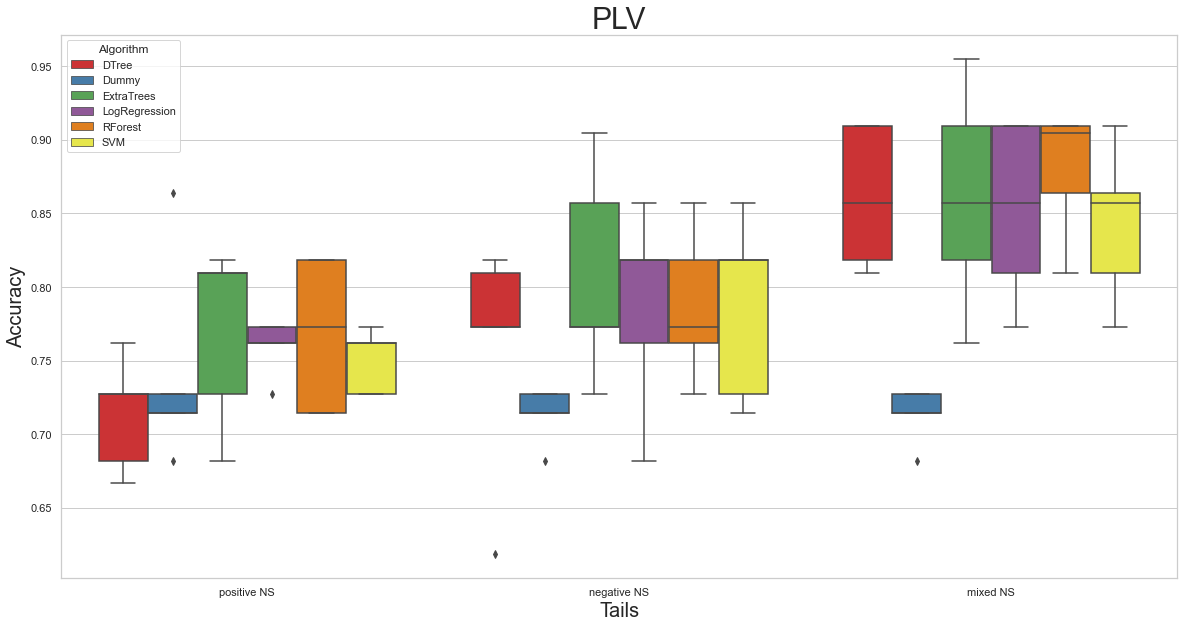

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_pos_NoCov = pd.DataFrame.from_dict(NoCov_outer_scores_pos).assign(Features="positive NS")
df_neg_NoCov = pd.DataFrame.from_dict(NoCov_outer_scores_neg).assign(Features="negative NS")
df_mix_NoCov = pd.DataFrame.from_dict(NoCov_outer_scores_mix).assign(Features="mixed NS")

cdf = pd.concat([df_pos_NoCov, df_neg_NoCov, df_mix_NoCov]) 
mdf = pd.melt(cdf, id_vars=['Features'], var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)
plt.title("Accuracy")
#sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf, palette='Set1')  # RUN PLOT  

a = sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf, palette='Set1')  # RUN PLOT  
a.set_title("PLV", fontsize = 30)
a.set_xlabel("Tails", fontsize = 20)
a.set_ylabel("Accuracy", fontsize = 20)


#plt.legend(bbox_to_anchor=(1, 0.6))
#sns.set(rc = {'figure.figsize':(10,5)})
#sns.show()

Text(0.5, 0.98, 'Positive Tail')

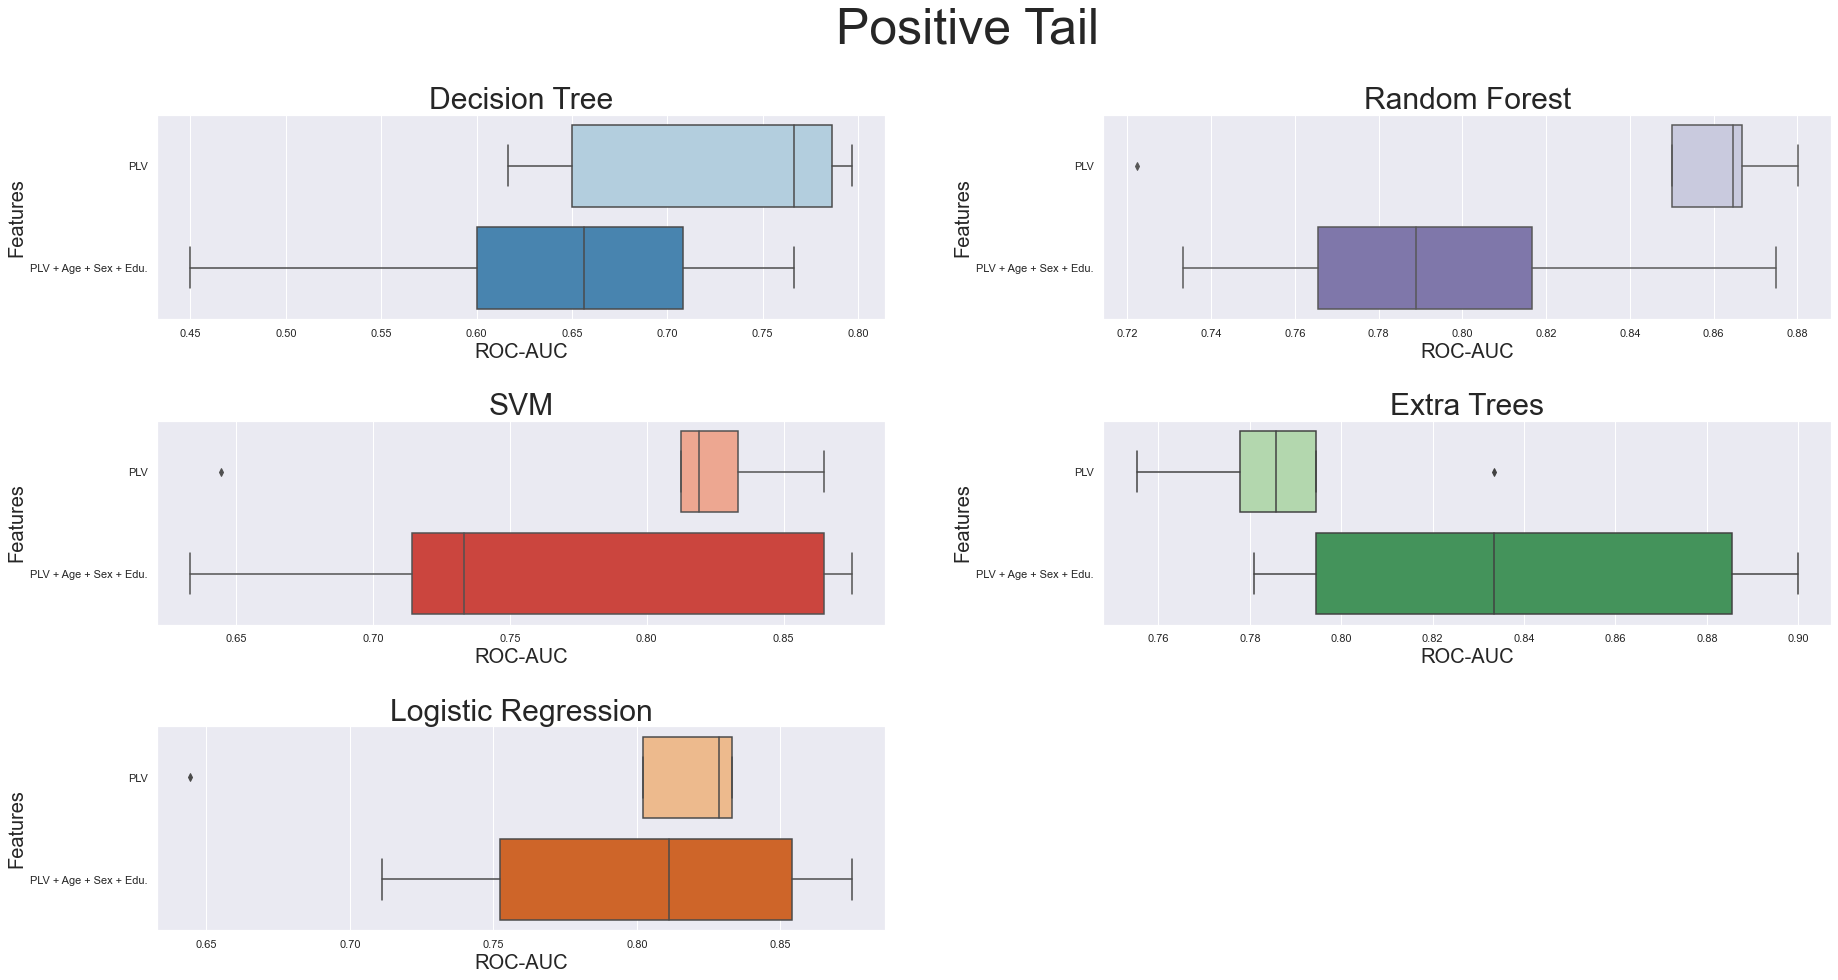

In [154]:
cols = ['ROC-AUC', 'Features']
features = ['PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.','PLV + Age + Sex + Edu.']

df_roc_rforest_NoCov_pos_PLV = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_pos_PLV['ROC-AUC'] = NoCov_outer_roc_scores_pos['RForest'] + outer_roc_scores_pos['RForest']
df_roc_rforest_NoCov_pos_PLV['Features'] = features

df_roc_dtree_NoCov_pos_PLV = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_pos_PLV['ROC-AUC'] = NoCov_outer_roc_scores_pos['DTree'] + outer_roc_scores_pos['DTree']
df_roc_dtree_NoCov_pos_PLV['Features'] = features

df_roc_svm_NoCov_pos_PLV = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_pos_PLV['ROC-AUC'] = NoCov_outer_roc_scores_pos['SVM'] + outer_roc_scores_pos['SVM']
df_roc_svm_NoCov_pos_PLV['Features'] = features

df_roc_extratrees_NoCov_pos_PLV = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_pos_PLV['ROC-AUC'] = NoCov_outer_roc_scores_pos['ExtraTrees'] + outer_roc_scores_pos['ExtraTrees']
df_roc_extratrees_NoCov_pos_PLV['Features'] = features

df_roc_logregression_NoCov_pos_PLV = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_pos_PLV['ROC-AUC'] = NoCov_outer_roc_scores_pos['LogRegression'] + outer_roc_scores_pos['LogRegression']
df_roc_logregression_NoCov_pos_PLV['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_pos_PLV, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_pos_PLV, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_pos_PLV, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_pos_PLV, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_pos_PLV, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Positive Tail', fontsize=50)

Text(0.5, 0.98, 'Negative Tail')

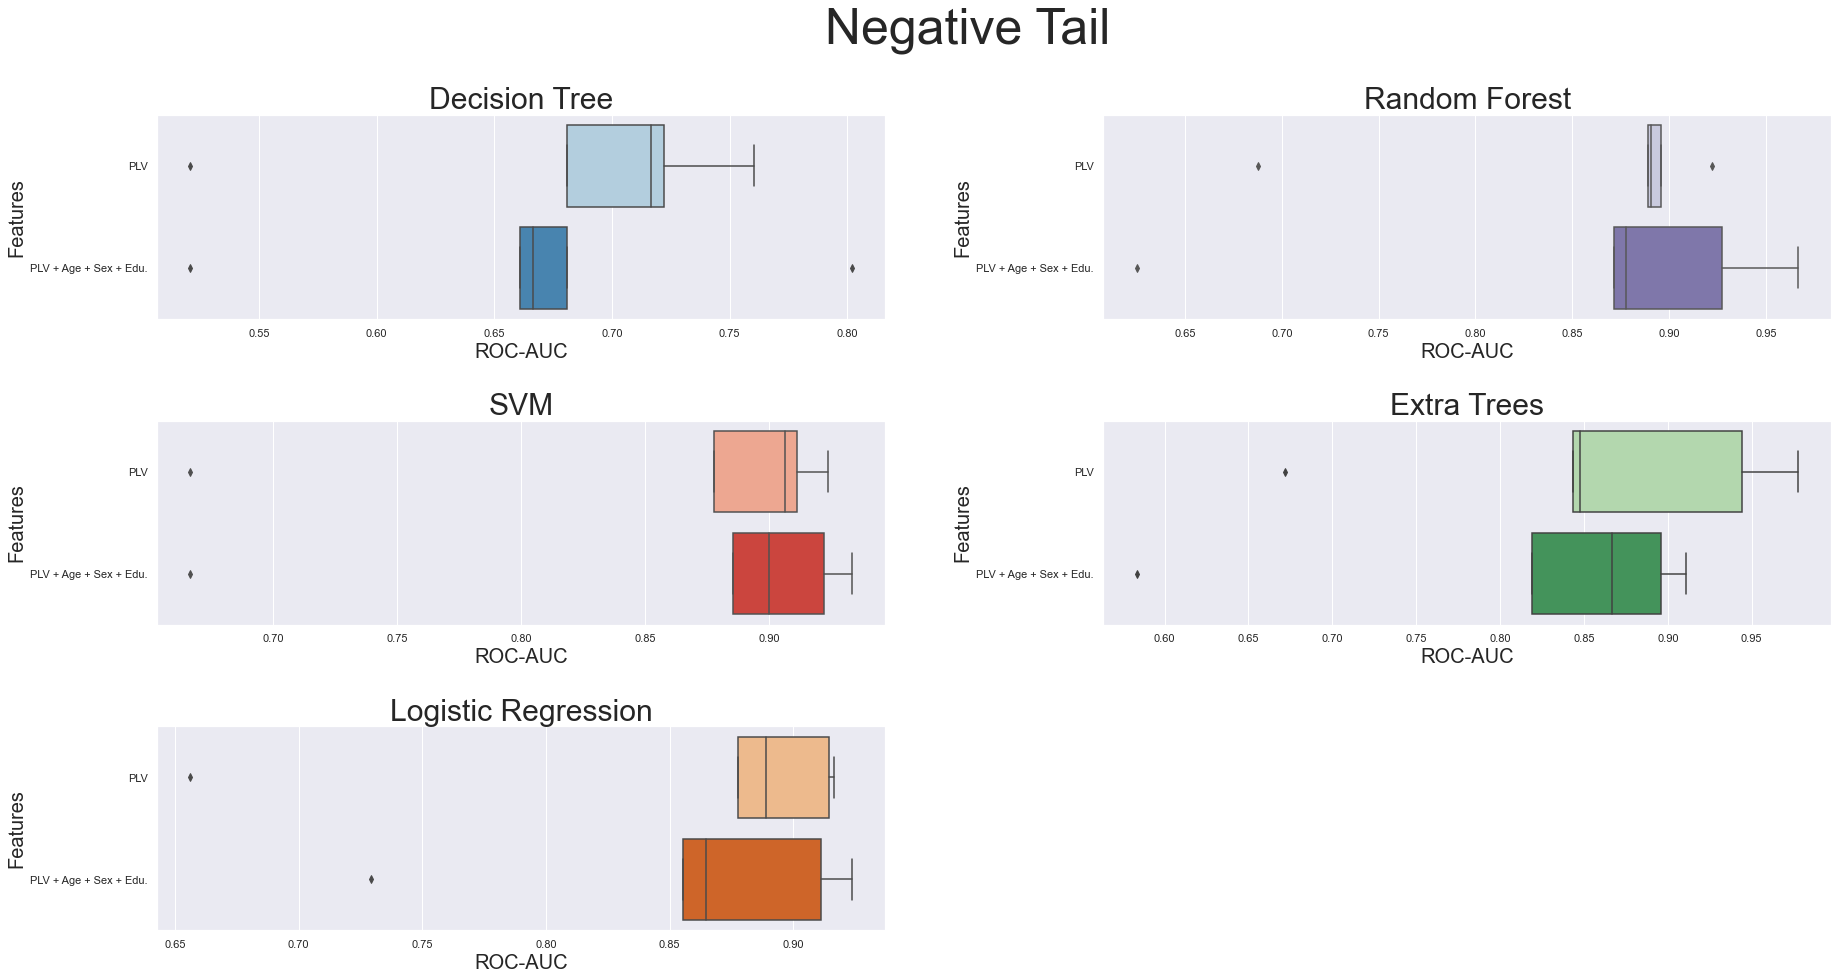

In [155]:
cols = ['ROC-AUC', 'Features']
features = ['PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.','PLV + Age + Sex + Edu.']

df_roc_rforest_NoCov_neg_PLV = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_neg_PLV['ROC-AUC'] = NoCov_outer_roc_scores_neg['RForest'] + outer_roc_scores_neg['RForest']
df_roc_rforest_NoCov_neg_PLV['Features'] = features

df_roc_dtree_NoCov_neg_PLV = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_neg_PLV['ROC-AUC'] = NoCov_outer_roc_scores_neg['DTree'] + outer_roc_scores_neg['DTree']
df_roc_dtree_NoCov_neg_PLV['Features'] = features

df_roc_svm_NoCov_neg_PLV = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_neg_PLV['ROC-AUC'] = NoCov_outer_roc_scores_neg['SVM'] + outer_roc_scores_neg['SVM']
df_roc_svm_NoCov_neg_PLV['Features'] = features

df_roc_extratrees_NoCov_neg_PLV = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_neg_PLV['ROC-AUC'] = NoCov_outer_roc_scores_neg['ExtraTrees'] + outer_roc_scores_neg['ExtraTrees']
df_roc_extratrees_NoCov_neg_PLV['Features'] = features

df_roc_logregression_NoCov_neg_PLV = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_neg_PLV['ROC-AUC'] = NoCov_outer_roc_scores_neg['LogRegression'] + outer_roc_scores_neg['LogRegression']
df_roc_logregression_NoCov_neg_PLV['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_neg_PLV, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_neg_PLV, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_neg_PLV, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_neg_PLV, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_neg_PLV, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Negative Tail', fontsize=50)

Text(0.5, 0.98, 'Mixed Tail')

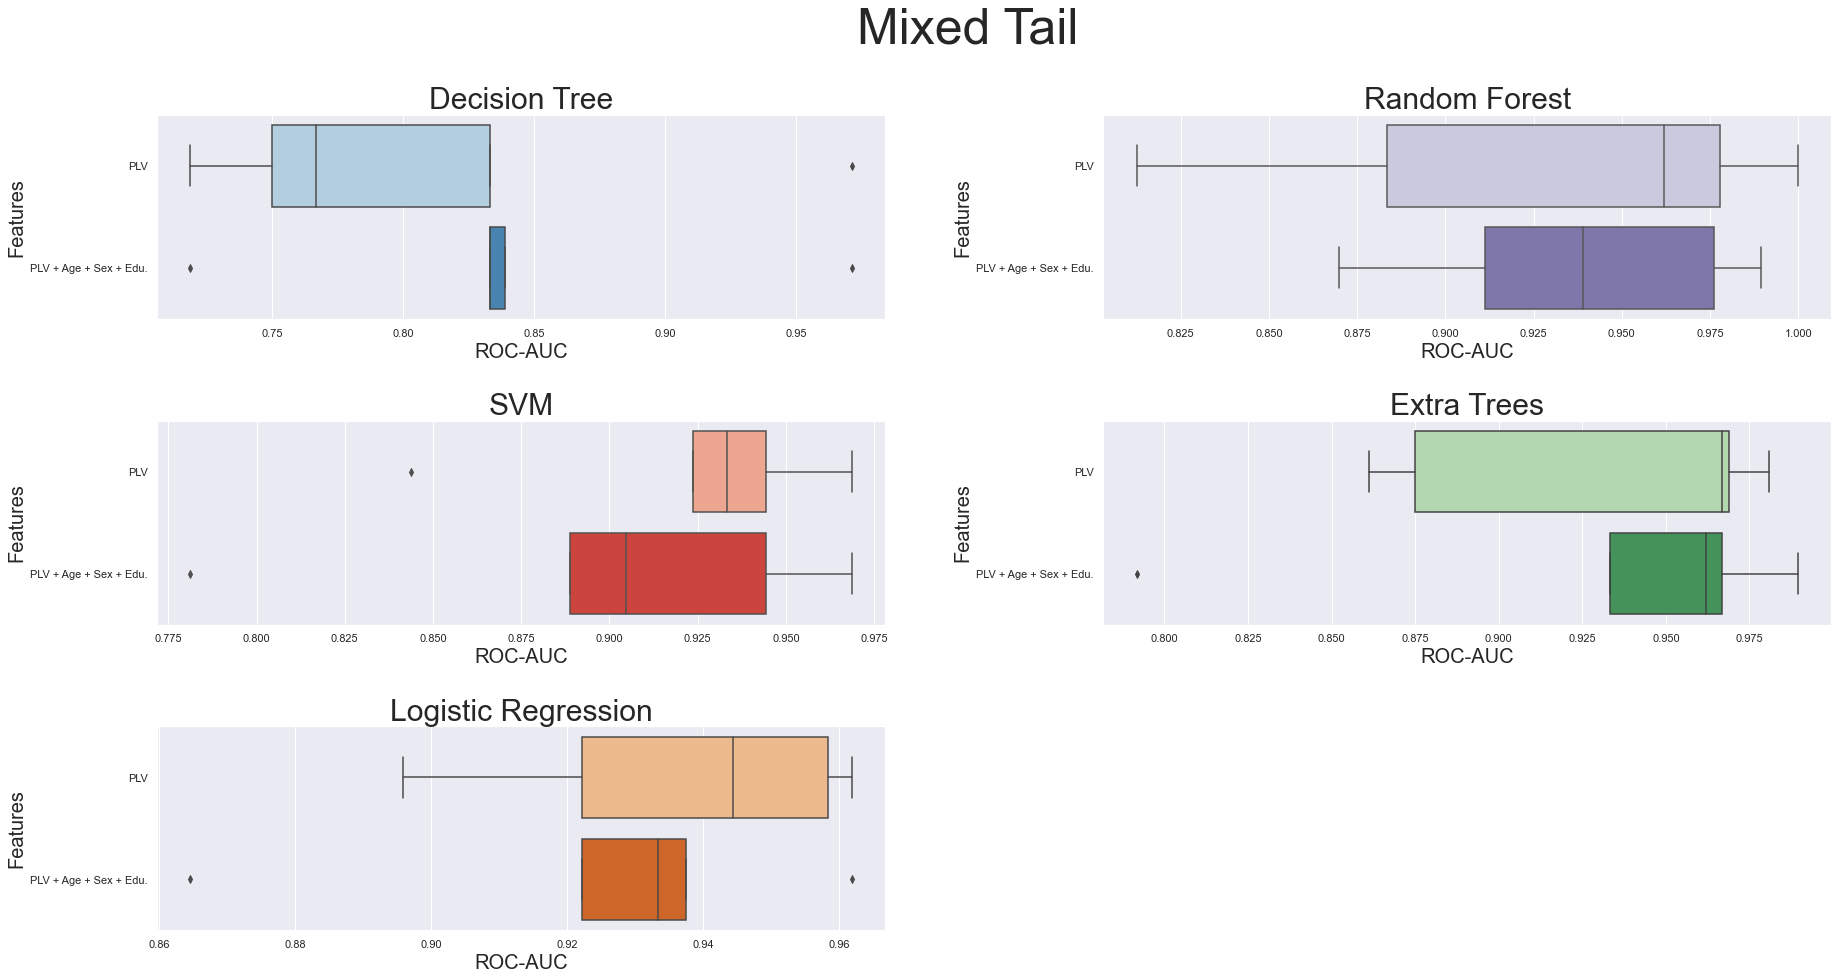

In [156]:
cols = ['ROC-AUC', 'Features']
features = ['PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.','PLV + Age + Sex + Edu.']

df_roc_rforest_NoCov_mix_PLV = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_mix_PLV['ROC-AUC'] = NoCov_outer_roc_scores_mix['RForest'] + outer_roc_scores_mix['RForest']
df_roc_rforest_NoCov_mix_PLV['Features'] = features

df_roc_dtree_NoCov_mix_PLV = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_mix_PLV['ROC-AUC'] = NoCov_outer_roc_scores_mix['DTree'] + outer_roc_scores_mix['DTree']
df_roc_dtree_NoCov_mix_PLV['Features'] = features

df_roc_svm_NoCov_mix_PLV = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_mix_PLV['ROC-AUC'] = NoCov_outer_roc_scores_mix['SVM'] + outer_roc_scores_mix['SVM']
df_roc_svm_NoCov_mix_PLV['Features'] = features

df_roc_extratrees_NoCov_mix_PLV = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_mix_PLV['ROC-AUC'] = NoCov_outer_roc_scores_mix['ExtraTrees'] + outer_roc_scores_mix['ExtraTrees']
df_roc_extratrees_NoCov_mix_PLV['Features'] = features

df_roc_logregression_NoCov_mix_PLV = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_mix_PLV['ROC-AUC'] = NoCov_outer_roc_scores_mix['LogRegression'] + outer_roc_scores_mix['LogRegression']
df_roc_logregression_NoCov_mix_PLV['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_mix_PLV, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_mix_PLV, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_mix_PLV, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_mix_PLV, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_mix_PLV, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Mixed Tail', fontsize=50)

## RBP Features:

### Positive features: 
<a id="RBP_pos"></a>

In [87]:
brain_regions = 210
p_thresh = 0.05

RBP_outer_scores_pos_NoCov = {}
RBP_outer_roc_scores_pos_NoCov = {}
RBP_specificity_pos_NoCov = {}
RBP_sensitivity_pos_NoCov = {}
RBP_precision_pos_NoCov = {}
RBP_f1_pos_NoCov = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    RBP_outer_scores_pos_NoCov['{}'.format(name)] = []
    RBP_outer_roc_scores_pos_NoCov['{}'.format(name)] = []
    RBP_specificity_pos_NoCov['{}'.format(name)] = []
    RBP_sensitivity_pos_NoCov['{}'.format(name)] = []
    RBP_precision_pos_NoCov['{}'.format(name)] = []
    RBP_f1_pos_NoCov['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train_RBP, y_train_RBP):
        
        X_train_pos_RBP_NoCov = X_train_RBP.copy(deep = True)
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_train_RBP, y_train_RBP, brain_regions, p_thresh)
        X_train_pos_RBP_NoCov.drop(columns=X_train_pos_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_pos_RBP_NoCov.loc[:, 'Positive NS band 1'] = pos_NS_train_RBP.band1
        X_train_pos_RBP_NoCov.loc[:, 'Positive NS band 2'] = pos_NS_train_RBP.band2
        X_train_pos_RBP_NoCov.loc[:, 'Positive NS band 3'] = pos_NS_train_RBP.band3
        X_train_pos_RBP_NoCov.loc[:, 'Positive NS band 4'] = pos_NS_train_RBP.band4
        X_train_pos_RBP_NoCov.loc[:, 'Positive NS band 5'] = pos_NS_train_RBP.band5
        
        X_train_pos_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_pos_RBP_NoCov.iloc[train_idx], y_train_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_RBP_cv = X_train_RBP.iloc[valid_idx]
        y_test_RBP_cv = y_train_RBP.iloc[valid_idx]
    
        X_test_pos_RBP_NoCov = X_test_RBP_cv.copy(deep = True)
        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_RBP_cv, y_test_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_pos_RBP_NoCov.drop(columns=X_test_pos_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_pos_RBP_NoCov.loc[:, 'Positive NS band 1'] = pos_NS_test_RBP.band1
        X_test_pos_RBP_NoCov.loc[:, 'Positive NS band 2'] = pos_NS_test_RBP.band2
        X_test_pos_RBP_NoCov.loc[:, 'Positive NS band 3'] = pos_NS_test_RBP.band3
        X_test_pos_RBP_NoCov.loc[:, 'Positive NS band 4'] = pos_NS_test_RBP.band4
        X_test_pos_RBP_NoCov.loc[:, 'Positive NS band 5'] = pos_NS_test_RBP.band5
        
        X_test_pos_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        RBP_outer_roc_scores_pos_NoCov['{}'.format(name)].append(roc_auc_score(y_test_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_pos_RBP_NoCov)[:,1]))
        RBP_outer_scores_pos_NoCov['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_pos_RBP_NoCov, y_test_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_RBP_NoCov)).ravel()
        RBP_sensitivity_pos_NoCov['{}'.format(name)].append(tp / (tp+fn))
        RBP_specificity_pos_NoCov['{}'.format(name)].append(tn / (tn+fp))
        RBP_precision_pos_NoCov['{}'.format(name)].append(tp / (tp+fp))
        RBP_f1_pos_NoCov['{}'.format(name)].append((2*(RBP_sensitivity_pos_NoCov['{}'.format(name)][-1] * RBP_precision_pos_NoCov['{}'.format(name)][-1])/(RBP_sensitivity_pos_NoCov['{}'.format(name)][-1] + RBP_precision_pos_NoCov['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (RBP_outer_scores_pos_NoCov['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (RBP_outer_roc_scores_pos_NoCov['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (RBP_specificity_pos_NoCov['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (RBP_sensitivity_pos_NoCov['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (RBP_precision_pos_NoCov['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (RBP_f1_pos_NoCov['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_RBP_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(RBP_outer_scores_pos_NoCov['{}'.format(name)]) * 100, np.std(RBP_outer_scores_pos_NoCov['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(RBP_outer_roc_scores_pos_NoCov['{}'.format(name)]), np.std(RBP_outer_roc_scores_pos_NoCov['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(RBP_specificity_pos_NoCov['{}'.format(name)]), np.std(RBP_specificity_pos_NoCov['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_pos_NoCov['{}'.format(name)]), np.std(RBP_sensitivity_pos_NoCov['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(RBP_precision_pos_NoCov['{}'.format(name)]), np.std(RBP_precision_pos_NoCov['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(RBP_f1_pos_NoCov['{}'.format(name)]), np.std(RBP_f1_pos_NoCov['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.62
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.73
        F1-Score (on outer test fold) 0.84
        Confusion matrix: 
[[ 0  6]
 [ 0 16]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'criterion': 'entropy', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 66.60%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 52.38%
        ROC-AUC (on outer test fold) 0.43
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.67
        Precision (on outer test fold) 0.67
        F1-Score (on outer test fold) 0.67
        Confusion matrix: 
[[ 1  5]
 [ 5 10]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 67.81%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 52.38%
        ROC-AUC (on outer test fold) 0.60
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fol

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.70
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.81
        Precision (on outer test fold) 0.76
        F1-Score (on outer test fold) 0.79
        Confusion matrix: 
[[ 2  4]
 [ 3 13]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.67
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 1  5]
 [ 1 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 72.09%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.44%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.82
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 1  5]
 [ 1 14]]

    Outer Loop:
        ACC 70.39% +/- 1.86
        ROC-AUC 0.71 +/- 0.07
        Specificity 0.17 +/- 0.11
        Sensitivity 0.92 +/- 0.06
        Precision 0.73 +/- 0.03
        F1-Score 0.82 +/- 0.02
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25

### Negative features: 
<a id="RBP_neg"></a>

In [166]:
brain_regions = 210
p_thresh = 0.05

RBP_outer_scores_neg_NoCov = {}
RBP_outer_roc_scores_neg_NoCov = {}
RBP_specificity_neg_NoCov = {}
RBP_sensitivity_neg_NoCov = {}
RBP_precision_neg_NoCov = {}
RBP_f1_neg_NoCov = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    RBP_outer_scores_neg_NoCov['{}'.format(name)] = []
    RBP_outer_roc_scores_neg_NoCov['{}'.format(name)] = []
    RBP_specificity_neg_NoCov['{}'.format(name)] = []
    RBP_sensitivity_neg_NoCov['{}'.format(name)] = []
    RBP_precision_neg_NoCov['{}'.format(name)] = []
    RBP_f1_neg_NoCov['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train_RBP, y_train_RBP):
        
        X_train_neg_RBP_NoCov = X_train_RBP.copy(deep = True)
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_train_RBP, y_train_RBP, brain_regions, p_thresh)
        X_train_neg_RBP_NoCov.drop(columns=X_train_neg_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_neg_RBP_NoCov.loc[:, 'Negative NS band 1'] = neg_NS_train_RBP.band1
        X_train_neg_RBP_NoCov.loc[:, 'Negative NS band 2'] = neg_NS_train_RBP.band2
        X_train_neg_RBP_NoCov.loc[:, 'Negative NS band 3'] = neg_NS_train_RBP.band3
        X_train_neg_RBP_NoCov.loc[:, 'Negative NS band 4'] = neg_NS_train_RBP.band4
        X_train_neg_RBP_NoCov.loc[:, 'Negative NS band 5'] = neg_NS_train_RBP.band5
        
        X_train_neg_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_neg_RBP_NoCov.iloc[train_idx], y_train_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_RBP_cv = X_train_RBP.iloc[valid_idx]
        y_test_RBP_cv = y_train_RBP.iloc[valid_idx]
    
        X_test_neg_RBP_NoCov = X_test_RBP_cv.copy(deep = True)
        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_RBP_cv, y_test_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_neg_RBP_NoCov.drop(columns=X_test_neg_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_neg_RBP_NoCov.loc[:, 'Negative NS band 1'] = neg_NS_test_RBP.band1
        X_test_neg_RBP_NoCov.loc[:, 'Negative NS band 2'] = neg_NS_test_RBP.band2
        X_test_neg_RBP_NoCov.loc[:, 'Negative NS band 3'] = neg_NS_test_RBP.band3
        X_test_neg_RBP_NoCov.loc[:, 'Negative NS band 4'] = neg_NS_test_RBP.band4
        X_test_neg_RBP_NoCov.loc[:, 'Negative NS band 5'] = neg_NS_test_RBP.band5
        
        X_test_neg_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        RBP_outer_roc_scores_neg_NoCov['{}'.format(name)].append(roc_auc_score(y_test_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_neg_RBP_NoCov)[:,1]))
        RBP_outer_scores_neg_NoCov['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_neg_RBP_NoCov, y_test_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_RBP_NoCov)).ravel()
        RBP_sensitivity_neg_NoCov['{}'.format(name)].append(tp / (tp+fn))
        RBP_specificity_neg_NoCov['{}'.format(name)].append(tn / (tn+fp))
        RBP_precision_neg_NoCov['{}'.format(name)].append(tp / (tp+fp))
        RBP_f1_neg_NoCov['{}'.format(name)].append((2*(RBP_sensitivity_neg_NoCov['{}'.format(name)][-1] * RBP_precision_neg_NoCov['{}'.format(name)][-1])/(RBP_sensitivity_neg_NoCov['{}'.format(name)][-1] + RBP_precision_neg_NoCov['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (RBP_outer_scores_neg_NoCov['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (RBP_outer_roc_scores_neg_NoCov['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (RBP_specificity_neg_NoCov['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (RBP_sensitivity_neg_NoCov['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (RBP_precision_neg_NoCov['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (RBP_f1_neg_NoCov['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_RBP_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(RBP_outer_scores_neg_NoCov['{}'.format(name)]) * 100, np.std(RBP_outer_scores_neg_NoCov['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(RBP_outer_roc_scores_neg_NoCov['{}'.format(name)]), np.std(RBP_outer_roc_scores_neg_NoCov['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(RBP_specificity_neg_NoCov['{}'.format(name)]), np.std(RBP_specificity_neg_NoCov['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_neg_NoCov['{}'.format(name)]), np.std(RBP_sensitivity_neg_NoCov['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(RBP_precision_neg_NoCov['{}'.format(name)]), np.std(RBP_precision_neg_NoCov['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(RBP_f1_neg_NoCov['{}'.format(name)]), np.std(RBP_f1_neg_NoCov['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.58%
        Best parameters: {'criterion': 'entropy', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.57
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.81
        Precision (on outer test fold) 0.76
        F1-Score (on outer test fold) 0.79
        Confusion matrix: 
[[ 2  4]
 [ 3 13]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 69.77%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 69.00%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.56
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 1  5]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 66.70%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 57.14%
        ROC-AUC (on outer test fold) 0.65
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fo

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.88
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.80
        Confusion matrix: 
[[ 1  5]
 [ 2 14]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 77.91%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer test fold) 0.88
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 2  4]
 [ 1 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf1__C': 0.1, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer t

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.85%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.80
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 1  5]
 [ 0 15]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.57%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.88
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.87
        F1-Score (on outer test fold) 0.87
        Confusion matrix: 
[[ 4  2]
 [ 2 13]]

    Outer Loop:
        ACC 74.16% +/- 5.13
        ROC-AUC 0.84 +/- 0.04
        Specificity 0.27 +/- 0.23
        Sensitivity 0.94 +/- 0.06
        Precision 0.76 +/- 0.06
        F1-Score 0.84 +/- 0.03
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25

### Mixed features: 
<a id="RBP_mix"></a>

In [167]:
brain_regions = 210
p_thresh = 0.05

RBP_outer_scores_mix_NoCov = {}
RBP_outer_roc_scores_mix_NoCov = {}
RBP_specificity_mix_NoCov = {}
RBP_sensitivity_mix_NoCov = {}
RBP_precision_mix_NoCov = {}
RBP_f1_mix_NoCov = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    RBP_outer_scores_mix_NoCov['{}'.format(name)] = []
    RBP_outer_roc_scores_mix_NoCov['{}'.format(name)] = []
    RBP_specificity_mix_NoCov['{}'.format(name)] = []
    RBP_sensitivity_mix_NoCov['{}'.format(name)] = []
    RBP_precision_mix_NoCov['{}'.format(name)] = []
    RBP_f1_mix_NoCov['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train_RBP, y_train_RBP):
        
        X_train_mix_RBP_NoCov = X_train_RBP.copy(deep = True)
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_train_RBP, y_train_RBP, brain_regions, p_thresh)
        X_train_mix_RBP_NoCov.drop(columns=X_train_mix_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_mix_RBP_NoCov.loc[:, 'Mixed NS band 1'] = mix_NS_train_RBP.band1
        X_train_mix_RBP_NoCov.loc[:, 'Mixed NS band 2'] = mix_NS_train_RBP.band2
        X_train_mix_RBP_NoCov.loc[:, 'Mixed NS band 3'] = mix_NS_train_RBP.band3
        X_train_mix_RBP_NoCov.loc[:, 'Mixed NS band 4'] = mix_NS_train_RBP.band4
        X_train_mix_RBP_NoCov.loc[:, 'Mixed NS band 5'] = mix_NS_train_RBP.band5
        
        X_train_mix_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_mix_RBP_NoCov.iloc[train_idx], y_train_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_train_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_RBP_cv = X_train_RBP.iloc[valid_idx]
        y_test_RBP_cv = y_train_RBP.iloc[valid_idx]
    
        X_test_mix_RBP_NoCov = X_test_RBP_cv.copy(deep = True)
        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_RBP_cv, y_test_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_mix_RBP_NoCov.drop(columns=X_test_mix_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_mix_RBP_NoCov.loc[:, 'Mixed NS band 1'] = mix_NS_test_RBP.band1
        X_test_mix_RBP_NoCov.loc[:, 'Mixed NS band 2'] = mix_NS_test_RBP.band2
        X_test_mix_RBP_NoCov.loc[:, 'Mixed NS band 3'] = mix_NS_test_RBP.band3
        X_test_mix_RBP_NoCov.loc[:, 'Mixed NS band 4'] = mix_NS_test_RBP.band4
        X_test_mix_RBP_NoCov.loc[:, 'Mixed NS band 5'] = mix_NS_test_RBP.band5
        
        X_test_mix_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        RBP_outer_roc_scores_mix_NoCov['{}'.format(name)].append(roc_auc_score(y_test_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_mix_RBP_NoCov)[:,1]))
        RBP_outer_scores_mix_NoCov['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_mix_RBP_NoCov, y_test_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_RBP_NoCov)).ravel()
        RBP_sensitivity_mix_NoCov['{}'.format(name)].append(tp / (tp+fn))
        RBP_specificity_mix_NoCov['{}'.format(name)].append(tn / (tn+fp))
        RBP_precision_mix_NoCov['{}'.format(name)].append(tp / (tp+fp))
        RBP_f1_mix_NoCov['{}'.format(name)].append((2*(RBP_sensitivity_mix_NoCov['{}'.format(name)][-1] * RBP_precision_mix_NoCov['{}'.format(name)][-1])/(RBP_sensitivity_mix_NoCov['{}'.format(name)][-1] + RBP_precision_mix_NoCov['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (RBP_outer_scores_mix_NoCov['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (RBP_outer_roc_scores_mix_NoCov['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (RBP_specificity_mix_NoCov['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (RBP_sensitivity_mix_NoCov['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (RBP_precision_mix_NoCov['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (RBP_f1_mix_NoCov['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_RBP_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(RBP_outer_scores_mix_NoCov['{}'.format(name)]) * 100, np.std(RBP_outer_scores_mix_NoCov['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(RBP_outer_roc_scores_mix_NoCov['{}'.format(name)]), np.std(RBP_outer_roc_scores_mix_NoCov['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(RBP_specificity_mix_NoCov['{}'.format(name)]), np.std(RBP_specificity_mix_NoCov['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_mix_NoCov['{}'.format(name)]), np.std(RBP_sensitivity_mix_NoCov['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_mix_NoCov['{}'.format(name)]), np.std(RBP_precision_mix_NoCov['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(RBP_sensitivity_mix_NoCov['{}'.format(name)]), np.std(RBP_f1_mix_NoCov['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 63.64%
        ROC-AUC (on outer test fold) 0.54
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.75
        Precision (on outer test fold) 0.75
        F1-Score (on outer test fold) 0.75
        Confusion matrix: 
[[ 2  4]
 [ 4 12]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 69.77%
        Best parameters: {'criterion': 'entropy', 'max_depth': 4}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 69.00%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 66.67%
        ROC-AUC (on outer test fold) 0.60
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.72
        F1-Score (on outer test fold) 0.79
        Confusion matrix: 
[[ 1  5]
 [ 2 13]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 65.49%
        Best parameters: {'n_estimators': 500}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 47.62%
        ROC-AUC (on outer test fold) 0.60
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fo

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 79.07%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.84
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.78
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 2  4]
 [ 2 14]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer test fold) 0.81
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.86
        Confusion matrix: 
[[ 2  4]
 [ 1 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf1__C': 0.1, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer t

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.63%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.77
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 1  5]
 [ 1 14]]


C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 72.41%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.88
        Specificity (on outer test fold) 0.67
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.87
        F1-Score (on outer test fold) 0.87
        Confusion matrix: 
[[ 4  2]
 [ 2 13]]

    Outer Loop:
        ACC 75.02% +/- 3.57
        ROC-AUC 0.82 +/- 0.04
        Specificity 0.33 +/- 0.19
        Sensitivity 0.92 +/- 0.05
        Precision 0.92 +/- 0.05
        F1-Score 0.92 +/- 0.02
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25

C:\Users\Rawad\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'clf4__C': 0.5, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 63.64%
        ROC-AUC (on outer test fold) 0.69
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.81
        Precision (on outer test fold) 0.72
        F1-Score (on outer test fold) 0.76
        Confusion matrix: 
[[ 1  5]
 [ 3 13]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 73.26%
        Best parameters: {'clf4__C': 0.5, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.84
        Specificity (on outer test fold) 

##### Plotting boxplots of the accuracies of all different algorithms in the case of positive, negative and mixed tails of the spectral features without the demographics

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Accuracy'}, xlabel='Features', ylabel='value'>

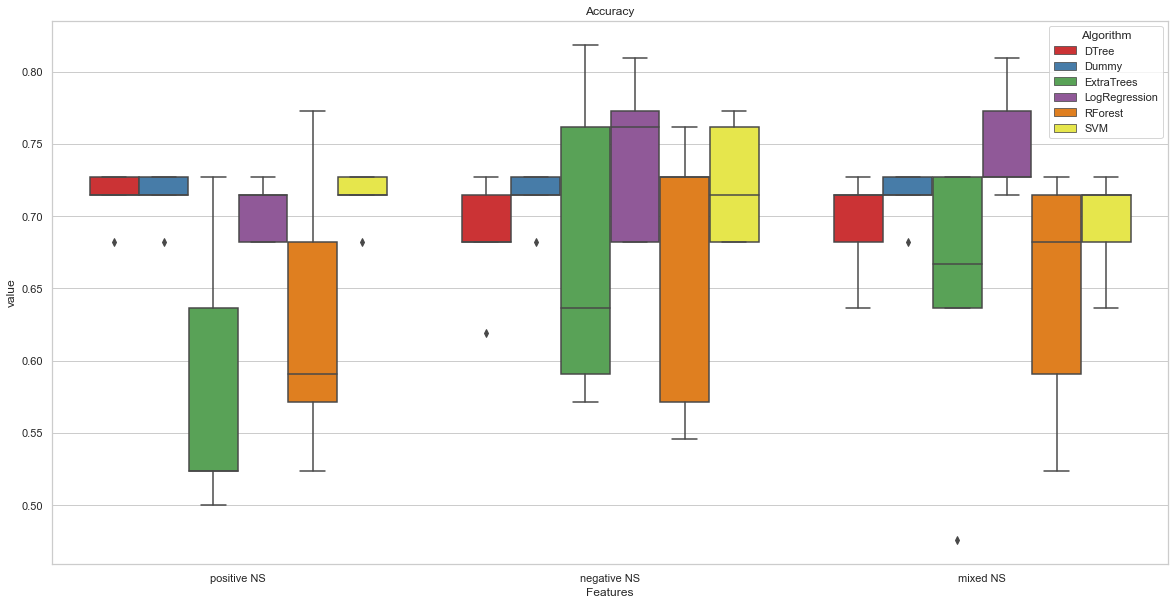

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_pos_RBP_NoCov = pd.DataFrame.from_dict(RBP_outer_scores_pos_NoCov).assign(Features="positive NS")
df_neg_RBP_NoCov = pd.DataFrame.from_dict(RBP_outer_scores_neg_NoCov).assign(Features="negative NS")
df_mix_RBP_NoCov = pd.DataFrame.from_dict(RBP_outer_scores_mix_NoCov).assign(Features="mixed NS")

cdf = pd.concat([df_pos_RBP_NoCov, df_neg_RBP_NoCov, df_mix_RBP_NoCov]) 
mdf = pd.melt(cdf, id_vars=['Features'], var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)
plt.title("Accuracy")
sns.boxplot(x="Features", y="value", hue="Algorithm", data=mdf, palette='Set1')  # RUN PLOT  

#plt.legend(bbox_to_anchor=(1, 0.6))
#sns.set(rc = {'figure.figsize':(10,5)})
#sns.show()

Text(0.5, 0.98, 'Positive Tail')

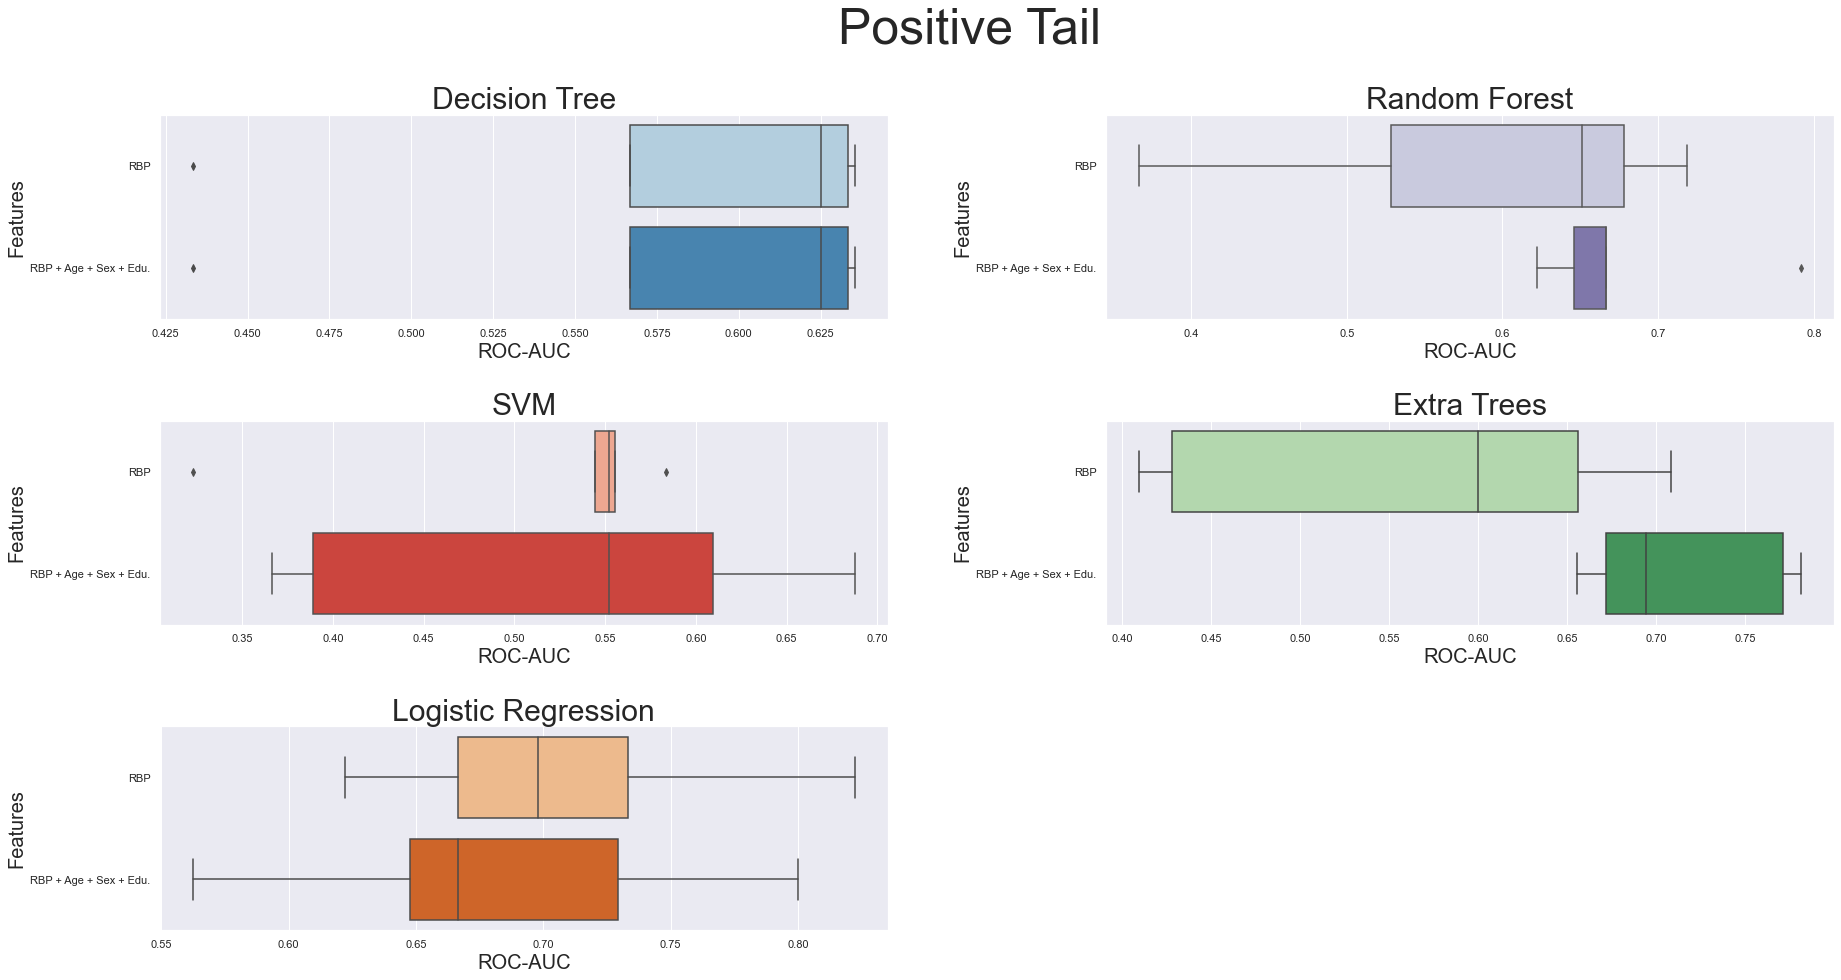

In [158]:
cols = ['ROC-AUC', 'Features']
features = ['RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.','RBP + Age + Sex + Edu.']

df_roc_rforest_NoCov_pos_RBP = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_pos_RBP['ROC-AUC'] = RBP_outer_roc_scores_pos_NoCov['RForest'] + RBP_outer_roc_scores_pos['RForest']
df_roc_rforest_NoCov_pos_RBP['Features'] = features

df_roc_dtree_NoCov_pos_RBP = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_pos_RBP['ROC-AUC'] = RBP_outer_roc_scores_pos_NoCov['DTree'] + RBP_outer_roc_scores_pos['DTree']
df_roc_dtree_NoCov_pos_RBP['Features'] = features

df_roc_svm_NoCov_pos_RBP = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_pos_RBP['ROC-AUC'] = RBP_outer_roc_scores_pos_NoCov['SVM'] + RBP_outer_roc_scores_pos['SVM']
df_roc_svm_NoCov_pos_RBP['Features'] = features

df_roc_extratrees_NoCov_pos_RBP = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_pos_RBP['ROC-AUC'] = RBP_outer_roc_scores_pos_NoCov['ExtraTrees'] + RBP_outer_roc_scores_pos['ExtraTrees']
df_roc_extratrees_NoCov_pos_RBP['Features'] = features

df_roc_logregression_NoCov_pos_RBP = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_pos_RBP['ROC-AUC'] = RBP_outer_roc_scores_pos_NoCov['LogRegression'] + RBP_outer_roc_scores_pos['LogRegression']
df_roc_logregression_NoCov_pos_RBP['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_pos_RBP, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_pos_RBP, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_pos_RBP, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_pos_RBP, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_pos_RBP, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Positive Tail', fontsize=50)

Text(0.5, 0.98, 'Negative Tail')

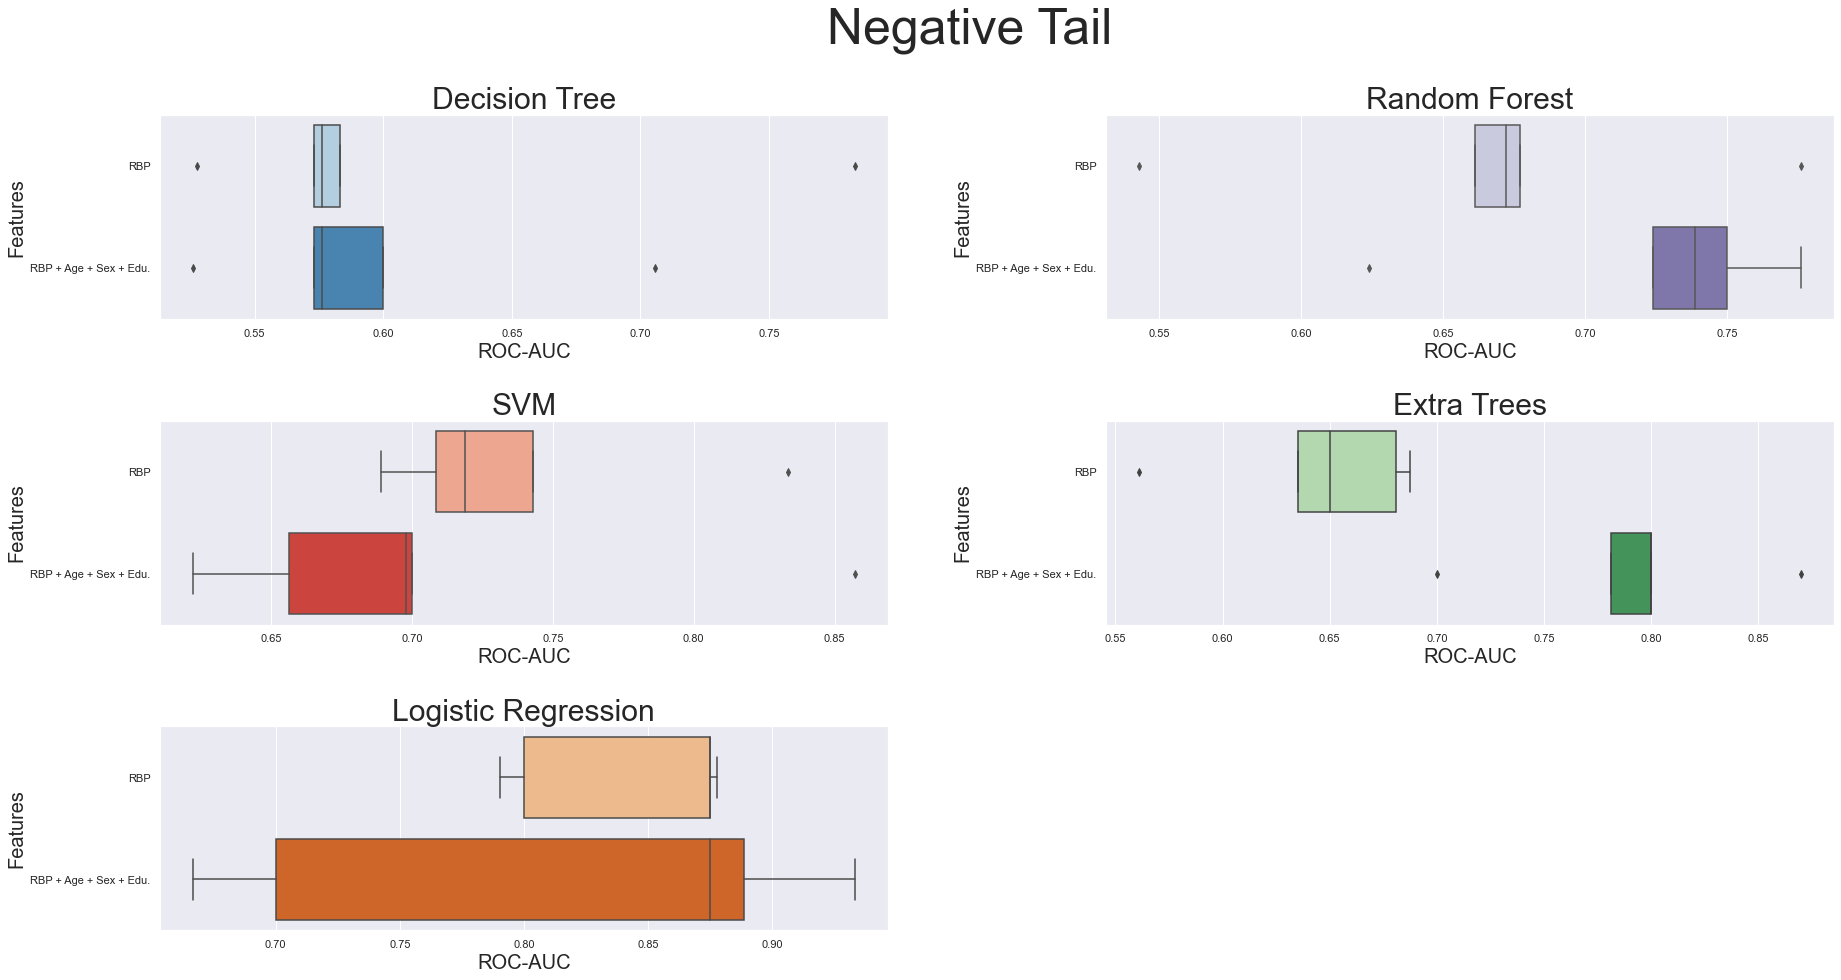

In [168]:
cols = ['ROC-AUC', 'Features']
features = ['RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.','RBP + Age + Sex + Edu.']

df_roc_rforest_NoCov_neg_RBP = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_neg_RBP['ROC-AUC'] = RBP_outer_roc_scores_neg_NoCov['RForest'] + RBP_outer_roc_scores_neg['RForest']
df_roc_rforest_NoCov_neg_RBP['Features'] = features

df_roc_dtree_NoCov_neg_RBP = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_neg_RBP['ROC-AUC'] = RBP_outer_roc_scores_neg_NoCov['DTree'] + RBP_outer_roc_scores_neg['DTree']
df_roc_dtree_NoCov_neg_RBP['Features'] = features

df_roc_svm_NoCov_neg_RBP = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_neg_RBP['ROC-AUC'] = RBP_outer_roc_scores_neg_NoCov['SVM'] + RBP_outer_roc_scores_neg['SVM']
df_roc_svm_NoCov_neg_RBP['Features'] = features

df_roc_extratrees_NoCov_neg_RBP = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_neg_RBP['ROC-AUC'] = RBP_outer_roc_scores_neg_NoCov['ExtraTrees'] + RBP_outer_roc_scores_neg['ExtraTrees']
df_roc_extratrees_NoCov_neg_RBP['Features'] = features

df_roc_logregression_NoCov_neg_RBP = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_neg_RBP['ROC-AUC'] = RBP_outer_roc_scores_neg_NoCov['LogRegression'] + RBP_outer_roc_scores_neg['LogRegression']
df_roc_logregression_NoCov_neg_RBP['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_neg_RBP, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_neg_RBP, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_neg_RBP, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_neg_RBP, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_neg_RBP, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Negative Tail', fontsize=50)

Text(0.5, 0.98, 'Mixed Tail')

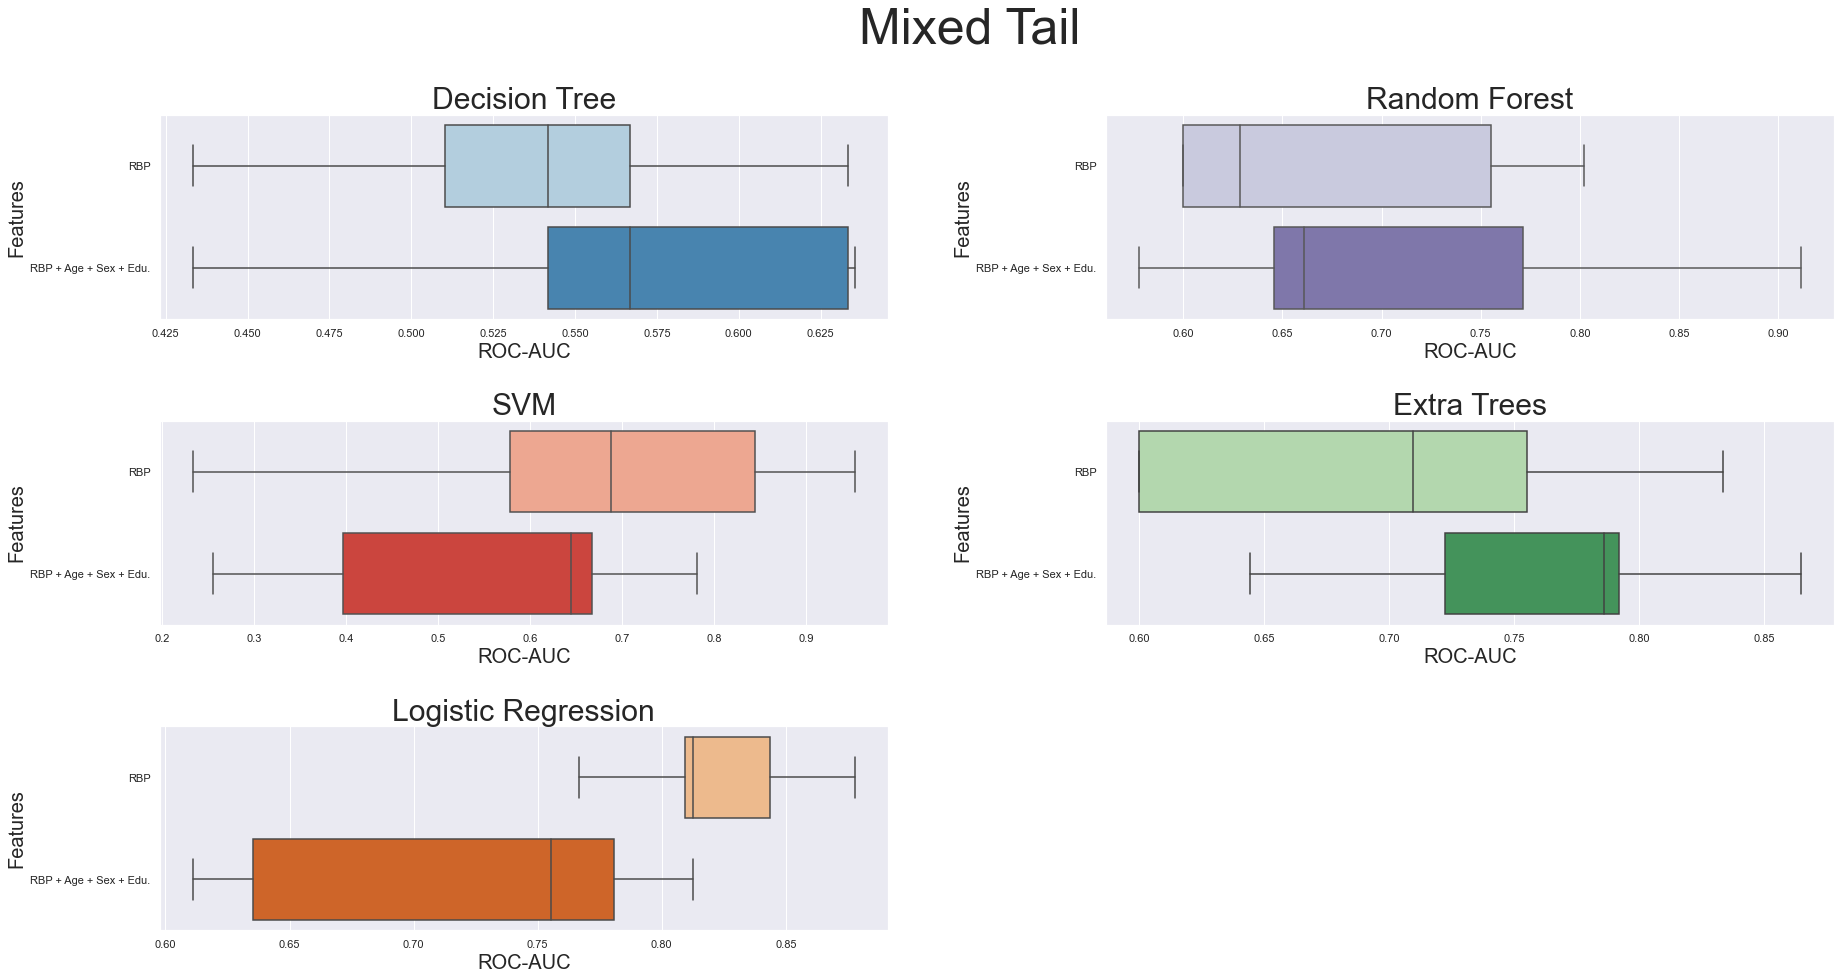

In [169]:
cols = ['ROC-AUC', 'Features']
features = ['RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.','RBP + Age + Sex + Edu.']

df_roc_rforest_NoCov_mix_RBP = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_mix_RBP['ROC-AUC'] = RBP_outer_roc_scores_mix_NoCov['RForest'] + RBP_outer_roc_scores_mix['RForest']
df_roc_rforest_NoCov_mix_RBP['Features'] = features

df_roc_dtree_NoCov_mix_RBP = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_mix_RBP['ROC-AUC'] = RBP_outer_roc_scores_mix_NoCov['DTree'] + RBP_outer_roc_scores_mix['DTree']
df_roc_dtree_NoCov_mix_RBP['Features'] = features

df_roc_svm_NoCov_mix_RBP = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_mix_RBP['ROC-AUC'] = RBP_outer_roc_scores_mix_NoCov['SVM'] + RBP_outer_roc_scores_mix['SVM']
df_roc_svm_NoCov_mix_RBP['Features'] = features

df_roc_extratrees_NoCov_mix_RBP = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_mix_RBP['ROC-AUC'] = RBP_outer_roc_scores_mix_NoCov['ExtraTrees'] + RBP_outer_roc_scores_mix['ExtraTrees']
df_roc_extratrees_NoCov_mix_RBP['Features'] = features

df_roc_logregression_NoCov_mix_RBP = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_mix_RBP['ROC-AUC'] = RBP_outer_roc_scores_mix_NoCov['LogRegression'] + RBP_outer_roc_scores_mix['LogRegression']
df_roc_logregression_NoCov_mix_RBP['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_mix_RBP, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_mix_RBP, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_mix_RBP, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_mix_RBP, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_mix_RBP, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Mixed Tail', fontsize=50)

## PLV & RBP Features:

### Positive features only: 
<a id="PLV_RBP_pos"></a>

In [89]:
brain_regions = 210
p_thresh = 0.05

PLV_RBP_NoCov_outer_scores_pos = {}
PLV_RBP_NoCov_outer_roc_scores_pos = {}
PLV_RBP_NoCov_specificity_pos = {}
PLV_RBP_NoCov_sensitivity_pos = {}
PLV_RBP_NoCov_precision_pos = {}
PLV_RBP_NoCov_f1_pos = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    PLV_RBP_NoCov_outer_scores_pos['{}'.format(name)] = []
    PLV_RBP_NoCov_outer_roc_scores_pos['{}'.format(name)] = []
    PLV_RBP_NoCov_specificity_pos['{}'.format(name)] = []
    PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)] = []
    PLV_RBP_NoCov_precision_pos['{}'.format(name)] = []
    PLV_RBP_NoCov_f1_pos['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_PLV_RBP, y_PLV_RBP):
        
        X_train_pos_PLV_RBP_NoCov = X_PLV_RBP.copy(deep = True)
    
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_pos_PLV_RBP_NoCov.drop(columns=X_train_pos_PLV_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 1'] = pos_NS_train_RBP.band1
        X_train_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 2'] = pos_NS_train_RBP.band2
        X_train_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 3'] = pos_NS_train_RBP.band3
        X_train_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 4'] = pos_NS_train_RBP.band4
        X_train_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 5'] = pos_NS_train_RBP.band5
        
        pos_mask_train_PLV, neg_mask_train_PLV, pos_NS_train_PLV, neg_NS_train_PLV, mix_NS_train_PLV = ccf_train(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_pos_PLV_RBP_NoCov.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_train_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 1'] = pos_NS_train_PLV.band1
        X_train_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 2'] = pos_NS_train_PLV.band2
        X_train_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 3'] = pos_NS_train_PLV.band3
        X_train_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 4'] = pos_NS_train_PLV.band4
        X_train_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 5'] = pos_NS_train_PLV.band5
        
        X_train_pos_PLV_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_pos_PLV_RBP_NoCov.iloc[train_idx], y_PLV_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_PLV_RBP_cv = X_PLV_RBP.iloc[valid_idx]
        y_test_PLV_RBP_cv = y_PLV_RBP.iloc[valid_idx]
    
        X_test_pos_PLV_RBP_NoCov = X_test_PLV_RBP_cv.copy(deep = True)

        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_pos_PLV_RBP_NoCov.drop(columns=X_test_pos_PLV_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 1'] = pos_NS_test_RBP.band1
        X_test_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 2'] = pos_NS_test_RBP.band2
        X_test_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 3'] = pos_NS_test_RBP.band3
        X_test_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 4'] = pos_NS_test_RBP.band4
        X_test_pos_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 5'] = pos_NS_test_RBP.band5
        
        pos_NS_test_PLV, neg_NS_test_PLV, mix_NS_test_PLV = ccf_test(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_PLV, neg_mask_train_PLV)
        X_test_pos_PLV_RBP_NoCov.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_test_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 1'] = pos_NS_test_PLV.band1
        X_test_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 2'] = pos_NS_test_PLV.band2
        X_test_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 3'] = pos_NS_test_PLV.band3
        X_test_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 4'] = pos_NS_test_PLV.band4
        X_test_pos_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 5'] = pos_NS_test_PLV.band5
        
        X_test_pos_PLV_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        
        PLV_RBP_NoCov_outer_roc_scores_pos['{}'.format(name)].append(roc_auc_score(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_pos_PLV_RBP_NoCov)[:,1]))
        PLV_RBP_NoCov_outer_scores_pos['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_pos_PLV_RBP_NoCov, y_test_PLV_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_PLV_RBP_NoCov)).ravel()
        PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)].append(tp / (tp+fn))
        PLV_RBP_NoCov_specificity_pos['{}'.format(name)].append(tn / (tn+fp))
        PLV_RBP_NoCov_precision_pos['{}'.format(name)].append(tp / (tp+fp))
        PLV_RBP_NoCov_f1_pos['{}'.format(name)].append((2*(PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)][-1] * PLV_RBP_NoCov_precision_pos['{}'.format(name)][-1])/(PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)][-1] + PLV_RBP_NoCov_precision_pos['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (PLV_RBP_NoCov_outer_scores_pos['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (PLV_RBP_NoCov_outer_roc_scores_pos['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (PLV_RBP_NoCov_specificity_pos['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (PLV_RBP_NoCov_precision_pos['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (PLV_RBP_NoCov_f1_pos['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_pos_PLV_RBP_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_outer_scores_pos['{}'.format(name)]) * 100, np.std(PLV_RBP_NoCov_outer_scores_pos['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_outer_roc_scores_pos['{}'.format(name)]), np.std(PLV_RBP_NoCov_outer_roc_scores_pos['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_specificity_pos['{}'.format(name)]), np.std(PLV_RBP_NoCov_specificity_pos['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)]), np.std(PLV_RBP_NoCov_sensitivity_pos['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_precision_pos['{}'.format(name)]), np.std(PLV_RBP_NoCov_precision_pos['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_f1_pos['{}'.format(name)]), np.std(PLV_RBP_NoCov_f1_pos['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'criterion': 'entropy', 'max_depth': 4}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 86.36%
        ROC-AUC (on outer test fold) 0.85
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.93
        F1-Score (on outer test fold) 0.90
        Confusion matrix: 
[[ 5  1]
 [ 2 14]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.58%
        Best parameters: {'criterion': 'gini', 'max_depth': 4}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
    


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 75.92%
        Best parameters: {'n_estimators': 1000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.79
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.82
        Confusion matrix: 
[[ 1  5]
 [ 1 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 80.47%
        Best parameters: {'n_estimators': 100}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.86
        Specificity (on outer test fold) 0.50
        Sensitivity (on outer test f

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer test fold) 0.92
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fold) 0.75
        Precision (on outer test fold) 0.92
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 5  1]
 [ 4 12]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 82.56%
        Best parameters: {'clf1__C': 0.5, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
        ROC-AUC (on outer t

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 80.58%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 80.95%
        ROC-AUC (on outer test fold) 0.82
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.79
        F1-Score (on outer test fold) 0.88
        Confusion matrix: 
[[ 2  4]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 83.96%
        Best parameters: {'clf1__C': 0.8, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer t

### Negative features only:
<a id="PLV_RBP_neg"></a>

In [90]:
brain_regions = 210
p_thresh = 0.05

PLV_RBP_NoCov_outer_scores_neg = {}
PLV_RBP_NoCov_outer_roc_scores_neg = {}
PLV_RBP_NoCov_specificity_neg = {}
PLV_RBP_NoCov_sensitivity_neg = {}
PLV_RBP_NoCov_precision_neg = {}
PLV_RBP_NoCov_f1_neg = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    PLV_RBP_NoCov_outer_scores_neg['{}'.format(name)] = []
    PLV_RBP_NoCov_outer_roc_scores_neg['{}'.format(name)] = []
    PLV_RBP_NoCov_specificity_neg['{}'.format(name)] = []
    PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)] = []
    PLV_RBP_NoCov_precision_neg['{}'.format(name)] = []
    PLV_RBP_NoCov_f1_neg['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_PLV_RBP, y_PLV_RBP):
        
        X_train_neg_PLV_RBP_NoCov = X_PLV_RBP.copy(deep = True)
    
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_neg_PLV_RBP_NoCov.drop(columns=X_train_neg_PLV_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 1'] = neg_NS_train_RBP.band1
        X_train_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 2'] = neg_NS_train_RBP.band2
        X_train_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 3'] = neg_NS_train_RBP.band3
        X_train_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 4'] = neg_NS_train_RBP.band4
        X_train_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 5'] = neg_NS_train_RBP.band5
        
        pos_mask_train_PLV, neg_mask_train_PLV, pos_NS_train_PLV, neg_NS_train_PLV, mix_NS_train_PLV = ccf_train(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_neg_PLV_RBP_NoCov.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_train_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 1'] = neg_NS_train_PLV.band1
        X_train_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 2'] = neg_NS_train_PLV.band2
        X_train_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 3'] = neg_NS_train_PLV.band3
        X_train_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 4'] = neg_NS_train_PLV.band4
        X_train_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 5'] = neg_NS_train_PLV.band5
        
        X_train_neg_PLV_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_neg_PLV_RBP_NoCov.iloc[train_idx], y_PLV_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_PLV_RBP_cv = X_PLV_RBP.iloc[valid_idx]
        y_test_PLV_RBP_cv = y_PLV_RBP.iloc[valid_idx]
    
        X_test_neg_PLV_RBP_NoCov = X_test_PLV_RBP_cv.copy(deep = True)

        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_neg_PLV_RBP_NoCov.drop(columns=X_test_neg_PLV_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 1'] = neg_NS_test_RBP.band1
        X_test_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 2'] = neg_NS_test_RBP.band2
        X_test_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 3'] = neg_NS_test_RBP.band3
        X_test_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 4'] = neg_NS_test_RBP.band4
        X_test_neg_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 5'] = neg_NS_test_RBP.band5
        
        pos_NS_test_PLV, neg_NS_test_PLV, mix_NS_test_PLV = ccf_test(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_PLV, neg_mask_train_PLV)
        X_test_neg_PLV_RBP_NoCov.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_test_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 1'] = neg_NS_test_PLV.band1
        X_test_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 2'] = neg_NS_test_PLV.band2
        X_test_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 3'] = neg_NS_test_PLV.band3
        X_test_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 4'] = neg_NS_test_PLV.band4
        X_test_neg_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 5'] = neg_NS_test_PLV.band5
        
        X_test_neg_PLV_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        
        PLV_RBP_NoCov_outer_roc_scores_neg['{}'.format(name)].append(roc_auc_score(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_neg_PLV_RBP_NoCov)[:,1]))
        PLV_RBP_NoCov_outer_scores_neg['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_neg_PLV_RBP_NoCov, y_test_PLV_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_PLV_RBP_NoCov)).ravel()
        PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)].append(tp / (tp+fn))
        PLV_RBP_NoCov_specificity_neg['{}'.format(name)].append(tn / (tn+fp))
        PLV_RBP_NoCov_precision_neg['{}'.format(name)].append(tp / (tp+fp))
        PLV_RBP_NoCov_f1_neg['{}'.format(name)].append((2*(PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)][-1] * PLV_RBP_NoCov_precision_neg['{}'.format(name)][-1])/(PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)][-1] + PLV_RBP_NoCov_precision_neg['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (PLV_RBP_NoCov_outer_scores_neg['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (PLV_RBP_NoCov_outer_roc_scores_neg['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (PLV_RBP_NoCov_specificity_neg['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (PLV_RBP_NoCov_precision_neg['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (PLV_RBP_NoCov_f1_neg['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_neg_PLV_RBP_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_outer_scores_neg['{}'.format(name)]) * 100, np.std(PLV_RBP_NoCov_outer_scores_neg['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_outer_roc_scores_neg['{}'.format(name)]), np.std(PLV_RBP_NoCov_outer_roc_scores_neg['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_specificity_neg['{}'.format(name)]), np.std(PLV_RBP_NoCov_specificity_neg['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)]), np.std(PLV_RBP_NoCov_sensitivity_neg['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_precision_neg['{}'.format(name)]), np.std(PLV_RBP_NoCov_precision_neg['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_f1_neg['{}'.format(name)]), np.std(PLV_RBP_NoCov_f1_neg['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
        ROC-AUC (on outer test fold) 0.59
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.78
        F1-Score (on outer test fold) 0.33
        Confusion matrix: 
[[ 2  4]
 [ 2 14]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.74%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 77.27%
       


        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 79.31%
        Best parameters: {'n_estimators': 10000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 76.19%
        ROC-AUC (on outer test fold) 0.93
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.93
        Precision (on outer test fold) 0.78
        F1-Score (on outer test fold) 0.33
        Confusion matrix: 
[[ 2  4]
 [ 1 14]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 71.30%
        Best parameters: {'n_estimators': 10000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.93
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer tes

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 86.05%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'lbfgs'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.71
        Specificity (on outer test fold) 0.17
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.74
        F1-Score (on outer test fold) 0.17
        Confusion matrix: 
[[ 1  5]
 [ 2 14]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'clf1__C': 0.5, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 86.36%
        ROC-AUC (on outer test 

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 76.93%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 85.71%
        ROC-AUC (on outer test fold) 0.93
        Specificity (on outer test fold) 0.83
        Sensitivity (on outer test fold) 0.87
        Precision (on outer test fold) 0.93
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 5  1]
 [ 2 13]]

    Outer Loop:
        ACC 80.56% +/- 7.30
        ROC-AUC 0.89 +/- 0.09
        Specificity 0.55 +/- 0.27
        Sensitivity 0.91 +/- 0.05
        Precision 0.84 +/- 0.08
        F1-Score 0.55 +/- 0.27
-------------------------------------------------- 

Algorithm: RForest
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25

### Mixed features:
<a id="PLV_RBP_mix"></a>

In [91]:
brain_regions = 210
p_thresh = 0.05

PLV_RBP_NoCov_outer_scores_mix = {}
PLV_RBP_NoCov_outer_roc_scores_mix = {}
PLV_RBP_NoCov_specificity_mix = {}
PLV_RBP_NoCov_sensitivity_mix = {}
PLV_RBP_NoCov_precision_mix = {}
PLV_RBP_NoCov_f1_mix = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    PLV_RBP_NoCov_outer_scores_mix['{}'.format(name)] = []
    PLV_RBP_NoCov_outer_roc_scores_mix['{}'.format(name)] = []
    PLV_RBP_NoCov_specificity_mix['{}'.format(name)] = []
    PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)] = []
    PLV_RBP_NoCov_precision_mix['{}'.format(name)] = []
    PLV_RBP_NoCov_f1_mix['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_PLV_RBP, y_PLV_RBP):
        
        X_train_mix_PLV_RBP_NoCov = X_PLV_RBP.copy(deep = True)
    
        pos_mask_train_RBP, neg_mask_train_RBP, pos_NS_train_RBP, neg_NS_train_RBP, mix_NS_train_RBP = ccf_train_RBP(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_mix_PLV_RBP_NoCov.drop(columns=X_train_mix_PLV_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_train_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 1'] = mix_NS_train_RBP.band1
        X_train_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 2'] = mix_NS_train_RBP.band2
        X_train_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 3'] = mix_NS_train_RBP.band3
        X_train_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 4'] = mix_NS_train_RBP.band4
        X_train_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 5'] = mix_NS_train_RBP.band5
        
        pos_mask_train_PLV, neg_mask_train_PLV, pos_NS_train_PLV, neg_NS_train_PLV, mix_NS_train_PLV = ccf_train(X_PLV_RBP, y_PLV_RBP, brain_regions, p_thresh)
        X_train_mix_PLV_RBP_NoCov.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_train_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 1'] = mix_NS_train_PLV.band1
        X_train_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 2'] = mix_NS_train_PLV.band2
        X_train_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 3'] = mix_NS_train_PLV.band3
        X_train_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 4'] = mix_NS_train_PLV.band4
        X_train_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 5'] = mix_NS_train_PLV.band5
        
        X_train_mix_PLV_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        gridcvs[name].fit(X_train_mix_PLV_RBP_NoCov.iloc[train_idx], y_PLV_RBP.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_PLV_RBP.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_PLV_RBP_cv = X_PLV_RBP.iloc[valid_idx]
        y_test_PLV_RBP_cv = y_PLV_RBP.iloc[valid_idx]
    
        X_test_mix_PLV_RBP_NoCov = X_test_PLV_RBP_cv.copy(deep = True)

        pos_NS_test_RBP, neg_NS_test_RBP, mix_NS_test_RBP = ccf_test_RBP(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_RBP, neg_mask_train_RBP)
        X_test_mix_PLV_RBP_NoCov.drop(columns=X_test_mix_PLV_RBP_NoCov.columns[-5:], axis=1,  inplace=True)
        X_test_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 1'] = mix_NS_test_RBP.band1
        X_test_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 2'] = mix_NS_test_RBP.band2
        X_test_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 3'] = mix_NS_test_RBP.band3
        X_test_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 4'] = mix_NS_test_RBP.band4
        X_test_mix_PLV_RBP_NoCov.loc[:, 'RBP Pos NS band 5'] = mix_NS_test_RBP.band5
        
        pos_NS_test_PLV, neg_NS_test_PLV, mix_NS_test_PLV = ccf_test(X_test_PLV_RBP_cv, y_test_PLV_RBP_cv, brain_regions, pos_mask_train_PLV, neg_mask_train_PLV)
        X_test_mix_PLV_RBP_NoCov.drop(['Band 1 PLV', 'Band 2 PLV', 'Band 3 PLV', 'Band 4 PLV', 'Band 5 PLV'], axis=1,  inplace=True)
        X_test_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 1'] = mix_NS_test_RBP.band1
        X_test_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 2'] = mix_NS_test_RBP.band2
        X_test_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 3'] = mix_NS_test_RBP.band3
        X_test_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 4'] = mix_NS_test_RBP.band4
        X_test_mix_PLV_RBP_NoCov.loc[:, 'PLV Pos NS band 5'] = mix_NS_test_RBP.band5
        
        X_test_mix_PLV_RBP_NoCov.drop(['Age', 'Sex', 'EduTot'], axis=1,  inplace=True)
        
        
        PLV_RBP_NoCov_outer_roc_scores_mix['{}'.format(name)].append(roc_auc_score(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict_proba(X_test_mix_PLV_RBP_NoCov)[:,1]))
        PLV_RBP_NoCov_outer_scores_mix['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_mix_PLV_RBP_NoCov, y_test_PLV_RBP_cv))
        tn, fp, fn, tp = confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_PLV_RBP_NoCov)).ravel()
        PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)].append(tp / (tp+fn))
        PLV_RBP_NoCov_specificity_mix['{}'.format(name)].append(tn / (tn+fp))
        PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))
        PLV_RBP_NoCov_f1_mix['{}'.format(name)].append((2*(PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)][-1] * PLV_RBP_NoCov_precision_mix['{}'.format(name)][-1])/(PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)][-1] + PLV_RBP_NoCov_precision_mix['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_PLV_RBP_cv==0)))
        print('        ACC (on outer test fold) %.2f%%' % (PLV_RBP_NoCov_outer_scores_mix['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (PLV_RBP_NoCov_outer_roc_scores_mix['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (PLV_RBP_NoCov_specificity_mix['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (PLV_RBP_NoCov_precision_mix['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (PLV_RBP_NoCov_f1_mix['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_PLV_RBP_cv, gridcvs[name].best_estimator_.predict(X_test_mix_PLV_RBP_NoCov)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_outer_scores_mix['{}'.format(name)]) * 100, np.std(PLV_RBP_NoCov_outer_scores_mix['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_outer_roc_scores_mix['{}'.format(name)]), np.std(PLV_RBP_NoCov_outer_roc_scores_mix['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_specificity_mix['{}'.format(name)]), np.std(PLV_RBP_NoCov_specificity_mix['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)]), np.std(PLV_RBP_NoCov_sensitivity_mix['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_precision_mix['{}'.format(name)]), np.std(PLV_RBP_NoCov_precision_mix['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(PLV_RBP_NoCov_f1_mix['{}'.format(name)]), np.std(PLV_RBP_NoCov_f1_mix['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 81.40%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 27.27%
        ROC-AUC (on outer test fold) 0.50
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [16  0]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 83.72%
        Best parameters: {'criterion': 'gini', 'max_depth': 2}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.47
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 0.94
        Precision (on outer test fold) 0.71
        F1-Score (on outer test fold) 0.81
        Confusion matrix: 
[[ 0  6]
 [ 1 15]]

        nb. of PD in the t

<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 31.82%
        ROC-AUC (on outer test fold) 0.50
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 7  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 85.07%
        Best parameters: {'criterion': 'entropy', 'max_depth': 2}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 28.57%
        ROC-AUC (on outer test fold) 0.50
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 88.56%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 28.57%
        ROC-AUC (on outer test fold) 0.50
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [15  0]]

    Outer Loop:
        ACC 36.88% +/- 15.72
        ROC-AUC 0.49 +/- 0.01
        Specificity 0.80 +/- 0.40
        Sensitivity 0.19 +/- 0.38
        Precision nan +/- nan
        F1-Score nan +/- nan
-------------------------------------------------- 

Algorithm: Dummy
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 70.93%
        Best parameters: {'clf0__strategy': 'most_frequent'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
       

<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 27.27%
        ROC-AUC (on outer test fold) 0.73
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [16  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 84.88%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 36.36%
        ROC-AUC (on outer test fold) 0.70
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.07
        Precision (on outer test fold) 1.00
        F1-Score (on outer test fold) 0.12
        Confusion matrix: 
[[ 7  0]
 [14  1]]

        nb. of PD in the training set: 62
 

<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 28.57%
        ROC-AUC (on outer test fold) 0.61
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 87.39%
        Best parameters: {'n_estimators': 100}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 28.57%
        ROC-AUC (on outer test fold) 0.76
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [15  0]]

    Outer Loop:
        ACC 30.52% +/- 3.29
        ROC-AUC 0.68 +/- 0.06
        Specificity 0.97 +/- 0.07
        Sensitivity 0.04 +/- 0.05
        Precision nan +/- nan
        F1-Score nan +/- nan
-------------------------------------------------- 

Algorithm: LogRegression
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 84.88%
        Best parameters: {'clf1__C': 0.1, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
       

<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 27.27%
        ROC-AUC (on outer test fold) 0.80
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [16  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 86.05%
        Best parameters: {'clf1__C': 1, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 31.82%
        ROC-AUC (on outer test fold) 0.79
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 7  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 88.56%
        Best parameters: {'clf1__C': 0.5, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 61.90%
        ROC-AUC (on outer test fold) 0.68
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.47
        Precision (on outer test fold) 1.00
        F1-Score (on outer test fold) 0.64
        Confusion matrix: 
[[6 0]
 [8 7]]


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 27.27%
        ROC-AUC (on outer test fold) 0.68
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [16  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 87.21%
        Best parameters: {'n_estimators': 500}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 31.82%
        ROC-AUC (on outer test fold) 0.58
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 7  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 85.12%
        Best parameters: {'n_estimators': 500}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 28.57%
        ROC-AUC (on outer test fold) 0.42
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 85.10%
        Best parameters: {'n_estimators': 10000}


<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 28.57%
        ROC-AUC (on outer test fold) 0.77
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 6  0]
 [15  0]]

    Outer Loop:
        ACC 30.52% +/- 3.29
        ROC-AUC 0.62 +/- 0.12
        Specificity 1.00 +/- 0.00
        Sensitivity 0.03 +/- 0.05
        Precision nan +/- nan
        F1-Score nan +/- nan
-------------------------------------------------- 

Algorithm: SVM
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 87.21%
        Best parameters: {'clf4__C': 0.1, 'clf4__kernel': 'linear'}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 36.36%
   

<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 31.82%
        ROC-AUC (on outer test fold) 0.76
        Specificity (on outer test fold) 1.00
        Sensitivity (on outer test fold) 0.00
        Precision (on outer test fold) nan
        F1-Score (on outer test fold) nan
        Confusion matrix: 
[[ 7  0]
 [15  0]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 88.56%
        Best parameters: {'clf4__C': 0.8, 'clf4__gamma': 0.1, 'clf4__kernel': 'rbf'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.62
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.71
        F1-Score (on outer test fold) 0.83
        Confusion matrix: 
[[ 0  6]
 [ 0 15]]

    

<ipython-input-91-13a412a7b6d6>:85: RuntimeWarning: invalid value encountered in longlong_scalars
  PLV_RBP_NoCov_precision_mix['{}'.format(name)].append(tp / (tp+fp))


Text(0.5, 0.98, 'Positive Tail')

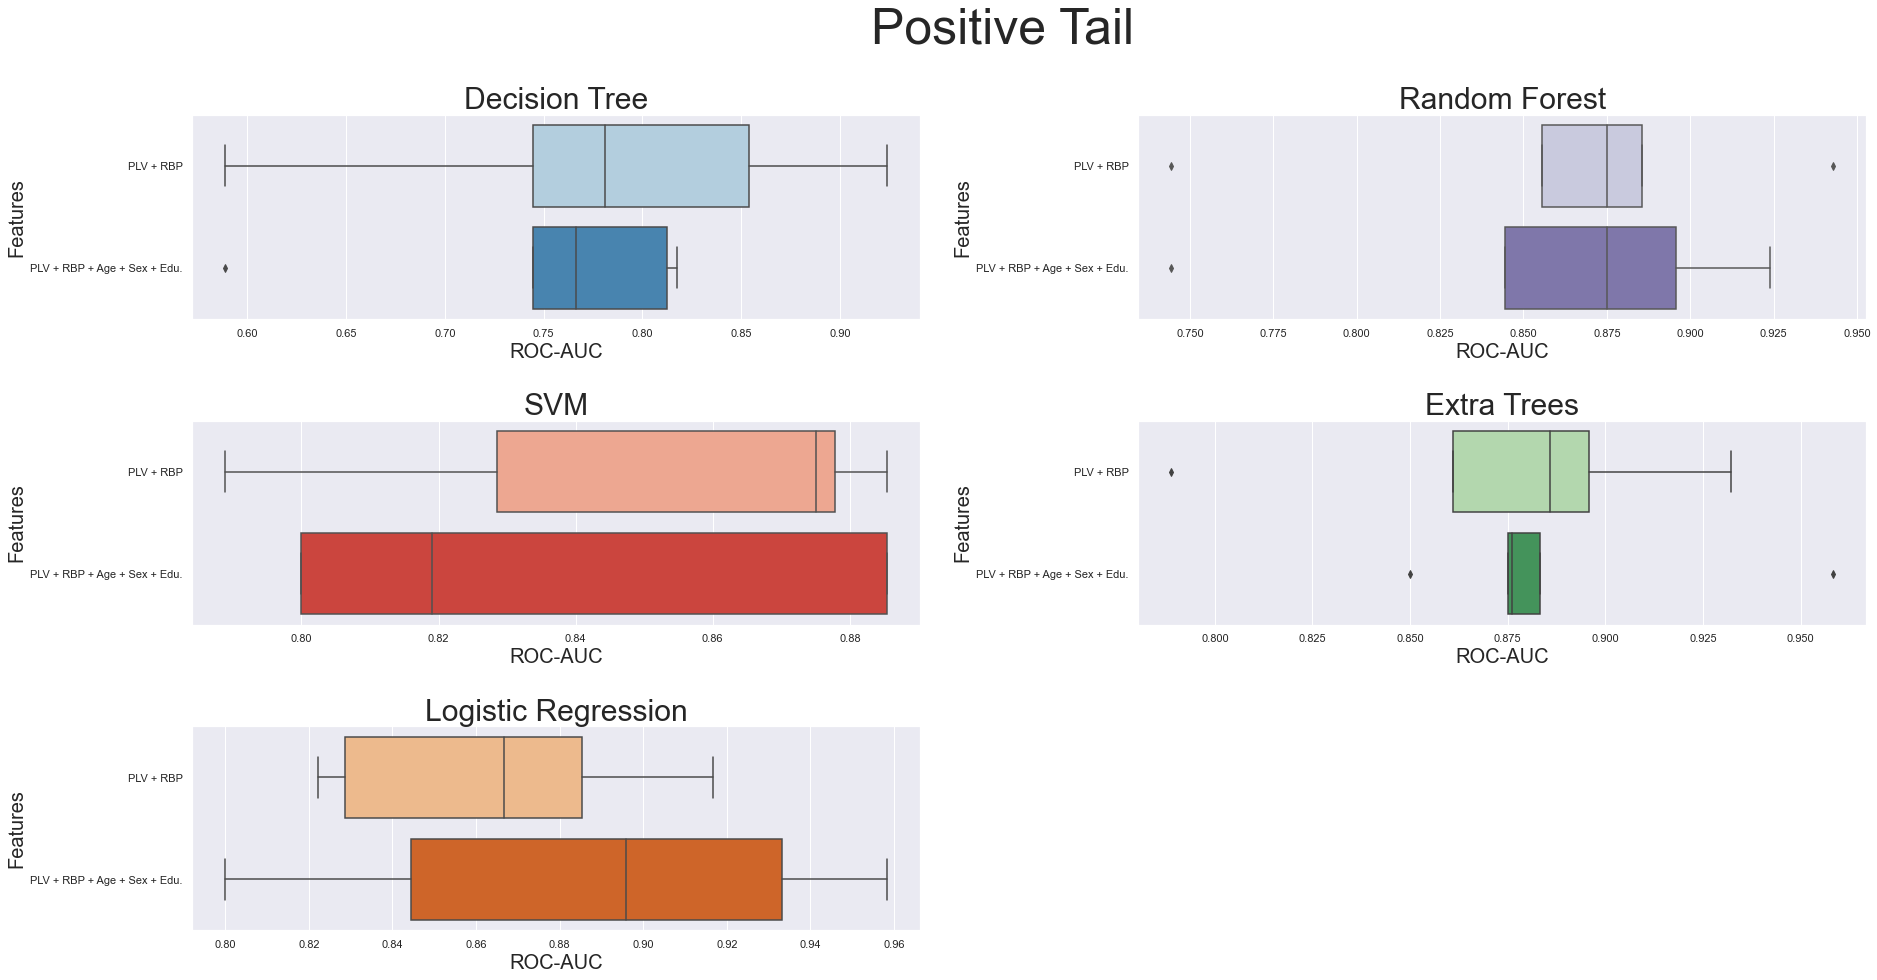

In [172]:
cols = ['ROC-AUC', 'Features']
features = ['PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.','PLV + RBP + Age + Sex + Edu.']

df_roc_rforest_NoCov_pos = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_pos['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_pos['RForest'] + PLV_RBP_outer_roc_scores_pos['RForest']
df_roc_rforest_NoCov_pos['Features'] = features

df_roc_dtree_NoCov_pos = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_pos['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_pos['DTree'] + PLV_RBP_outer_roc_scores_pos['DTree']
df_roc_dtree_NoCov_pos['Features'] = features

df_roc_svm_NoCov_pos = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_pos['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_pos['SVM'] + PLV_RBP_outer_roc_scores_pos['SVM']
df_roc_svm_NoCov_pos['Features'] = features

df_roc_extratrees_NoCov_pos = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_pos['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_pos['ExtraTrees'] + PLV_RBP_outer_roc_scores_pos['ExtraTrees']
df_roc_extratrees_NoCov_pos['Features'] = features

df_roc_logregression_NoCov_pos = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_pos['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_pos['LogRegression'] + PLV_RBP_outer_roc_scores_pos['LogRegression']
df_roc_logregression_NoCov_pos['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_pos, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_pos, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_pos, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_pos, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_pos, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Positive Tail', fontsize=50)

Text(0.5, 0.98, 'Negative Tail')

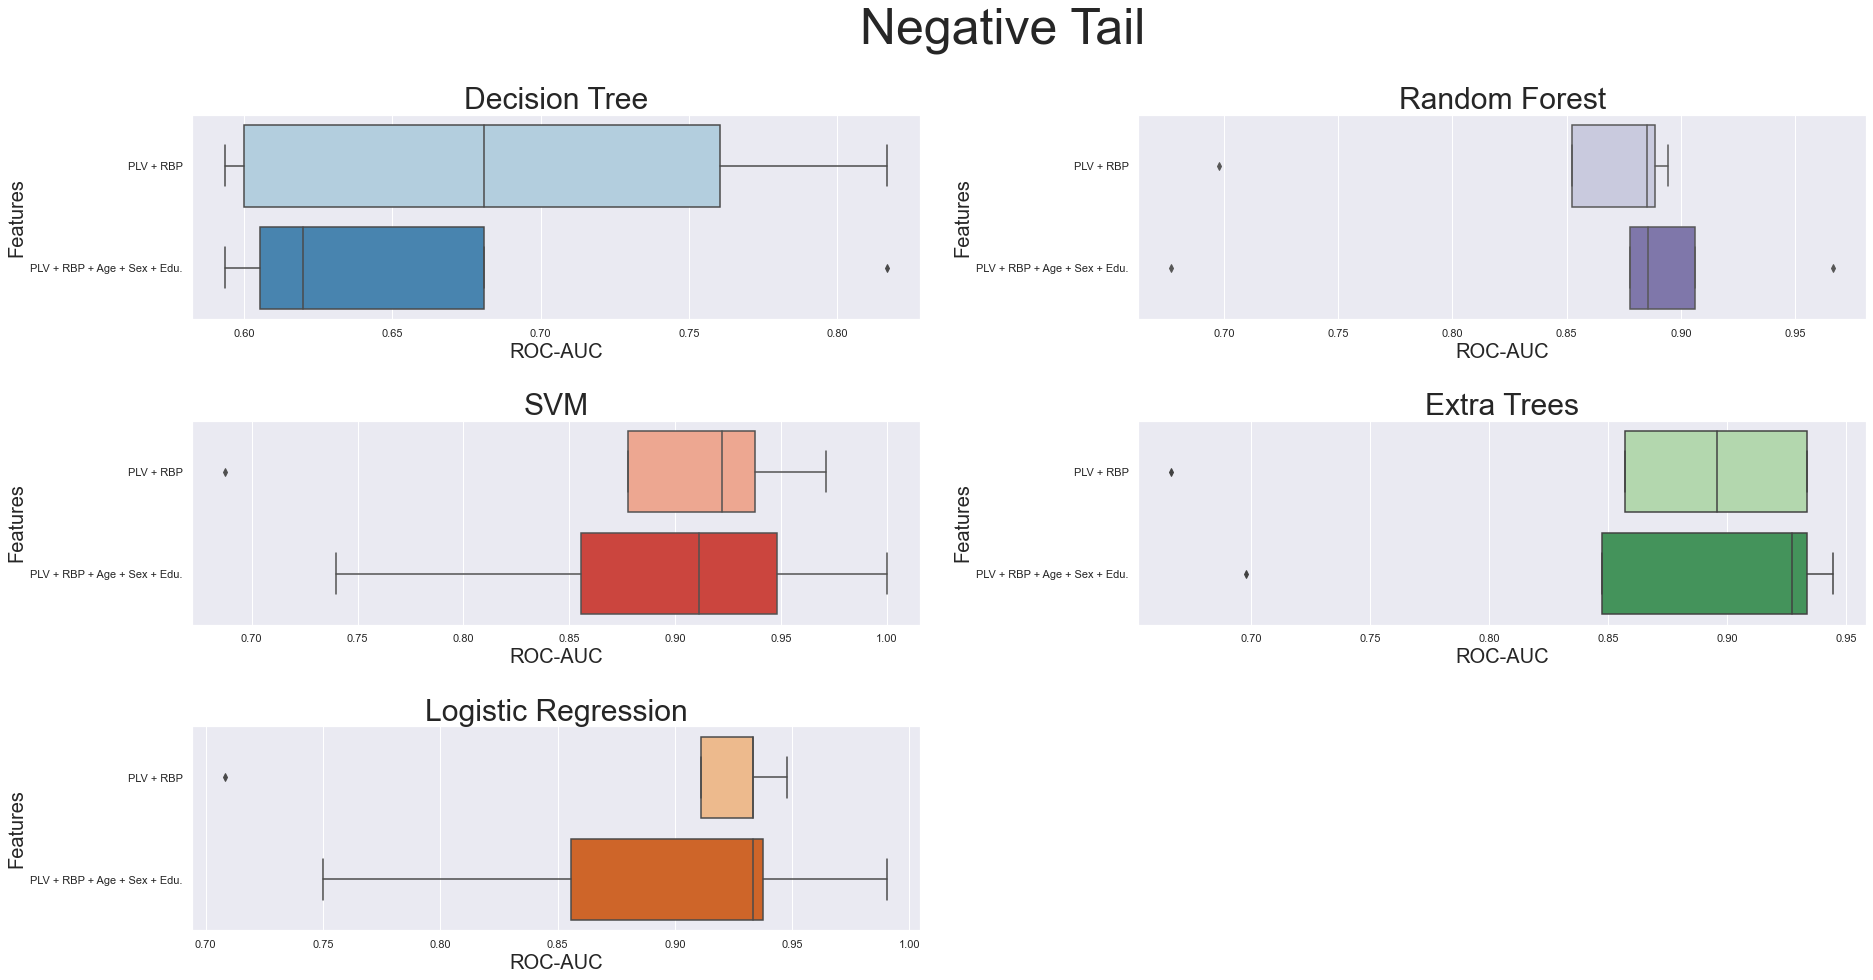

In [174]:
cols = ['ROC-AUC', 'Features']
features = ['PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.','PLV + RBP + Age + Sex + Edu.']

df_roc_rforest_NoCov_neg = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_neg['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_neg['RForest'] + PLV_RBP_outer_roc_scores_neg['RForest']
df_roc_rforest_NoCov_neg['Features'] = features

df_roc_dtree_NoCov_neg = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_neg['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_neg['DTree'] + PLV_RBP_outer_roc_scores_neg['DTree']
df_roc_dtree_NoCov_neg['Features'] = features

df_roc_svm_NoCov_neg = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_neg['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_neg['SVM'] + PLV_RBP_outer_roc_scores_neg['SVM']
df_roc_svm_NoCov_neg['Features'] = features

df_roc_extratrees_NoCov_neg = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_neg['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_neg['ExtraTrees'] + PLV_RBP_outer_roc_scores_neg['ExtraTrees']
df_roc_extratrees_NoCov_neg['Features'] = features

df_roc_logregression_NoCov_neg = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_neg['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_neg['LogRegression'] + PLV_RBP_outer_roc_scores_neg['LogRegression']
df_roc_logregression_NoCov_neg['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_neg, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_neg, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_neg, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_neg, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_neg, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Negative Tail', fontsize=50)

Text(0.5, 0.98, 'Mixed Tail')

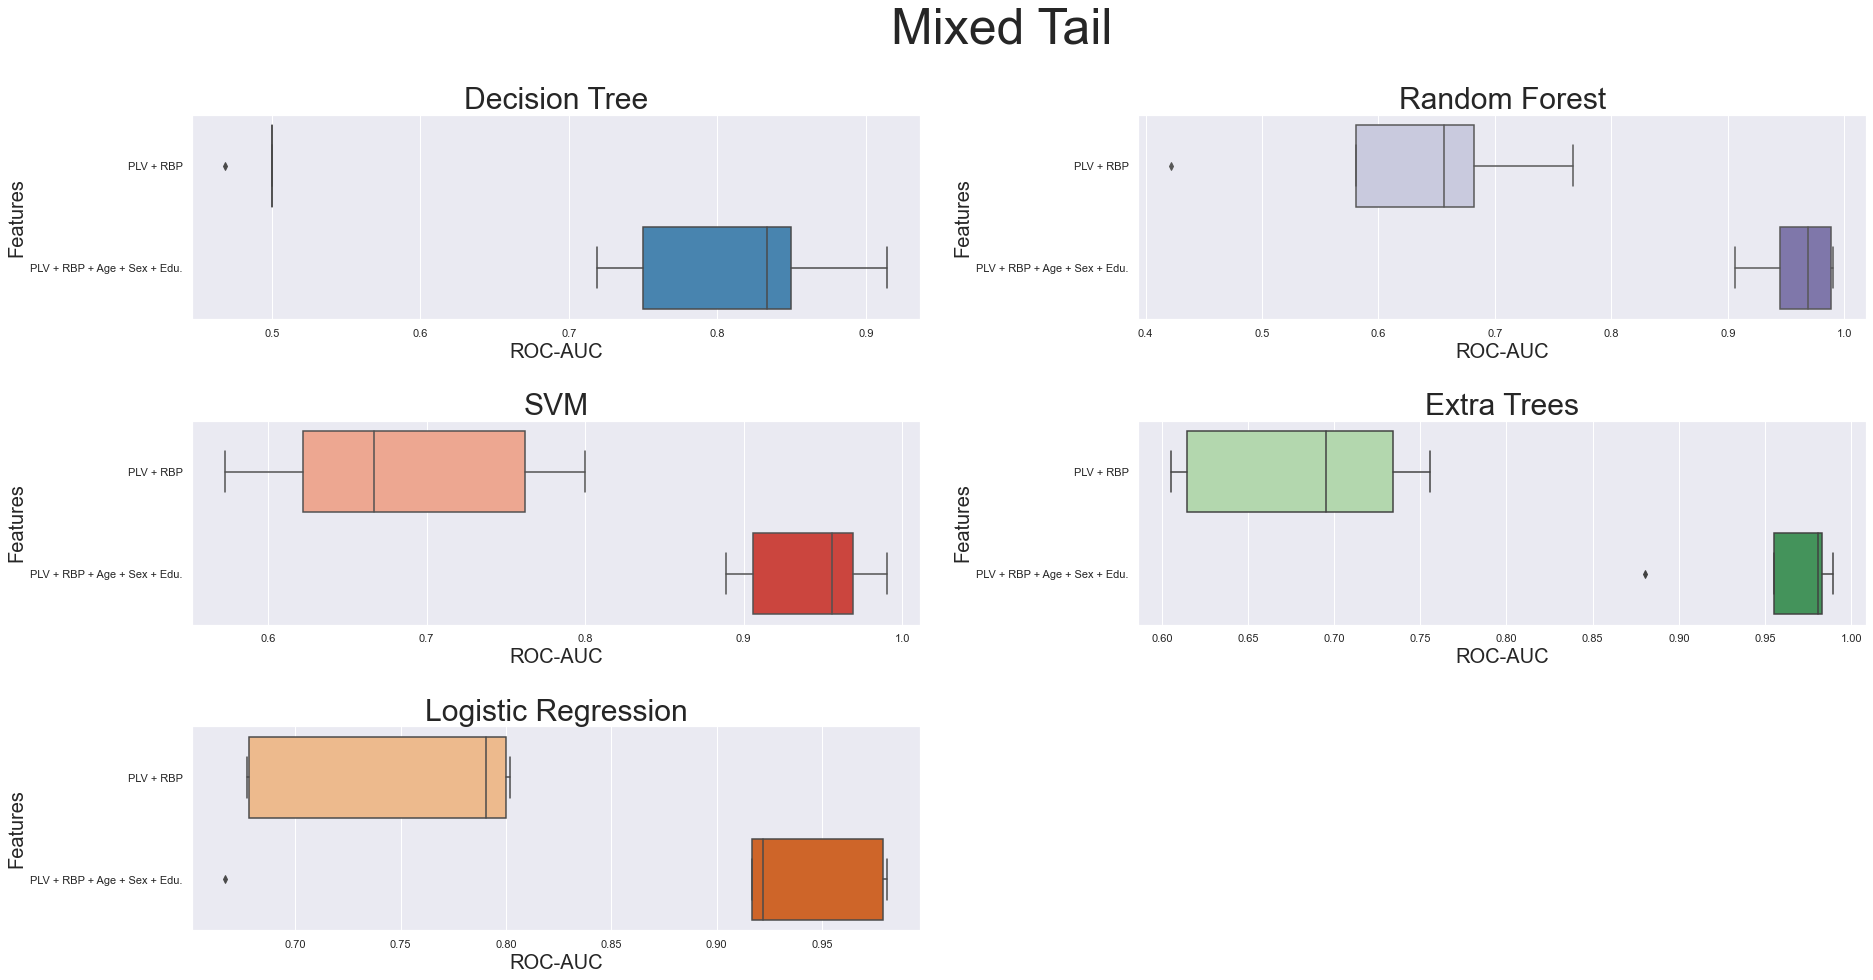

In [180]:
cols = ['ROC-AUC', 'Features']
features = ['PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.','PLV + RBP + Age + Sex + Edu.']

df_roc_rforest_NoCov_mix = pd.DataFrame(columns=cols)
df_roc_rforest_NoCov_mix['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_mix['RForest'] + PLV_RBP_outer_roc_scores_mix['RForest']
df_roc_rforest_NoCov_mix['Features'] = features

df_roc_dtree_NoCov_mix = pd.DataFrame(columns=cols)
df_roc_dtree_NoCov_mix['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_mix['DTree'] + PLV_RBP_outer_roc_scores_mix['DTree']
df_roc_dtree_NoCov_mix['Features'] = features

df_roc_svm_NoCov_mix = pd.DataFrame(columns=cols)
df_roc_svm_NoCov_mix['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_mix['SVM'] + PLV_RBP_outer_roc_scores_mix['SVM']
df_roc_svm_NoCov_mix['Features'] = features

df_roc_extratrees_NoCov_mix = pd.DataFrame(columns=cols)
df_roc_extratrees_NoCov_mix['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_mix['ExtraTrees'] + PLV_RBP_outer_roc_scores_mix['ExtraTrees']
df_roc_extratrees_NoCov_mix['Features'] = features

df_roc_logregression_NoCov_mix = pd.DataFrame(columns=cols)
df_roc_logregression_NoCov_mix['ROC-AUC'] = PLV_RBP_NoCov_outer_roc_scores_mix['LogRegression'] + PLV_RBP_outer_roc_scores_mix['LogRegression']
df_roc_logregression_NoCov_mix['Features'] = features

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(30,15))
#axes[0,0].set(ylim=(0.3, 0.9))
#axes[0,1].set(ylim=(0.3, 0.9))
#axes[0,2].set(ylim=(0.3, 0.9))
#axes[1,0].set(ylim=(0.3, 0.9))
#axes[1,1].set(ylim=(0.3, 0.9))
#create boxplot in each subplot
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=0.3, hspace=0.5)

a = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_dtree_NoCov_mix, ax=axes[0,0], palette="Blues")
axes[0,0].set_title('Decision Tree', fontsize = 30)
a.set_xlabel("ROC-AUC", fontsize = 20)
a.set_ylabel("Features", fontsize = 20)
b = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_rforest_NoCov_mix, ax=axes[0,1], palette="Purples")
axes[0,1].set_title('Random Forest', fontsize = 30)
b.set_xlabel("ROC-AUC", fontsize = 20)
b.set_ylabel("Features", fontsize = 20)
c = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_svm_NoCov_mix, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('SVM', fontsize = 30)
c.set_xlabel("ROC-AUC", fontsize = 20)
c.set_ylabel("Features", fontsize = 20)
d = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_extratrees_NoCov_mix, ax=axes[1,1], palette="Greens")
axes[1,1].set_title('Extra Trees', fontsize = 30)
d.set_xlabel("ROC-AUC", fontsize = 20)
d.set_ylabel("Features", fontsize = 20)
e = sns.boxplot(x="ROC-AUC", y="Features", data=df_roc_logregression_NoCov_mix, ax=axes[2,0], palette="Oranges")
axes[2,0].set_title('Logistic Regression', fontsize = 30)
e.set_xlabel("ROC-AUC", fontsize = 20)
e.set_ylabel("Features", fontsize = 20)

fig.delaxes(axes[2,1])
fig.suptitle('Mixed Tail', fontsize=50)

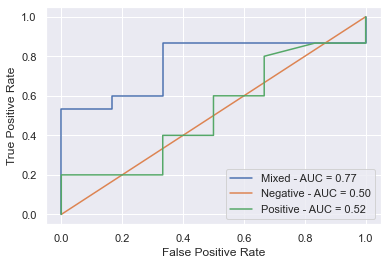

In [550]:
from sklearn import metrics
import matplotlib.pyplot as plt 

fpr, tpr, _ = metrics.roc_curve(y_test_cv,  gridcvs['RForest'].best_estimator_.predict_proba(X_test_mix_PLV_RBP_NoCov)[:,1])
fpr_neg, tpr_neg, _ = metrics.roc_curve(y_test_cv,  gridcvs['RForest'].best_estimator_.predict_proba(X_test_neg_PLV_RBP_NoCov)[:,1])
fpr_pos, tpr_pos, _ = metrics.roc_curve(y_test_cv,  gridcvs['RForest'].best_estimator_.predict_proba(X_test_pos_PLV_RBP_NoCov)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc_neg = metrics.auc(fpr_neg, tpr_neg)
roc_auc_pos = metrics.auc(fpr_pos, tpr_pos)
#create ROC curve
plt.plot(fpr,tpr,label = 'Mixed - AUC = %0.2f' % roc_auc)
plt.plot(fpr_neg,tpr_neg,label = 'Negative - AUC = %0.2f' % roc_auc_neg)
plt.plot(fpr_pos,tpr_pos,label = 'Positive - AUC = %0.2f' % roc_auc_pos)
plt.legend(loc = 0)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Training With Demographics Data Only:
<a id="demog"></a>

In [92]:
df = pd.read_excel (r'C:\Users\Rawad\Desktop\MINDig\PSD_Conn Features\Demographic_BL.xlsx')
df.drop(['Visit','Disease Duration (months)','LED'], 1, inplace=True)
df.drop(85, inplace=True)
if df['Group'][0] == 'PD' or df['Group'][0] == 'HC':
    temp = {'PD': 1, 'HC': 0}
    a = np.array(df['Group'].map(temp))
    df['Group'] = a
df = df.reset_index(drop=True)
df

,ID,Group,Age,EduTot,Sex
0,CG001,1,67.0,18.0,0.0
1,CG002,1,70.0,10.0,1.0
2,CG005,1,62.0,11.0,0.0
3,CG006,1,59.0,11.0,0.0
4,CG007,1,59.0,11.0,0.0
...,...,...,...,...,...
103,CT095,0,67.0,17.0,0.0
104,CT096,0,67.0,18.0,0.0
105,CT097,0,65.0,12.0,0.0
106,CT098,0,71.0,17.0,1.0


In [93]:
X_Demog = df.iloc[:,2:]
y_Demog = df.iloc[:,1]
X_Demog, y_Demog

(      Age  EduTot  Sex
 0    67.0    18.0  0.0
 1    70.0    10.0  1.0
 2    62.0    11.0  0.0
 3    59.0    11.0  0.0
 4    59.0    11.0  0.0
 ..    ...     ...  ...
 103  67.0    17.0  0.0
 104  67.0    18.0  0.0
 105  65.0    12.0  0.0
 106  71.0    17.0  1.0
 107  66.0    10.0  1.0
 
 [108 rows x 3 columns],
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 103    0
 104    0
 105    0
 106    0
 107    0
 Name: Group, Length: 108, dtype: int64)

In [94]:
brain_regions = 210
p_thresh = 0.05

Demog_outer_scores = {}
Demog_outer_roc_scores = {}
Demog_specificity = {}
Demog_sensitivity = {}
Demog_precision = {}
Demog_f1 = {}

for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    Demog_outer_scores['{}'.format(name)] = []
    Demog_outer_roc_scores['{}'.format(name)] = []
    Demog_specificity['{}'.format(name)] = []
    Demog_sensitivity['{}'.format(name)] = []
    Demog_precision['{}'.format(name)] = []
    Demog_f1['{}'.format(name)] = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_Demog, y_Demog):
        
        gridcvs[name].fit(X_Demog.iloc[train_idx], y_Demog.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        nb. of PD in the training set: ' + str(np.count_nonzero(y_Demog.iloc[train_idx]==1)))
        print('        nb. of HC in the training set: ' + str(np.count_nonzero(y_Demog.iloc[train_idx]==0)))
        print('        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        
        # performance on test fold (valid_idx)
        X_test_Demog = X_Demog.iloc[valid_idx]
        y_test_Demog = y_Demog.iloc[valid_idx]
   
        
        Demog_outer_roc_scores['{}'.format(name)].append(roc_auc_score(y_test_Demog, gridcvs[name].best_estimator_.predict_proba(X_test_Demog)[:,1]))
        Demog_outer_scores['{}'.format(name)].append(gridcvs[name].best_estimator_.score(X_test_Demog, y_test_Demog))
        tn, fp, fn, tp = confusion_matrix(y_test_Demog, gridcvs[name].best_estimator_.predict(X_test_Demog)).ravel()
        Demog_sensitivity['{}'.format(name)].append(tp / (tp+fn))
        Demog_specificity['{}'.format(name)].append(tn / (tn+fp))
        Demog_precision['{}'.format(name)].append(tp / (tp+fp))
        Demog_f1['{}'.format(name)].append((2*(Demog_sensitivity['{}'.format(name)][-1] * Demog_precision['{}'.format(name)][-1])/(Demog_sensitivity['{}'.format(name)][-1] + Demog_precision['{}'.format(name)][-1])))
        print('        nb. of PD in the testing set: ' + str(np.count_nonzero(y_test_Demog==1)))
        print('        nb. of HC in the testing set: ' + str(np.count_nonzero(y_test_Demog==0)))
        print('        ACC (on outer test fold) %.2f%%' % (Demog_outer_scores['{}'.format(name)][-1]*100))
        print('        ROC-AUC (on outer test fold) %.2f' % (Demog_outer_roc_scores['{}'.format(name)][-1]))
        print('        Specificity (on outer test fold) %.2f' % (Demog_specificity['{}'.format(name)][-1]))
        print('        Sensitivity (on outer test fold) %.2f' % (Demog_sensitivity['{}'.format(name)][-1]))
        print('        Precision (on outer test fold) %.2f' % (Demog_precision['{}'.format(name)][-1]))
        print('        F1-Score (on outer test fold) %.2f' % (Demog_f1['{}'.format(name)][-1]))
        print('        Confusion matrix: ')
        print(confusion_matrix(y_test_Demog, gridcvs[name].best_estimator_.predict(X_test_Demog)))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(Demog_outer_scores['{}'.format(name)]) * 100, np.std(Demog_outer_scores['{}'.format(name)]) * 100))
    print('        ROC-AUC %.2f +/- %.2f' % 
              (np.mean(Demog_outer_roc_scores['{}'.format(name)]), np.std(Demog_outer_roc_scores['{}'.format(name)])))
    print('        Specificity %.2f +/- %.2f' % 
              (np.mean(Demog_specificity['{}'.format(name)]), np.std(Demog_specificity['{}'.format(name)])))
    print('        Sensitivity %.2f +/- %.2f' % 
              (np.mean(Demog_sensitivity['{}'.format(name)]), np.std(Demog_sensitivity['{}'.format(name)])))
    print('        Precision %.2f +/- %.2f' % 
              (np.mean(Demog_precision['{}'.format(name)]), np.std(Demog_precision['{}'.format(name)])))
    print('        F1-Score %.2f +/- %.2f' % 
              (np.mean(Demog_f1['{}'.format(name)]), np.std(Demog_f1['{}'.format(name)])))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 67.44%
        Best parameters: {'criterion': 'entropy', 'max_depth': 6}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 63.64%
        ROC-AUC (on outer test fold) 0.27
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 0.88
        Precision (on outer test fold) 0.70
        F1-Score (on outer test fold) 0.78
        Confusion matrix: 
[[ 0  6]
 [ 2 14]]

        nb. of PD in the training set: 61
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 68.60%
        Best parameters: {'criterion': 'gini', 'max_depth': 4}
        nb. of PD in the testing set: 16
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 72.73%
    

[[ 3  4]
 [ 3 12]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 59.78%
        Best parameters: {'n_estimators': 10}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 61.90%
        ROC-AUC (on outer test fold) 0.69
        Specificity (on outer test fold) 0.33
        Sensitivity (on outer test fold) 0.73
        Precision (on outer test fold) 0.73
        F1-Score (on outer test fold) 0.73
        Confusion matrix: 
[[ 2  4]
 [ 4 11]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 65.49%
        Best parameters: {'n_estimators': 1000}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer test fold) 0.48
        Specificity (on outer test fold) 0.17
        Sensitivit

C:\Users\Rawad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



        nb. of PD in the training set: 62
        nb. of HC in the training set: 24
        Best ACC (avg. of inner test folds) 72.09%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'none', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 7
        ACC (on outer test fold) 68.18%
        ROC-AUC (on outer test fold) 0.54
        Specificity (on outer test fold) 0.00
        Sensitivity (on outer test fold) 1.00
        Precision (on outer test fold) 0.68
        F1-Score (on outer test fold) 0.81
        Confusion matrix: 
[[ 0  7]
 [ 0 15]]

        nb. of PD in the training set: 62
        nb. of HC in the training set: 25
        Best ACC (avg. of inner test folds) 71.27%
        Best parameters: {'clf1__C': 0.001, 'clf1__penalty': 'l2', 'clf1__solver': 'newton-cg'}
        nb. of PD in the testing set: 15
        nb. of HC in the testing set: 6
        ACC (on outer test fold) 71.43%
        ROC-AUC (on outer

##### Plotting boxplots of the accuracies of all different algorithms in the case of the demographics only

No handles with labels found to put in legend.


Text(0, 0.5, 'Accuracy')

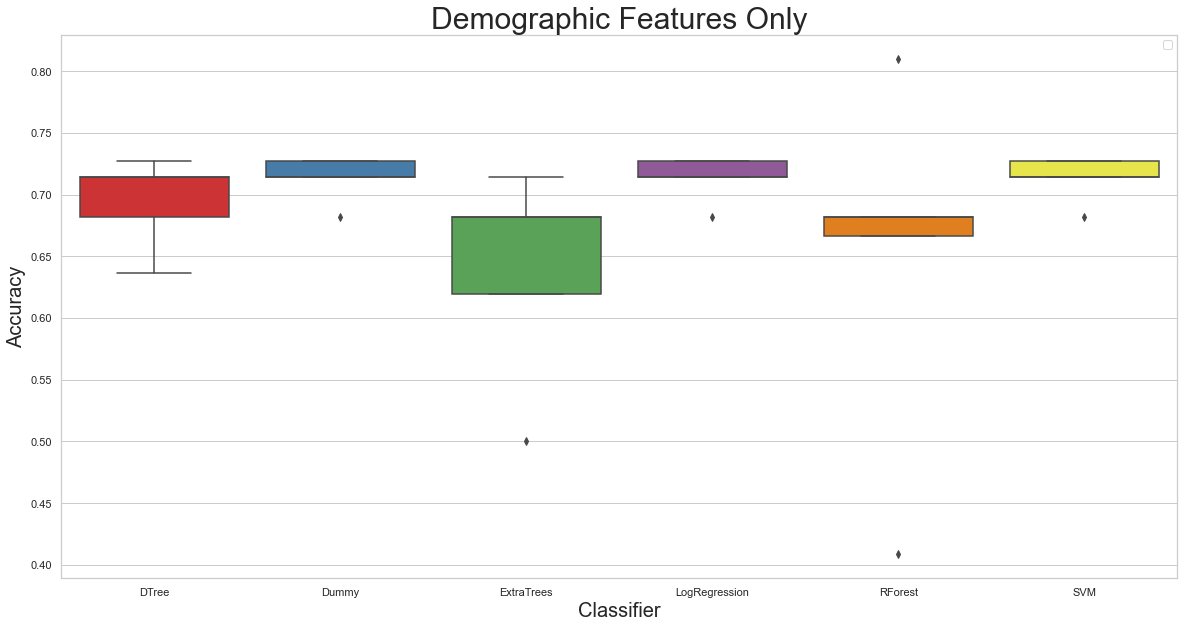

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

df_Demog = pd.DataFrame.from_dict(Demog_outer_scores)
mdf_Demog = pd.melt(df_Demog, var_name=['Algorithm'])  

plt.figure(figsize=(20,10))
plt.legend(loc=0)
a = sns.boxplot(y="value", x="Algorithm", data=mdf_Demog, palette='Set1')  # RUN PLOT  
a.set_title("Demographic Features Only", fontsize = 30)
a.set_xlabel("Classifier", fontsize = 20)
a.set_ylabel("Accuracy", fontsize = 20)

#plt.legend(bbox_to_anchor=(1, 0.6))
#sns.set(rc = {'figure.figsize':(10,5)})
#sns.show()

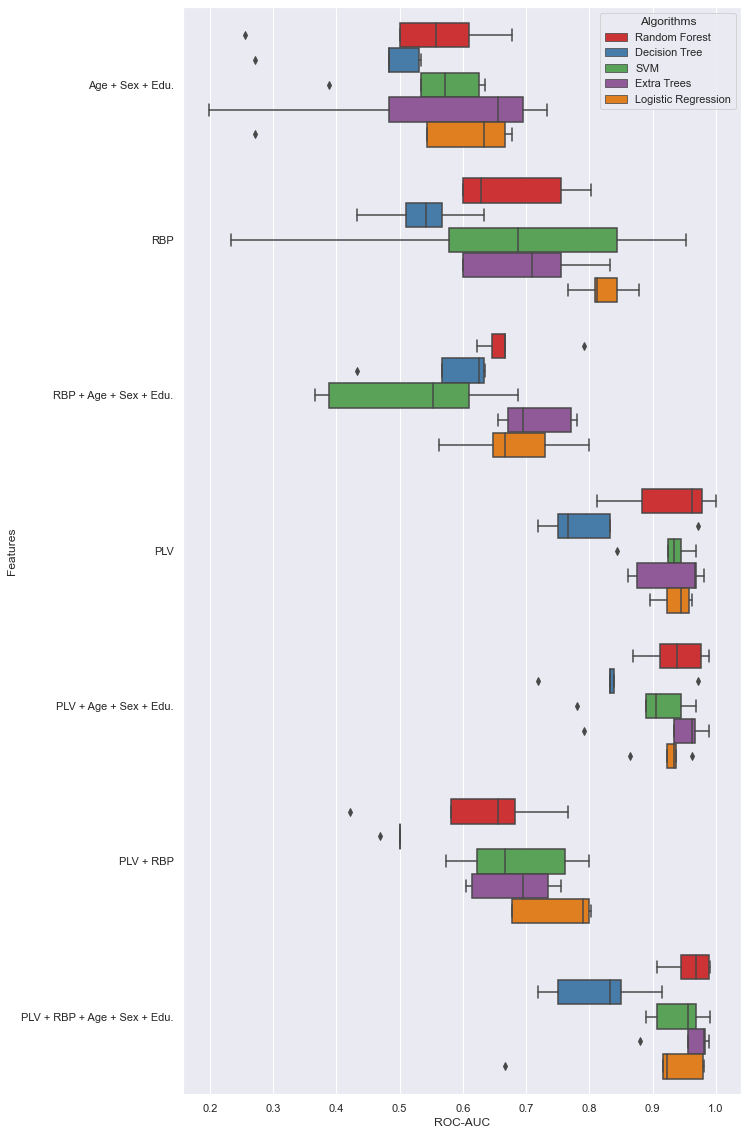

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="whitegrid")

rf = ['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest']
dt = ['Decision Tree', 'Decision Tree', 'Decision Tree', 'Decision Tree', 'Decision Tree', 'Decision Tree', 'Decision Tree']
sv = ['SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM']
et = ['Extra Trees', 'Extra Trees', 'Extra Trees', 'Extra Trees', 'Extra Trees', 'Extra Trees', 'Extra Trees']
lr = ['Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression']

cols = ['ROC-AUC', 'Features', 'Algorithms']
features = ['Age + Sex + Edu.', 'Age + Sex + Edu.', 'Age + Sex + Edu.', 'Age + Sex + Edu.', 'Age + Sex + Edu.', 'RBP', 'RBP', 'RBP', 'RBP', 'RBP', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'RBP + Age + Sex + Edu.', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + Age + Sex + Edu.', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.', 'PLV + RBP + Age + Sex + Edu.']
algorithms = rf + rf + rf + rf + rf + dt + dt + dt + dt + dt + sv + sv + sv + sv + sv + et + et + et + et + et + lr + lr + lr + lr + lr

df_roc = pd.DataFrame(columns=cols)
df_roc['ROC-AUC'] = Demog_outer_roc_scores['RForest'] + RBP_outer_roc_scores_mix_NoCov['RForest'] + RBP_outer_roc_scores_pos['RForest'] + NoCov_outer_roc_scores_mix['RForest'] + outer_roc_scores_mix['RForest'] + PLV_RBP_NoCov_outer_roc_scores_mix['RForest'] + PLV_RBP_outer_roc_scores_mix['RForest'] + Demog_outer_roc_scores['DTree'] + RBP_outer_roc_scores_mix_NoCov['DTree'] + RBP_outer_roc_scores_pos['DTree'] + NoCov_outer_roc_scores_mix['DTree'] + outer_roc_scores_mix['DTree'] + PLV_RBP_NoCov_outer_roc_scores_mix['DTree'] + PLV_RBP_outer_roc_scores_mix['DTree'] + Demog_outer_roc_scores['SVM'] + RBP_outer_roc_scores_mix_NoCov['SVM'] + RBP_outer_roc_scores_pos['SVM'] + NoCov_outer_roc_scores_mix['SVM'] + outer_roc_scores_mix['SVM'] + PLV_RBP_NoCov_outer_roc_scores_mix['SVM'] + PLV_RBP_outer_roc_scores_mix['SVM'] + Demog_outer_roc_scores['ExtraTrees'] + RBP_outer_roc_scores_mix_NoCov['ExtraTrees'] + RBP_outer_roc_scores_pos['ExtraTrees'] + NoCov_outer_roc_scores_mix['ExtraTrees'] + outer_roc_scores_mix['ExtraTrees'] + PLV_RBP_NoCov_outer_roc_scores_mix['ExtraTrees'] + PLV_RBP_outer_roc_scores_mix['ExtraTrees'] + Demog_outer_roc_scores['LogRegression'] + RBP_outer_roc_scores_mix_NoCov['LogRegression'] + RBP_outer_roc_scores_pos['LogRegression'] + NoCov_outer_roc_scores_mix['LogRegression'] + outer_roc_scores_mix['LogRegression'] + PLV_RBP_NoCov_outer_roc_scores_mix['LogRegression'] + PLV_RBP_outer_roc_scores_mix['LogRegression']
df_roc['Features'] = features + features + features + features + features
df_roc['Algorithms'] = algorithms

sns.set()

plt.figure(figsize=(10,20))
ax = sns.boxplot(x="ROC-AUC", y="Features", hue="Algorithms", data=df_roc, palette="Set1")